In [1]:
# --- 1. Imports and Setup ---

import pathlib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths
PROC = pathlib.Path("data_proc")
GLOVE_DIR = pathlib.Path("glove")
MODELS = pathlib.Path("models")
MODELS.mkdir(exist_ok=True)

# Use 100-dimensional GloVe embeddings
GLOVE_FILE = GLOVE_DIR / "glove.6B.100d.txt"

# Model parameters
VOCAB_SIZE = 10000  # Limit vocabulary to top 10k words
MAX_LENGTH = 50     # Max sequence length
EMBEDDING_DIM = 100 # Dimension of GloVe embeddings
OOV_TOKEN = "<OOV>" # Out-of-vocabulary token

print("Setup complete.")

Setup complete.


In [2]:
# --- 2. Load Datasets ---

# Load the pre-split and balanced datasets
df_train = pd.read_csv(PROC / "train.csv")
df_val = pd.read_csv(PROC / "val.csv")
df_test = pd.read_csv(PROC / "test.csv")

# Prepare text and labels
X_train = df_train['cleaned_utterance'].astype(str)
y_train_text = df_train['emotion']

X_val = df_val['cleaned_utterance'].astype(str)
y_val_text = df_val['emotion']

X_test = df_test['cleaned_utterance'].astype(str)
y_test_text = df_test['emotion']

# Use LabelEncoder to convert text labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(y_train_text) # Fit on the full range of emotions

y_train = label_encoder.transform(y_train_text)
y_val = label_encoder.transform(y_val_text)
y_test = label_encoder.transform(y_test_text)

# Get the mapping from encoded integer to label name
label_names = list(label_encoder.classes_)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Encoded label names: {label_names}")

Training data shape: (87957,)
Validation data shape: (10995,)
Test data shape: (10995,)
Encoded label names: ['anger', 'disgust', 'fear', 'happiness', 'no_emotion', 'sadness', 'surprise']


In [3]:
# --- 3. Tokenization and Padding ---

# Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

# One-hot encode the labels for the neural network
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

print(f"Shape of padded training sequences: {X_train_pad.shape}")
print(f"Shape of one-hot encoded training labels: {y_train_cat.shape}")

Shape of padded training sequences: (87957, 50)
Shape of one-hot encoded training labels: (87957, 7)


In [4]:
# --- 4. Load GloVe Embeddings ---

# Create a dictionary mapping words to their GloVe vector representation
embeddings_index = {}
try:
    with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
except FileNotFoundError:
    print(f"Error: GloVe file not found at {GLOVE_FILE}")
    print("Please download and place it in the 'glove' directory.")
    # Stop execution if the file is not found
    raise

print(f"Found {len(embeddings_index)} word vectors in GloVe file.")

# Create an embedding matrix for the words in our vocabulary
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Found 400000 word vectors in GloVe file.
Shape of embedding matrix: (10000, 100)


In [5]:
# --- 5. Define the BiLSTM Model ---

model = Sequential([
    # Embedding layer initialized with GloVe embeddings
    Embedding(
        VOCAB_SIZE, 
        EMBEDDING_DIM, 
        weights=[embedding_matrix], 
        input_length=MAX_LENGTH, 
        trainable=False  # Freeze the embedding layer
    ),
    
    # Bidirectional LSTM layer
    Bidirectional(LSTM(64)),
    
    # Dropout layer for regularization
    Dropout(0.5),
    
    # Dense hidden layer
    Dense(64, activation='relu'),
    
    # Output layer
    Dense(len(label_names), activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/Users/venusikhakolli/Downloads/projects/nlp-team17/.venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [6]:
# --- 6. Train the Model ---

NUM_EPOCHS = 20
BATCH_SIZE = 64

# Define callbacks
# Stop training if validation loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    filepath=MODELS / 'bilstm_glove_baseline.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

print("Starting model training...")

history = model.fit(
    X_train_pad, y_train_cat,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stopping, model_checkpoint]
)

print("Model training complete.")

Starting model training...
Epoch 1/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 40:58 2s/step - accuracy: 0.1250 - loss: 1.9579

   5/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.1754 - loss: 1.9442

   9/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2084 - loss: 1.9237

  13/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.2253 - loss: 1.9076

  17/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2397 - loss: 1.8888

  21/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2508 - loss: 1.8722

  25/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2594 - loss: 1.8583

  29/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2672 - loss: 1.8452

  33/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2735 - loss: 1.8344

  37/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2790 - loss: 1.8251

  41/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2834 - loss: 1.8172

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2874 - loss: 1.8102

  49/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2911 - loss: 1.8034

  53/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2944 - loss: 1.7970

  57/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.2977 - loss: 1.7908

  61/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3007 - loss: 1.7851

  65/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3034 - loss: 1.7798

  69/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3060 - loss: 1.7748

  73/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3085 - loss: 1.7701

  77/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3108 - loss: 1.7657

  81/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3130 - loss: 1.7613

  85/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3153 - loss: 1.7569

  89/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3175 - loss: 1.7526

  92/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.3191 - loss: 1.7493

  95/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.3207 - loss: 1.7461

  98/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.3222 - loss: 1.7431

 101/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.3237 - loss: 1.7400

 103/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.3247 - loss: 1.7381

 105/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.3256 - loss: 1.7361

 107/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.3265 - loss: 1.7342

 110/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.3279 - loss: 1.7314

 112/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.3287 - loss: 1.7296

 115/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.3300 - loss: 1.7270

 118/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.3313 - loss: 1.7243

 120/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.3321 - loss: 1.7226

 123/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.3334 - loss: 1.7201

 126/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.3346 - loss: 1.7176

 129/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.3358 - loss: 1.7151

 131/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.3367 - loss: 1.7135

 133/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3375 - loss: 1.7119

 136/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3386 - loss: 1.7096

 139/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3398 - loss: 1.7073

 142/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3410 - loss: 1.7050

 144/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.3417 - loss: 1.7035

 146/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.3425 - loss: 1.7021

 148/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.3432 - loss: 1.7006

 150/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.3439 - loss: 1.6992

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.3447 - loss: 1.6978

 153/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.3450 - loss: 1.6971

 155/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.3457 - loss: 1.6957

 158/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.3467 - loss: 1.6936

 160/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3474 - loss: 1.6923

 163/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3484 - loss: 1.6903

 165/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3491 - loss: 1.6890

 168/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3501 - loss: 1.6871

 171/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3510 - loss: 1.6852

 174/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3519 - loss: 1.6834

 177/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3528 - loss: 1.6816

 180/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3537 - loss: 1.6798

 183/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3546 - loss: 1.6781

 186/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.3555 - loss: 1.6764

 189/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3563 - loss: 1.6748

 192/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3572 - loss: 1.6731

 194/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3578 - loss: 1.6720

 197/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3586 - loss: 1.6704

 200/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3594 - loss: 1.6688

 203/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3602 - loss: 1.6673

 205/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3608 - loss: 1.6662

 208/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3616 - loss: 1.6647

 211/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3623 - loss: 1.6633

 214/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3631 - loss: 1.6618

 216/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3636 - loss: 1.6609

 218/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3640 - loss: 1.6599

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3648 - loss: 1.6586

 224/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3655 - loss: 1.6572

 226/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3660 - loss: 1.6563

 228/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3664 - loss: 1.6554

 231/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3671 - loss: 1.6541

 234/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3678 - loss: 1.6527

 237/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3685 - loss: 1.6514

 239/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3689 - loss: 1.6506

 242/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3696 - loss: 1.6493

 245/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3702 - loss: 1.6481

 248/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3709 - loss: 1.6468

 251/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3715 - loss: 1.6456

 254/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3721 - loss: 1.6444

 257/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3728 - loss: 1.6432

 260/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3734 - loss: 1.6420

 262/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3738 - loss: 1.6413

 264/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3742 - loss: 1.6405

 266/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3746 - loss: 1.6398

 268/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3750 - loss: 1.6390

 271/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3756 - loss: 1.6379

 273/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3760 - loss: 1.6372

 276/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3765 - loss: 1.6361

 278/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3769 - loss: 1.6354

 280/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3773 - loss: 1.6347

 283/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.3778 - loss: 1.6337

 286/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3784 - loss: 1.6326

 289/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3789 - loss: 1.6316

 292/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3794 - loss: 1.6306

 295/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3799 - loss: 1.6297

 298/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3804 - loss: 1.6287

 301/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3809 - loss: 1.6277

 304/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3814 - loss: 1.6268

 307/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3819 - loss: 1.6258

 309/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3822 - loss: 1.6252

 311/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3826 - loss: 1.6246

 314/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3831 - loss: 1.6237

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3835 - loss: 1.6227

 320/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3840 - loss: 1.6218

 322/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3843 - loss: 1.6212

 324/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3846 - loss: 1.6207

 326/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3849 - loss: 1.6201

 328/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3852 - loss: 1.6195

 331/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3857 - loss: 1.6186

 334/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3861 - loss: 1.6178

 337/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3866 - loss: 1.6169

 340/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3870 - loss: 1.6161

 343/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3874 - loss: 1.6153

 345/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3877 - loss: 1.6147

 348/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.3881 - loss: 1.6139

 351/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.3885 - loss: 1.6131

 353/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.3888 - loss: 1.6126

 355/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3891 - loss: 1.6120

 358/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3895 - loss: 1.6113

 361/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3899 - loss: 1.6105

 363/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3901 - loss: 1.6100

 366/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3905 - loss: 1.6092

 369/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3909 - loss: 1.6085

 371/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3912 - loss: 1.6080

 374/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3915 - loss: 1.6072

 377/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3919 - loss: 1.6065

 380/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3923 - loss: 1.6058

 383/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3926 - loss: 1.6050

 386/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3930 - loss: 1.6043

 389/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3934 - loss: 1.6036

 392/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3937 - loss: 1.6029

 395/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3941 - loss: 1.6022

 398/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3944 - loss: 1.6016

 401/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3948 - loss: 1.6009

 404/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3951 - loss: 1.6002

 407/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3954 - loss: 1.5996

 410/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.3958 - loss: 1.5989

 413/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3961 - loss: 1.5983

 416/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3964 - loss: 1.5976

 419/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3968 - loss: 1.5970

 422/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3971 - loss: 1.5964

 425/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3974 - loss: 1.5957

 428/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3977 - loss: 1.5951

 431/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3980 - loss: 1.5945

 434/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3983 - loss: 1.5939

 437/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3986 - loss: 1.5933

 440/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3990 - loss: 1.5927

 443/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3993 - loss: 1.5921

 445/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3995 - loss: 1.5917

 448/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3998 - loss: 1.5911

 451/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.4001 - loss: 1.5905

 453/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.4002 - loss: 1.5901

 456/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.4005 - loss: 1.5895

 459/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.4008 - loss: 1.5890

 462/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.4011 - loss: 1.5884

 465/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4014 - loss: 1.5878

 467/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4016 - loss: 1.5875

 469/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4018 - loss: 1.5871

 471/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4020 - loss: 1.5867

 473/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4021 - loss: 1.5864

 475/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4023 - loss: 1.5860

 478/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4026 - loss: 1.5855

 481/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4029 - loss: 1.5849

 484/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4031 - loss: 1.5844

 487/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4034 - loss: 1.5839

 489/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4036 - loss: 1.5835

 492/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4038 - loss: 1.5830

 495/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4041 - loss: 1.5825

 497/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4043 - loss: 1.5821

 500/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4045 - loss: 1.5816

 502/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4047 - loss: 1.5813

 505/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4050 - loss: 1.5807

 507/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4051 - loss: 1.5804

 509/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4053 - loss: 1.5801

 512/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.4056 - loss: 1.5796

 515/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4058 - loss: 1.5791

 518/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4061 - loss: 1.5786

 520/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4062 - loss: 1.5782

 522/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4064 - loss: 1.5779

 524/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4066 - loss: 1.5776

 527/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4068 - loss: 1.5771

 530/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4071 - loss: 1.5766

 533/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4073 - loss: 1.5761

 536/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4076 - loss: 1.5756

 538/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4077 - loss: 1.5753

 541/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4080 - loss: 1.5749

 544/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4082 - loss: 1.5744

 547/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4084 - loss: 1.5739

 550/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4087 - loss: 1.5735

 553/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4089 - loss: 1.5730

 556/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4091 - loss: 1.5726

 559/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.4094 - loss: 1.5721

 562/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4096 - loss: 1.5717

 565/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4098 - loss: 1.5712

 568/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4101 - loss: 1.5708

 571/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4103 - loss: 1.5704

 574/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4105 - loss: 1.5699

 576/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4106 - loss: 1.5697

 579/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4109 - loss: 1.5692

 582/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4111 - loss: 1.5688

 585/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4113 - loss: 1.5684

 587/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4115 - loss: 1.5681

 590/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4117 - loss: 1.5677

 593/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4119 - loss: 1.5672

 596/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4121 - loss: 1.5668

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4123 - loss: 1.5664

 602/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4125 - loss: 1.5660

 605/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4127 - loss: 1.5656

 608/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4130 - loss: 1.5652

 611/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4132 - loss: 1.5648

 614/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4134 - loss: 1.5644

 617/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4136 - loss: 1.5640

 620/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4138 - loss: 1.5636

 623/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4140 - loss: 1.5632

 626/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.4142 - loss: 1.5628

 628/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4143 - loss: 1.5625

 630/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4144 - loss: 1.5623

 632/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4146 - loss: 1.5620

 635/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4148 - loss: 1.5616

 637/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4149 - loss: 1.5614

 639/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4150 - loss: 1.5611

 641/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4151 - loss: 1.5609

 644/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4153 - loss: 1.5605

 647/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4155 - loss: 1.5601

 650/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4157 - loss: 1.5597

 653/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.4159 - loss: 1.5594

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4161 - loss: 1.5590

 658/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4162 - loss: 1.5587

 661/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4164 - loss: 1.5584

 663/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4165 - loss: 1.5581

 666/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4167 - loss: 1.5578

 669/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4169 - loss: 1.5574

 672/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4170 - loss: 1.5570

 675/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4172 - loss: 1.5567

 678/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4174 - loss: 1.5563

 681/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4176 - loss: 1.5560

 684/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4178 - loss: 1.5556

 687/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4179 - loss: 1.5552

 689/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4181 - loss: 1.5550

 692/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4182 - loss: 1.5547

 695/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.4184 - loss: 1.5543

 698/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4186 - loss: 1.5540

 701/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4188 - loss: 1.5536

 704/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4189 - loss: 1.5533

 707/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4191 - loss: 1.5529

 710/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4193 - loss: 1.5526

 712/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4194 - loss: 1.5523

 714/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4195 - loss: 1.5521

 716/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4196 - loss: 1.5519

 718/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4197 - loss: 1.5517

 721/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4199 - loss: 1.5513

 723/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4200 - loss: 1.5511

 726/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4202 - loss: 1.5508

 729/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4203 - loss: 1.5504

 732/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4205 - loss: 1.5501

 735/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4206 - loss: 1.5498

 737/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4208 - loss: 1.5495

 740/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4209 - loss: 1.5492

 743/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4211 - loss: 1.5489

 746/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4212 - loss: 1.5486

 749/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4214 - loss: 1.5482

 752/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4216 - loss: 1.5479

 755/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4217 - loss: 1.5476

 757/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4218 - loss: 1.5474

 760/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4220 - loss: 1.5470

 763/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4221 - loss: 1.5467

 766/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4223 - loss: 1.5464

 769/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4225 - loss: 1.5461

 772/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4226 - loss: 1.5457

 775/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4228 - loss: 1.5454

 778/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4229 - loss: 1.5451

 781/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4231 - loss: 1.5448

 784/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4232 - loss: 1.5445

 787/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4234 - loss: 1.5441

 789/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4235 - loss: 1.5439

 792/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4237 - loss: 1.5436

 795/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4238 - loss: 1.5433

 797/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4239 - loss: 1.5431

 800/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4241 - loss: 1.5428

 803/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4242 - loss: 1.5425

 806/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4244 - loss: 1.5422

 809/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4245 - loss: 1.5419

 812/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4247 - loss: 1.5416

 814/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4248 - loss: 1.5414

 817/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4249 - loss: 1.5411

 820/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4251 - loss: 1.5408

 823/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4252 - loss: 1.5405

 825/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4253 - loss: 1.5403

 827/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.4254 - loss: 1.5401

 830/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4255 - loss: 1.5398

 833/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4257 - loss: 1.5395

 836/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4258 - loss: 1.5392

 838/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4259 - loss: 1.5390

 840/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4260 - loss: 1.5388

 843/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4262 - loss: 1.5385

 845/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4263 - loss: 1.5383

 848/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4264 - loss: 1.5380

 850/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4265 - loss: 1.5378

 853/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4266 - loss: 1.5375

 856/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4268 - loss: 1.5372

 859/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4269 - loss: 1.5369

 862/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4271 - loss: 1.5367

 865/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4272 - loss: 1.5364

 868/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4273 - loss: 1.5361

 871/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.4275 - loss: 1.5358

 874/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4276 - loss: 1.5355

 877/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4278 - loss: 1.5352

 880/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4279 - loss: 1.5350

 883/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4280 - loss: 1.5347

 886/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4282 - loss: 1.5344

 888/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4283 - loss: 1.5342

 891/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4284 - loss: 1.5339

 893/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4285 - loss: 1.5337

 895/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4286 - loss: 1.5336

 897/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4287 - loss: 1.5334

 900/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4288 - loss: 1.5331

 903/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4289 - loss: 1.5328

 906/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4291 - loss: 1.5325

 908/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4292 - loss: 1.5324

 911/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4293 - loss: 1.5321

 913/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4294 - loss: 1.5319

 915/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4295 - loss: 1.5317

 918/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4296 - loss: 1.5314

 921/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4297 - loss: 1.5312

 923/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4298 - loss: 1.5310

 926/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4300 - loss: 1.5307

 929/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4301 - loss: 1.5304

 932/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4302 - loss: 1.5301

 935/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4304 - loss: 1.5299

 938/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4305 - loss: 1.5296

 941/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4306 - loss: 1.5293

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4307 - loss: 1.5291

 946/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4308 - loss: 1.5289

 949/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4310 - loss: 1.5286

 952/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4311 - loss: 1.5283

 955/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.4312 - loss: 1.5280

 958/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4314 - loss: 1.5278 

 961/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4315 - loss: 1.5275

 964/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4316 - loss: 1.5272

 967/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4317 - loss: 1.5270

 970/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4319 - loss: 1.5267

 973/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4320 - loss: 1.5264

 975/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4321 - loss: 1.5263

 977/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4322 - loss: 1.5261

 980/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4323 - loss: 1.5258

 982/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4324 - loss: 1.5257

 985/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4325 - loss: 1.5254

 988/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4326 - loss: 1.5251

 991/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4328 - loss: 1.5249

 993/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4328 - loss: 1.5247

 996/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4330 - loss: 1.5244

 999/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.4331 - loss: 1.5242

1002/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4332 - loss: 1.5239

1005/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4333 - loss: 1.5237

1008/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4335 - loss: 1.5234

1011/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4336 - loss: 1.5231

1014/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4337 - loss: 1.5229

1017/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4338 - loss: 1.5226

1020/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4339 - loss: 1.5224

1023/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4341 - loss: 1.5221

1026/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4342 - loss: 1.5219

1029/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4343 - loss: 1.5216

1032/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4344 - loss: 1.5214

1034/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4345 - loss: 1.5212

1037/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4346 - loss: 1.5209

1040/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4347 - loss: 1.5207

1043/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4349 - loss: 1.5204

1046/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4350 - loss: 1.5202

1049/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4351 - loss: 1.5200

1052/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4352 - loss: 1.5197

1055/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4353 - loss: 1.5195

1058/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4355 - loss: 1.5192

1061/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4356 - loss: 1.5190

1064/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4357 - loss: 1.5187

1067/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4358 - loss: 1.5185

1070/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4359 - loss: 1.5182

1073/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4360 - loss: 1.5180

1075/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4361 - loss: 1.5178

1077/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4362 - loss: 1.5177

1079/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4363 - loss: 1.5175

1081/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4363 - loss: 1.5173

1084/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4365 - loss: 1.5171

1086/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4365 - loss: 1.5170

1089/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4366 - loss: 1.5167

1092/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4368 - loss: 1.5165

1095/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4369 - loss: 1.5162

1098/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4370 - loss: 1.5160

1101/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4371 - loss: 1.5158

1104/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4372 - loss: 1.5155

1107/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4373 - loss: 1.5153

1110/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4374 - loss: 1.5151

1112/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4375 - loss: 1.5149

1115/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4376 - loss: 1.5147

1117/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4377 - loss: 1.5145

1120/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4378 - loss: 1.5143

1123/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4379 - loss: 1.5141

1126/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4380 - loss: 1.5139

1129/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4381 - loss: 1.5136

1132/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4382 - loss: 1.5134

1134/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4383 - loss: 1.5133

1137/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4384 - loss: 1.5130

1140/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4385 - loss: 1.5128

1143/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4386 - loss: 1.5126

1146/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4387 - loss: 1.5123

1149/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4388 - loss: 1.5121

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4389 - loss: 1.5120

1154/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4390 - loss: 1.5118

1157/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4391 - loss: 1.5115

1160/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4392 - loss: 1.5113

1163/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4393 - loss: 1.5111

1166/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.4394 - loss: 1.5109

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4395 - loss: 1.5106

1172/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4397 - loss: 1.5104

1175/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4398 - loss: 1.5102

1178/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4399 - loss: 1.5100

1181/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4400 - loss: 1.5098

1183/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4400 - loss: 1.5096

1186/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4401 - loss: 1.5094

1189/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4403 - loss: 1.5092

1192/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4404 - loss: 1.5090

1195/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4405 - loss: 1.5087

1198/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4406 - loss: 1.5085

1200/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4406 - loss: 1.5084

1202/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4407 - loss: 1.5082

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4408 - loss: 1.5080

1207/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4409 - loss: 1.5079

1210/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4410 - loss: 1.5077

1213/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4411 - loss: 1.5074

1216/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4412 - loss: 1.5072

1219/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4413 - loss: 1.5070

1221/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4414 - loss: 1.5069

1223/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4414 - loss: 1.5067

1226/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4415 - loss: 1.5065

1229/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4416 - loss: 1.5063

1231/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4417 - loss: 1.5062

1233/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4418 - loss: 1.5060

1235/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4418 - loss: 1.5059

1238/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4419 - loss: 1.5057

1240/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4420 - loss: 1.5055

1243/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4421 - loss: 1.5053

1246/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4422 - loss: 1.5051

1249/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4423 - loss: 1.5049

1252/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4424 - loss: 1.5047

1255/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4425 - loss: 1.5045

1258/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4426 - loss: 1.5043

1261/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4427 - loss: 1.5041

1264/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4428 - loss: 1.5039

1266/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4429 - loss: 1.5037

1269/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4430 - loss: 1.5035

1272/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4431 - loss: 1.5033

1274/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4431 - loss: 1.5032

1277/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4432 - loss: 1.5030

1280/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4433 - loss: 1.5028

1283/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4434 - loss: 1.5026

1286/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4435 - loss: 1.5024

1289/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4436 - loss: 1.5022

1292/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4437 - loss: 1.5020

1295/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4438 - loss: 1.5018

1297/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4439 - loss: 1.5016

1300/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4440 - loss: 1.5014

1303/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4441 - loss: 1.5012

1306/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4441 - loss: 1.5010

1309/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4442 - loss: 1.5008

1312/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4443 - loss: 1.5006

1315/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4444 - loss: 1.5005

1317/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4445 - loss: 1.5003

1320/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4446 - loss: 1.5001

1323/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4447 - loss: 1.4999

1326/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4448 - loss: 1.4997

1329/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4449 - loss: 1.4995

1332/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4450 - loss: 1.4994

1335/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4451 - loss: 1.4992

1338/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4451 - loss: 1.4990

1340/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4452 - loss: 1.4988

1343/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4453 - loss: 1.4986

1346/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4454 - loss: 1.4985

1349/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4455 - loss: 1.4983

1352/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4456 - loss: 1.4981

1355/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4457 - loss: 1.4979

1357/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4457 - loss: 1.4978

1360/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4458 - loss: 1.4976

1362/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4459 - loss: 1.4975

1364/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4459 - loss: 1.4973

1367/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4460 - loss: 1.4971

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4461 - loss: 1.4970

1373/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4462 - loss: 1.4968

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.4868 - loss: 1.4115 - val_accuracy: 0.5302 - val_loss: 1.3234


Epoch 2/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.4844 - loss: 1.3948

   4/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5195 - loss: 1.3711

   6/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5165 - loss: 1.3781

   9/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5196 - loss: 1.3724

  12/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5264 - loss: 1.3642

  14/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5285 - loss: 1.3612

  16/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5299 - loss: 1.3592

  18/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5315 - loss: 1.3563

  21/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5334 - loss: 1.3521

  23/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5342 - loss: 1.3503

  26/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5353 - loss: 1.3475

  28/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5360 - loss: 1.3457

  31/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5370 - loss: 1.3426

  33/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5374 - loss: 1.3411

  35/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5378 - loss: 1.3395

  38/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5381 - loss: 1.3375

  40/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5380 - loss: 1.3367

  43/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5377 - loss: 1.3357

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5374 - loss: 1.3352

  48/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5373 - loss: 1.3344

  51/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5370 - loss: 1.3337

  54/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5368 - loss: 1.3332

  57/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5366 - loss: 1.3327

  60/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5364 - loss: 1.3324

  63/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5362 - loss: 1.3322

  66/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5359 - loss: 1.3319

  68/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5358 - loss: 1.3317

  71/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5356 - loss: 1.3314

  73/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5355 - loss: 1.3311

  76/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5352 - loss: 1.3310

  79/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5350 - loss: 1.3309

  82/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5347 - loss: 1.3309

  85/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5345 - loss: 1.3309

  88/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5342 - loss: 1.3310

  91/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5339 - loss: 1.3311

  93/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5337 - loss: 1.3311

  96/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5334 - loss: 1.3313

  99/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5330 - loss: 1.3315

 102/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5327 - loss: 1.3317

 104/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5326 - loss: 1.3318

 107/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5323 - loss: 1.3318

 109/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5322 - loss: 1.3318

 111/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5321 - loss: 1.3319

 114/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5318 - loss: 1.3319

 116/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5317 - loss: 1.3320

 117/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5316 - loss: 1.3320

 119/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5315 - loss: 1.3320

 121/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5313 - loss: 1.3320

 123/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5312 - loss: 1.3320

 125/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5310 - loss: 1.3321

 127/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5309 - loss: 1.3321

 129/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5307 - loss: 1.3322

 131/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5306 - loss: 1.3322

 133/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5305 - loss: 1.3322

 136/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5303 - loss: 1.3322

 139/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5301 - loss: 1.3321

 141/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5300 - loss: 1.3321

 143/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5299 - loss: 1.3321

 145/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5298 - loss: 1.3321

 147/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5297 - loss: 1.3321

 149/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5296 - loss: 1.3321

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5294 - loss: 1.3321

 155/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5292 - loss: 1.3321

 157/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5291 - loss: 1.3320

 160/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5290 - loss: 1.3320

 163/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5289 - loss: 1.3319

 166/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5288 - loss: 1.3318

 168/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5287 - loss: 1.3318

 170/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5286 - loss: 1.3317

 172/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5285 - loss: 1.3317

 175/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5284 - loss: 1.3316

 178/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5283 - loss: 1.3316

 181/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5282 - loss: 1.3315

 184/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5281 - loss: 1.3314

 186/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5281 - loss: 1.3313

 189/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5280 - loss: 1.3312

 192/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5279 - loss: 1.3311

 194/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5278 - loss: 1.3311

 197/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5278 - loss: 1.3309

 200/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5277 - loss: 1.3308

 203/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5276 - loss: 1.3307

 206/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5276 - loss: 1.3306

 209/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5275 - loss: 1.3305

 212/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5275 - loss: 1.3303

 215/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5275 - loss: 1.3302

 217/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5274 - loss: 1.3301

 219/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5274 - loss: 1.3300

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5274 - loss: 1.3299

 223/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5274 - loss: 1.3298

 225/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5274 - loss: 1.3297

 227/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5274 - loss: 1.3296

 229/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5274 - loss: 1.3295

 231/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5273 - loss: 1.3294

 233/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5273 - loss: 1.3293

 235/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5273 - loss: 1.3293

 238/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5273 - loss: 1.3291

 240/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5273 - loss: 1.3290

 243/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5273 - loss: 1.3289

 245/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5273 - loss: 1.3288

 247/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3287

 249/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3286

 251/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3285

 253/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3284

 255/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3283

 257/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3283

 259/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3282

 261/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3281

 263/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3280

 265/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3279

 267/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3279

 269/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3278

 271/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3278

 273/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3277

 275/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3276

 277/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3276

 279/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3275

 281/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3274

 283/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3274

 285/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5273 - loss: 1.3273

 287/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3272

 289/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3272

 291/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3271

 294/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3270

 296/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3269

 299/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3269

 301/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3268

 304/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3267

 306/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3267

 308/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3266

 310/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3266

 312/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3265

 314/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3265

 316/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3264

 318/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3264

 321/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3263

 323/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5273 - loss: 1.3262

 325/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3262

 328/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3261

 330/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3261

 332/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3260

 334/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3260

 336/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3259

 338/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3258

 341/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3258

 344/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3257

 346/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3256

 349/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5273 - loss: 1.3255

 352/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5274 - loss: 1.3255

 354/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5274 - loss: 1.3254

 356/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5274 - loss: 1.3254

 358/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5274 - loss: 1.3253

 360/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5274 - loss: 1.3253

 362/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3253

 364/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3252

 367/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3252

 369/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3251

 371/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3251

 374/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3250

 376/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3250

 378/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3249

 380/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3249

 382/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3249

 384/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3248

 387/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3247

 390/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3247

 393/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3246

 395/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3246

 398/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5274 - loss: 1.3245

 401/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3244

 403/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3244

 405/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3244

 407/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3243

 409/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3243

 411/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3242

 413/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3242

 415/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3241

 417/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3241

 419/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3241

 421/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3240

 423/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3240

 425/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3239

 428/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3239

 430/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5275 - loss: 1.3238

 432/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5276 - loss: 1.3238

 434/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5276 - loss: 1.3238

 437/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3237

 440/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3236

 443/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3236

 445/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3235

 448/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3235

 451/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3234

 453/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3234

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3233

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3232

 461/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3232

 463/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3231

 466/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5276 - loss: 1.3231

 469/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5277 - loss: 1.3230

 471/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5277 - loss: 1.3229

 474/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5277 - loss: 1.3229

 477/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5277 - loss: 1.3228

 479/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5277 - loss: 1.3228

 482/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5277 - loss: 1.3227

 485/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5277 - loss: 1.3226

 487/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5277 - loss: 1.3226

 490/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5277 - loss: 1.3226

 492/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5277 - loss: 1.3225

 495/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5277 - loss: 1.3225

 497/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5277 - loss: 1.3224

 500/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5278 - loss: 1.3224

 503/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5278 - loss: 1.3223

 505/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5278 - loss: 1.3223

 508/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5278 - loss: 1.3222

 510/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5278 - loss: 1.3222

 512/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5278 - loss: 1.3221

 515/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5278 - loss: 1.3221

 518/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5278 - loss: 1.3220

 520/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5279 - loss: 1.3220

 523/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5279 - loss: 1.3219

 526/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5279 - loss: 1.3218

 529/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5279 - loss: 1.3218

 531/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5279 - loss: 1.3217

 534/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5279 - loss: 1.3216

 537/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5279 - loss: 1.3216

 540/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5280 - loss: 1.3215

 543/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5280 - loss: 1.3215

 546/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5280 - loss: 1.3214

 549/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5280 - loss: 1.3213

 552/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5280 - loss: 1.3213

 555/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5281 - loss: 1.3212

 558/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5281 - loss: 1.3212

 561/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5281 - loss: 1.3211

 564/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5281 - loss: 1.3210

 566/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5281 - loss: 1.3210

 568/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5281 - loss: 1.3210

 570/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5281 - loss: 1.3209

 573/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5282 - loss: 1.3209

 575/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5282 - loss: 1.3208

 577/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5282 - loss: 1.3208

 580/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5282 - loss: 1.3207

 583/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5282 - loss: 1.3207

 586/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5282 - loss: 1.3206

 589/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5282 - loss: 1.3206

 592/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5282 - loss: 1.3205

 594/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5283 - loss: 1.3205

 597/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5283 - loss: 1.3204

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5283 - loss: 1.3204

 602/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5283 - loss: 1.3203

 605/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5283 - loss: 1.3203

 607/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5283 - loss: 1.3202

 610/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5283 - loss: 1.3202

 613/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5283 - loss: 1.3201

 616/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5284 - loss: 1.3201

 619/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5284 - loss: 1.3200

 621/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5284 - loss: 1.3200

 623/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5284 - loss: 1.3199

 626/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5284 - loss: 1.3199

 628/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5284 - loss: 1.3198

 630/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5284 - loss: 1.3198

 632/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5284 - loss: 1.3198

 634/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5284 - loss: 1.3197

 636/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5284 - loss: 1.3197

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5284 - loss: 1.3197

 640/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5284 - loss: 1.3196

 642/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5284 - loss: 1.3196

 644/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3196

 646/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3196

 649/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3195

 651/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3195

 653/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3195

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3194

 659/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3194

 661/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3193

 663/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3193

 666/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5285 - loss: 1.3193

 669/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3192

 671/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3192

 673/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3192

 675/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3191

 677/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3191

 680/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3191

 683/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3190

 685/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3190

 687/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3190

 689/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3190

 691/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3189

 693/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5285 - loss: 1.3189

 695/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5286 - loss: 1.3189

 697/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5286 - loss: 1.3189

 699/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5286 - loss: 1.3188

 701/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5286 - loss: 1.3188

 703/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5286 - loss: 1.3188

 705/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5286 - loss: 1.3187

 707/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5286 - loss: 1.3187

 709/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5286 - loss: 1.3187

 711/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3187

 713/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3186

 715/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3186

 717/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3186

 719/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3186

 721/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3185

 723/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3185

 726/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3185

 728/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3184

 731/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3184

 733/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5286 - loss: 1.3184

 735/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5287 - loss: 1.3183

 738/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5287 - loss: 1.3183

 740/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5287 - loss: 1.3183

 742/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5287 - loss: 1.3182

 744/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5287 - loss: 1.3182

 746/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5287 - loss: 1.3182

 748/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5287 - loss: 1.3181

 750/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5287 - loss: 1.3181

 752/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5287 - loss: 1.3181

 754/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5287 - loss: 1.3180

 757/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5287 - loss: 1.3180

 759/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5287 - loss: 1.3179

 762/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5287 - loss: 1.3179

 764/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3179

 766/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3178

 768/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3178

 770/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3178

 772/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3177

 774/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3177

 776/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3177

 778/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3176

 780/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3176

 783/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3176

 786/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3175

 788/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5288 - loss: 1.3175

 790/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3174

 792/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3174

 794/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3174

 796/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3173

 798/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3173

 800/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3173

 802/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3172

 805/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3172

 808/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3171

 810/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3171

 813/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3171

 816/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3170

 819/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5289 - loss: 1.3170

 822/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5290 - loss: 1.3169

 825/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5290 - loss: 1.3169

 827/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5290 - loss: 1.3168

 830/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5290 - loss: 1.3168

 833/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5290 - loss: 1.3167

 835/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5290 - loss: 1.3167

 838/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5290 - loss: 1.3167

 840/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5290 - loss: 1.3166

 842/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5290 - loss: 1.3166

 844/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5290 - loss: 1.3166

 847/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3165

 849/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3165

 851/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3164

 853/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3164

 855/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3164

 857/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3163

 859/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3163

 861/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3163

 863/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3162

 865/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5291 - loss: 1.3162

 867/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5291 - loss: 1.3162

 869/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5291 - loss: 1.3161

 871/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5291 - loss: 1.3161

 873/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3161

 875/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3160

 876/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3160

 879/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3160

 881/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3159

 883/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3159

 885/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3159

 887/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3158

 890/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3158

 892/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3158

 895/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3157

 897/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3157

 899/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3157

 901/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5292 - loss: 1.3156

 903/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5293 - loss: 1.3156

 905/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5293 - loss: 1.3156

 908/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3155

 910/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3155

 912/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3155

 914/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3154

 916/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3154

 918/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3154

 920/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3154

 923/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3153

 925/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3153

 928/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3153

 930/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3152

 933/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3152

 935/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3152

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3151

 939/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3151

 941/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3151

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5293 - loss: 1.3151

 945/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3151

 948/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3150

 951/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3150

 953/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3150

 955/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3149

 957/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3149

 959/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3149

 961/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3149

 963/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3148

 965/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3148

 967/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3148

 969/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3148

 971/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3148

 974/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3147

 977/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3147

 980/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3147

 983/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5294 - loss: 1.3146

 986/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5294 - loss: 1.3146 

 988/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5294 - loss: 1.3146

 991/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5294 - loss: 1.3146

 993/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5294 - loss: 1.3145

 996/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3145

 998/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3145

1001/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3144

1004/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3144

1007/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3144

1010/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3144

1013/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3143

1016/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3143

1019/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3143

1021/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5295 - loss: 1.3142

1024/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3142

1027/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3142

1030/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3142

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3141

1036/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3141

1039/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3141

1042/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3140

1044/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3140

1046/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3140

1048/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3140

1050/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5295 - loss: 1.3140

1052/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5296 - loss: 1.3139

1054/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5296 - loss: 1.3139

1056/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5296 - loss: 1.3139

1057/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5296 - loss: 1.3139

1059/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5296 - loss: 1.3139

1061/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5296 - loss: 1.3138

1063/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5296 - loss: 1.3138

1065/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3138

1067/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3138

1069/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3138

1071/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3137

1073/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3137

1075/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3137

1077/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3137

1079/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3136

1081/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3136

1083/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3136

1085/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3136

1088/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3135

1090/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3135

1092/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3135

1094/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3135

1096/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5296 - loss: 1.3135

1098/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5297 - loss: 1.3134

1100/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5297 - loss: 1.3134

1102/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5297 - loss: 1.3134

1104/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3134

1106/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3134

1108/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3133

1110/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3133

1112/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3133

1114/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3133

1116/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3132

1118/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3132

1120/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3132

1122/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3132

1124/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3132

1126/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3131

1128/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3131

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3131

1132/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3131

1135/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5297 - loss: 1.3130

1137/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5298 - loss: 1.3130

1140/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5298 - loss: 1.3130

1143/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3130

1146/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3129

1149/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3129

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3129

1153/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3129

1155/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3128

1157/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3128

1159/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3128

1161/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3128

1163/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3128

1165/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3127

1167/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3127

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3127

1171/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3127

1173/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3127

1175/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3126

1177/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5298 - loss: 1.3126

1179/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5299 - loss: 1.3126

1181/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5299 - loss: 1.3126

1183/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3126

1185/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3125

1187/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3125

1189/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3125

1191/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3125

1193/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3125

1195/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3125

1197/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3124

1199/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3124

1201/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3124

1203/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3124

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3124

1207/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3123

1209/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3123

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3123

1213/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3123

1215/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3123

1217/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3122

1219/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5299 - loss: 1.3122

1221/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5299 - loss: 1.3122

1223/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5299 - loss: 1.3122

1225/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3122

1227/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3122

1229/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3121

1231/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3121

1233/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3121

1235/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3121

1237/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3121

1239/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3120

1241/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3120

1243/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3120

1245/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3120

1247/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3120

1249/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3119

1251/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3119

1253/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3119

1255/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3119

1257/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5300 - loss: 1.3119

1259/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5300 - loss: 1.3118

1261/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5300 - loss: 1.3118

1263/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5300 - loss: 1.3118

1265/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3118

1267/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3118

1269/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3117

1271/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3117

1273/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3117

1275/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3117

1277/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3117

1279/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3116

1281/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3116

1283/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3116

1285/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3116

1287/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3116

1289/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3115

1291/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3115

1293/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3115

1295/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3115

1297/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5301 - loss: 1.3115

1299/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5301 - loss: 1.3114

1301/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5301 - loss: 1.3114

1303/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5301 - loss: 1.3114

1305/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3114

1307/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3114

1309/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3114

1310/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3113

1312/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3113

1314/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3113

1316/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3113

1318/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3113

1320/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3112

1322/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3112

1324/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3112

1326/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3112

1328/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3112

1330/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3111

1332/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3111

1334/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3111

1336/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5302 - loss: 1.3111

1338/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5302 - loss: 1.3111

1340/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5302 - loss: 1.3110

1342/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3110

1344/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3110

1346/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3110

1348/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3110

1350/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3109

1352/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3109

1354/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3109

1356/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3109

1358/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3109

1360/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3108

1362/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3108

1364/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3108

1366/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3108

1368/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3108

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3107

1372/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3107

1374/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5303 - loss: 1.3107

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.5341 - loss: 1.2971 - val_accuracy: 0.5499 - val_loss: 1.2594


Epoch 3/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.5938 - loss: 1.2809

   3/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5443 - loss: 1.3575

   6/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5271 - loss: 1.3521

   9/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5300 - loss: 1.3335

  12/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5356 - loss: 1.3171

  15/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5391 - loss: 1.3071

  18/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5424 - loss: 1.3010

  20/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5438 - loss: 1.2988

  23/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5454 - loss: 1.2959

  25/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5457 - loss: 1.2952

  27/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5456 - loss: 1.2950

  29/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5455 - loss: 1.2951

  31/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5457 - loss: 1.2947

  33/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5457 - loss: 1.2943

  35/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5458 - loss: 1.2941

  37/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5461 - loss: 1.2938

  39/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5461 - loss: 1.2937

  41/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5462 - loss: 1.2936

  43/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5463 - loss: 1.2935

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5464 - loss: 1.2933

  48/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5465 - loss: 1.2930

  51/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5465 - loss: 1.2927

  54/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5464 - loss: 1.2927

  56/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5463 - loss: 1.2928

  59/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5462 - loss: 1.2929

  62/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5464 - loss: 1.2924

  64/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5464 - loss: 1.2922

  66/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5464 - loss: 1.2921

  68/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5465 - loss: 1.2919

  71/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5466 - loss: 1.2915

  73/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5467 - loss: 1.2912

  76/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5467 - loss: 1.2908

  78/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5467 - loss: 1.2905

  80/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5467 - loss: 1.2902

  83/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5468 - loss: 1.2897

  86/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5467 - loss: 1.2894

  89/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5467 - loss: 1.2891

  91/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5466 - loss: 1.2889

  94/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5466 - loss: 1.2886

  96/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5465 - loss: 1.2884

  99/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5464 - loss: 1.2881

 101/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5464 - loss: 1.2880

 103/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5463 - loss: 1.2879

 105/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5462 - loss: 1.2877

 107/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5462 - loss: 1.2875

 110/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5461 - loss: 1.2872

 113/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5460 - loss: 1.2869

 115/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5460 - loss: 1.2867

 118/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5460 - loss: 1.2863

 121/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5460 - loss: 1.2860

 124/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5459 - loss: 1.2858

 127/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5459 - loss: 1.2855

 129/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5459 - loss: 1.2854

 132/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5458 - loss: 1.2851

 135/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5458 - loss: 1.2848

 138/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5458 - loss: 1.2845

 141/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5457 - loss: 1.2843

 144/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5457 - loss: 1.2840

 146/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5457 - loss: 1.2838

 149/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5457 - loss: 1.2836

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5456 - loss: 1.2833

 154/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5456 - loss: 1.2832

 157/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5456 - loss: 1.2829

 159/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5456 - loss: 1.2828

 161/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5455 - loss: 1.2827

 164/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5455 - loss: 1.2825

 166/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5455 - loss: 1.2824

 169/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5455 - loss: 1.2822

 171/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5455 - loss: 1.2820

 174/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5455 - loss: 1.2818

 176/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5455 - loss: 1.2816

 179/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5455 - loss: 1.2814

 182/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5455 - loss: 1.2812

 185/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2810

 188/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2808

 191/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2806

 193/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2805

 196/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2803

 198/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2802

 201/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2800

 203/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2799

 205/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2798

 207/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2797

 210/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2796

 213/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2795

 215/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2794

 218/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5455 - loss: 1.2793

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2792

 223/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2791

 226/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2790

 229/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2789

 232/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2788

 235/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2787

 237/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2786

 240/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2786

 243/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2785

 245/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2784

 248/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2783

 250/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5455 - loss: 1.2783

 252/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5454 - loss: 1.2782

 255/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5454 - loss: 1.2782

 258/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5454 - loss: 1.2781

 260/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5454 - loss: 1.2781

 262/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5454 - loss: 1.2781

 265/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5454 - loss: 1.2780

 268/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5453 - loss: 1.2780

 271/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5453 - loss: 1.2779

 273/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5453 - loss: 1.2779

 275/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5453 - loss: 1.2779

 278/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5453 - loss: 1.2778

 281/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5453 - loss: 1.2777

 284/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5453 - loss: 1.2777

 286/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5453 - loss: 1.2777

 289/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5453 - loss: 1.2776

 292/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5452 - loss: 1.2776

 294/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5452 - loss: 1.2776

 297/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5452 - loss: 1.2775

 300/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5452 - loss: 1.2775

 303/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5452 - loss: 1.2775

 306/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2775

 308/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2774

 310/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2774

 313/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2774

 315/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2773

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2773

 320/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2772

 323/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2772

 326/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2772

 329/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5451 - loss: 1.2771

 332/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5450 - loss: 1.2771

 335/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5450 - loss: 1.2770

 338/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5450 - loss: 1.2770

 341/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5450 - loss: 1.2769

 344/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5450 - loss: 1.2769

 347/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5450 - loss: 1.2768

 349/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5450 - loss: 1.2768

 351/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5450 - loss: 1.2768

 353/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5450 - loss: 1.2767

 356/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5449 - loss: 1.2767

 358/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5449 - loss: 1.2767

 361/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5449 - loss: 1.2767

 364/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5449 - loss: 1.2767

 367/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5449 - loss: 1.2766

 370/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5449 - loss: 1.2766

 373/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5449 - loss: 1.2766

 376/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5449 - loss: 1.2766

 379/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5449 - loss: 1.2765

 382/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5448 - loss: 1.2765

 385/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5448 - loss: 1.2765

 388/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5448 - loss: 1.2764

 391/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5448 - loss: 1.2764

 393/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5448 - loss: 1.2764

 396/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5448 - loss: 1.2763

 399/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5448 - loss: 1.2763

 402/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5449 - loss: 1.2762

 404/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5449 - loss: 1.2762

 407/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5449 - loss: 1.2761

 410/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5449 - loss: 1.2761

 412/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5449 - loss: 1.2761

 414/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2760

 416/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2760

 419/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2759

 422/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2759

 425/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2759

 427/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2758

 429/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2758

 432/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2758

 435/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2757

 438/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2757

 441/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2757

 444/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2756

 446/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2756

 449/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2756

 452/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5449 - loss: 1.2755

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5449 - loss: 1.2755

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5449 - loss: 1.2755

 460/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5449 - loss: 1.2754

 463/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2754

 466/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2754

 469/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2753

 472/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2753

 475/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2752

 478/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2752

 480/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2752

 482/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2751

 485/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2751

 487/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2751

 489/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2751

 491/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5450 - loss: 1.2750

 494/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5450 - loss: 1.2750

 497/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5450 - loss: 1.2750

 499/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5450 - loss: 1.2749

 501/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5450 - loss: 1.2749

 504/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2749

 507/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2748

 509/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2748

 512/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2748

 515/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2747

 518/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2747

 521/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2746

 524/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2746

 526/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2746

 529/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5451 - loss: 1.2745

 532/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5451 - loss: 1.2745

 535/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5451 - loss: 1.2745

 538/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5451 - loss: 1.2744

 541/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2744

 544/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2744

 547/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2743

 549/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2743

 551/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2743

 553/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2743

 556/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2742

 559/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2742

 562/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2742

 565/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2742

 567/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2741

 570/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5452 - loss: 1.2741

 573/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2741

 575/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2741

 577/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2740

 579/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2740

 582/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2740

 585/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2740

 588/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2740

 590/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2739

 593/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2739

 596/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2739

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2739

 601/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2739

 604/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2739

 607/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2738

 610/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5452 - loss: 1.2738

 613/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2738

 616/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2738

 619/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2738

 622/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2737

 624/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2737

 627/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2737

 630/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2737

 632/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2736

 633/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2736

 635/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2736

 637/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2736

 639/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2736

 642/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2735

 644/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2735

 646/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2735

 648/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2735

 650/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2735

 652/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2734

 655/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2734

 657/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5452 - loss: 1.2734

 660/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5452 - loss: 1.2733

 663/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5452 - loss: 1.2733

 665/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5452 - loss: 1.2733

 668/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5452 - loss: 1.2733

 670/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5452 - loss: 1.2732

 672/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2732

 675/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2732

 677/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2732

 679/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2731

 681/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2731

 684/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2731

 687/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2730

 690/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2730

 693/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2730

 696/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5453 - loss: 1.2729

 699/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5453 - loss: 1.2729

 702/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5453 - loss: 1.2729

 705/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5453 - loss: 1.2728

 708/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5453 - loss: 1.2728

 710/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2728

 713/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2727

 715/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2727

 718/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2727

 720/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2726

 723/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2726

 725/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2726

 728/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2725

 730/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2725

 732/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2725

 735/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5454 - loss: 1.2724

 737/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5455 - loss: 1.2724

 739/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5455 - loss: 1.2724

 742/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2724

 744/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2723

 746/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2723

 748/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2723

 751/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2723

 754/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2722

 757/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2722

 760/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2722

 762/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2721

 765/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2721

 767/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5455 - loss: 1.2721

 770/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5456 - loss: 1.2721

 772/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5456 - loss: 1.2720

 775/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5456 - loss: 1.2720

 777/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5456 - loss: 1.2720

 780/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5456 - loss: 1.2720

 782/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5456 - loss: 1.2719

 784/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5456 - loss: 1.2719

 786/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5456 - loss: 1.2719

 789/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5456 - loss: 1.2719

 791/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5456 - loss: 1.2718

 793/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5456 - loss: 1.2718

 796/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5456 - loss: 1.2718

 799/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5456 - loss: 1.2718

 802/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5457 - loss: 1.2717

 805/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5457 - loss: 1.2717

 808/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5457 - loss: 1.2717

 810/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5457 - loss: 1.2716

 812/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5457 - loss: 1.2716

 814/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5457 - loss: 1.2716

 817/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5457 - loss: 1.2716

 820/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5457 - loss: 1.2715

 823/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5457 - loss: 1.2715

 825/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5457 - loss: 1.2715

 827/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5457 - loss: 1.2715

 829/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5458 - loss: 1.2714

 832/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5458 - loss: 1.2714

 835/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5458 - loss: 1.2714

 838/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5458 - loss: 1.2713

 841/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5458 - loss: 1.2713

 844/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5458 - loss: 1.2713

 847/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5458 - loss: 1.2713

 850/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5458 - loss: 1.2712

 853/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5458 - loss: 1.2712

 856/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5459 - loss: 1.2712

 859/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5459 - loss: 1.2711

 861/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2711

 863/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2711

 866/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2711

 868/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2710

 870/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2710

 872/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2710

 875/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2710

 878/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2709

 880/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2709

 882/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2709

 884/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5459 - loss: 1.2709

 886/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5460 - loss: 1.2709

 889/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5460 - loss: 1.2708

 891/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5460 - loss: 1.2708

 894/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5460 - loss: 1.2708

 897/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5460 - loss: 1.2707

 900/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5460 - loss: 1.2707

 903/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5460 - loss: 1.2707

 905/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5460 - loss: 1.2707

 908/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5460 - loss: 1.2706

 910/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5460 - loss: 1.2706

 913/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5460 - loss: 1.2706

 915/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5461 - loss: 1.2706

 918/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5461 - loss: 1.2705

 921/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5461 - loss: 1.2705

 924/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5461 - loss: 1.2705

 927/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5461 - loss: 1.2704

 929/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5461 - loss: 1.2704

 932/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5461 - loss: 1.2704

 934/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5461 - loss: 1.2704

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5461 - loss: 1.2703

 939/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5461 - loss: 1.2703

 941/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2703

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2703

 945/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2702

 947/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2702

 950/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2702

 952/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2702

 954/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2701

 957/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2701

 960/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2701

 962/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5462 - loss: 1.2701

 964/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5463 - loss: 1.2700

 967/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5463 - loss: 1.2700

 970/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5463 - loss: 1.2700

 973/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5463 - loss: 1.2699

 975/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5463 - loss: 1.2699

 978/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5463 - loss: 1.2699

 980/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5463 - loss: 1.2699 

 983/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5463 - loss: 1.2698

 985/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5463 - loss: 1.2698

 987/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2698

 990/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2697

 992/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2697

 994/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2697

 997/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2697

1000/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2696

1003/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2696

1006/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2696

1009/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2696

1010/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5464 - loss: 1.2695

1012/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5465 - loss: 1.2695

1014/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5465 - loss: 1.2695

1016/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5465 - loss: 1.2695

1018/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5465 - loss: 1.2695

1020/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5465 - loss: 1.2694

1022/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5465 - loss: 1.2694

1024/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5465 - loss: 1.2694

1026/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5465 - loss: 1.2694

1028/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5465 - loss: 1.2693

1030/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5465 - loss: 1.2693

1032/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5465 - loss: 1.2693

1034/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5465 - loss: 1.2693

1036/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2693

1038/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2692

1040/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2692

1042/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2692

1044/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2692

1046/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2691

1048/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2691

1050/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2691

1052/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2691

1054/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2691

1056/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2690

1058/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5466 - loss: 1.2690

1061/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5466 - loss: 1.2690

1064/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2690

1066/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2689

1068/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2689

1070/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2689

1072/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2689

1074/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2689

1076/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2688

1078/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2688

1080/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2688

1082/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2688

1084/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5467 - loss: 1.2687

1087/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5468 - loss: 1.2687

1089/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5468 - loss: 1.2687

1091/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5468 - loss: 1.2687

1093/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5468 - loss: 1.2686

1095/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5468 - loss: 1.2686

1097/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5468 - loss: 1.2686

1099/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5468 - loss: 1.2686

1101/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5468 - loss: 1.2686

1103/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5468 - loss: 1.2685

1106/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5468 - loss: 1.2685

1108/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5468 - loss: 1.2685

1111/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5468 - loss: 1.2685

1113/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2684

1115/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2684

1117/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2684

1119/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2684

1121/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2683

1124/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2683

1126/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2683

1128/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2683

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2683

1132/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2682

1134/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2682

1137/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2682

1139/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5469 - loss: 1.2682

1141/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2681

1143/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2681

1145/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2681

1147/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2681

1149/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2681

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2681

1153/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2680

1156/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2680

1158/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2680

1160/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2680

1163/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2679

1165/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2679

1167/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2679

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5470 - loss: 1.2679

1172/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5471 - loss: 1.2679

1174/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5471 - loss: 1.2678

1177/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5471 - loss: 1.2678

1179/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5471 - loss: 1.2678

1181/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5471 - loss: 1.2678

1183/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5471 - loss: 1.2678

1186/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5471 - loss: 1.2677

1188/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5471 - loss: 1.2677

1190/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5471 - loss: 1.2677

1192/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5471 - loss: 1.2677

1194/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5471 - loss: 1.2677

1196/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5471 - loss: 1.2677

1198/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5471 - loss: 1.2676

1201/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5471 - loss: 1.2676

1203/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5471 - loss: 1.2676

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5471 - loss: 1.2676

1207/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5472 - loss: 1.2676

1209/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5472 - loss: 1.2675

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5472 - loss: 1.2675

1213/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5472 - loss: 1.2675

1215/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5472 - loss: 1.2675

1218/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5472 - loss: 1.2675

1220/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2675

1222/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2674

1224/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2674

1226/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2674

1228/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2674

1230/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2674

1232/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2674

1234/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2674

1237/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2673

1239/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2673

1241/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2673

1243/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2673

1245/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5472 - loss: 1.2673

1247/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5473 - loss: 1.2673

1249/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5473 - loss: 1.2673

1251/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5473 - loss: 1.2672

1253/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5473 - loss: 1.2672

1255/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5473 - loss: 1.2672

1258/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2672

1260/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2672

1262/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2672

1265/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2671

1267/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2671

1269/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2671

1271/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2671

1274/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2671

1276/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2670

1278/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2670

1280/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2670

1282/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5473 - loss: 1.2670

1285/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5474 - loss: 1.2670

1288/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5474 - loss: 1.2670

1291/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5474 - loss: 1.2669

1293/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5474 - loss: 1.2669

1295/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5474 - loss: 1.2669

1297/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2669

1299/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2669

1301/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2669

1304/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2668

1306/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2668

1309/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2668

1312/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2668

1314/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2668

1316/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2668

1319/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2667

1321/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2667

1323/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5474 - loss: 1.2667

1326/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5475 - loss: 1.2667

1328/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5475 - loss: 1.2667

1330/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5475 - loss: 1.2667

1332/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5475 - loss: 1.2666

1334/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5475 - loss: 1.2666

1336/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2666

1338/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2666

1340/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2666

1342/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2666

1344/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2666

1346/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2666

1348/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2665

1350/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2665

1352/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2665

1355/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2665

1357/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2665

1359/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2665

1361/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2665

1363/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2664

1365/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5475 - loss: 1.2664

1367/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5476 - loss: 1.2664

1369/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5476 - loss: 1.2664

1371/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5476 - loss: 1.2664

1373/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5476 - loss: 1.2664

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.5505 - loss: 1.2585 - val_accuracy: 0.5603 - val_loss: 1.2352


Epoch 4/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - accuracy: 0.5781 - loss: 1.1758

   3/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5642 - loss: 1.2192

   5/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5504 - loss: 1.2457

   7/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5418 - loss: 1.2615

  10/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5381 - loss: 1.2702

  13/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5374 - loss: 1.2743

  16/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5363 - loss: 1.2778

  19/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5361 - loss: 1.2776

  22/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5372 - loss: 1.2753

  25/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5380 - loss: 1.2742

  28/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5386 - loss: 1.2734

  31/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5390 - loss: 1.2729

  34/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5395 - loss: 1.2720

  37/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5401 - loss: 1.2712

  40/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5407 - loss: 1.2703

  43/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5414 - loss: 1.2694

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5418 - loss: 1.2688

  47/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5424 - loss: 1.2682

  50/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5434 - loss: 1.2671

  52/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5440 - loss: 1.2665

  55/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5448 - loss: 1.2656

  57/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5453 - loss: 1.2649

  59/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5458 - loss: 1.2643

  61/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5462 - loss: 1.2636

  64/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5467 - loss: 1.2626

  67/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5472 - loss: 1.2618

  70/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5476 - loss: 1.2610

  72/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5479 - loss: 1.2605

  74/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5481 - loss: 1.2599

  77/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5485 - loss: 1.2592

  80/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5488 - loss: 1.2586

  83/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5491 - loss: 1.2581

  86/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5494 - loss: 1.2575

  89/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5496 - loss: 1.2570

  92/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5498 - loss: 1.2565

  95/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5501 - loss: 1.2561

  98/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5502 - loss: 1.2558

 101/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5503 - loss: 1.2557

 104/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5504 - loss: 1.2556

 107/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5504 - loss: 1.2556

 110/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5505 - loss: 1.2555

 113/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5506 - loss: 1.2555

 116/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5506 - loss: 1.2555

 119/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2554

 122/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2554

 125/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2554

 128/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2554

 131/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2555

 134/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2555

 137/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2554

 140/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2554

 143/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2554

 146/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2553

 149/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5507 - loss: 1.2552

 151/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5508 - loss: 1.2551

 154/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5508 - loss: 1.2550

 157/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5509 - loss: 1.2549

 160/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5509 - loss: 1.2547

 163/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5510 - loss: 1.2546

 166/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5510 - loss: 1.2544

 169/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5511 - loss: 1.2543

 171/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5511 - loss: 1.2542

 174/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5512 - loss: 1.2540

 177/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5512 - loss: 1.2539

 180/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5513 - loss: 1.2538

 183/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5514 - loss: 1.2536

 186/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5514 - loss: 1.2535

 188/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5515 - loss: 1.2534

 190/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5515 - loss: 1.2533

 193/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5516 - loss: 1.2531

 196/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5516 - loss: 1.2530

 199/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5517 - loss: 1.2528

 202/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5518 - loss: 1.2527

 205/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5519 - loss: 1.2525

 208/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5520 - loss: 1.2523

 211/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5520 - loss: 1.2522

 214/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5521 - loss: 1.2520

 217/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5522 - loss: 1.2518

 220/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5523 - loss: 1.2516

 223/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5524 - loss: 1.2515

 225/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5525 - loss: 1.2513

 228/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5526 - loss: 1.2511

 231/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5527 - loss: 1.2510

 234/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5528 - loss: 1.2507

 237/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5529 - loss: 1.2505

 240/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5530 - loss: 1.2503

 243/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5531 - loss: 1.2501

 246/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5532 - loss: 1.2499

 249/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5533 - loss: 1.2496

 252/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5534 - loss: 1.2494

 255/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5535 - loss: 1.2492

 258/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5536 - loss: 1.2490

 261/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5537 - loss: 1.2488

 264/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5538 - loss: 1.2486

 267/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5539 - loss: 1.2484

 270/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5540 - loss: 1.2482

 273/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5541 - loss: 1.2480

 276/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5541 - loss: 1.2479

 279/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5542 - loss: 1.2477

 282/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5543 - loss: 1.2476

 285/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5543 - loss: 1.2474

 288/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5544 - loss: 1.2473

 291/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5545 - loss: 1.2471

 294/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5545 - loss: 1.2470

 297/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5546 - loss: 1.2469

 300/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5547 - loss: 1.2467

 303/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5547 - loss: 1.2466

 306/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5548 - loss: 1.2465

 309/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5548 - loss: 1.2463

 312/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5549 - loss: 1.2462

 315/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5550 - loss: 1.2461

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5550 - loss: 1.2460

 319/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5550 - loss: 1.2459

 322/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5551 - loss: 1.2458

 325/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5552 - loss: 1.2457

 327/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5552 - loss: 1.2456

 330/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5552 - loss: 1.2455

 333/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5553 - loss: 1.2454

 336/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5553 - loss: 1.2453

 339/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5554 - loss: 1.2452

 342/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5554 - loss: 1.2451

 345/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5555 - loss: 1.2450

 348/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5555 - loss: 1.2449

 351/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5556 - loss: 1.2448

 354/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5556 - loss: 1.2447

 357/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5557 - loss: 1.2446

 360/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5557 - loss: 1.2445

 363/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5558 - loss: 1.2444

 366/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5559 - loss: 1.2443

 369/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5559 - loss: 1.2442

 372/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5560 - loss: 1.2442

 375/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5560 - loss: 1.2440

 378/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5561 - loss: 1.2439

 381/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5561 - loss: 1.2438

 384/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5562 - loss: 1.2437

 387/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5562 - loss: 1.2436

 389/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5563 - loss: 1.2436

 392/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5563 - loss: 1.2435

 394/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5563 - loss: 1.2434

 397/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5564 - loss: 1.2433

 400/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5564 - loss: 1.2432

 403/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5565 - loss: 1.2432

 406/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5565 - loss: 1.2431

 409/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5566 - loss: 1.2430

 412/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5566 - loss: 1.2429

 415/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5566 - loss: 1.2428

 418/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5567 - loss: 1.2427

 421/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5567 - loss: 1.2426

 424/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5568 - loss: 1.2426

 427/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5568 - loss: 1.2425

 430/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5569 - loss: 1.2424

 433/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5569 - loss: 1.2423

 436/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5569 - loss: 1.2422

 439/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5570 - loss: 1.2421

 442/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5570 - loss: 1.2420

 444/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5570 - loss: 1.2420

 447/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5571 - loss: 1.2419

 450/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5571 - loss: 1.2418

 453/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5572 - loss: 1.2417

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5572 - loss: 1.2417

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5572 - loss: 1.2416

 461/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5573 - loss: 1.2416

 464/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5573 - loss: 1.2415

 467/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5573 - loss: 1.2414

 470/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5573 - loss: 1.2414

 473/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5574 - loss: 1.2413

 476/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5574 - loss: 1.2413

 479/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5574 - loss: 1.2413

 482/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5574 - loss: 1.2412

 484/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5574 - loss: 1.2412

 487/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5574 - loss: 1.2411

 490/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5575 - loss: 1.2411

 493/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5575 - loss: 1.2411

 496/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5575 - loss: 1.2410

 499/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5575 - loss: 1.2410

 502/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5575 - loss: 1.2409

 505/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5575 - loss: 1.2409

 508/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5576 - loss: 1.2409

 511/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5576 - loss: 1.2408

 514/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5576 - loss: 1.2408

 517/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5576 - loss: 1.2407

 520/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5576 - loss: 1.2407

 522/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5577 - loss: 1.2407

 525/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5577 - loss: 1.2406

 528/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5577 - loss: 1.2406

 531/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5577 - loss: 1.2405

 534/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5577 - loss: 1.2405

 537/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5577 - loss: 1.2405

 540/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5577 - loss: 1.2404

 543/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5578 - loss: 1.2404

 546/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5578 - loss: 1.2403

 549/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5578 - loss: 1.2403

 552/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5578 - loss: 1.2403

 555/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5578 - loss: 1.2402

 558/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5578 - loss: 1.2402

 561/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5579 - loss: 1.2402

 564/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5579 - loss: 1.2401

 567/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5579 - loss: 1.2401

 570/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5579 - loss: 1.2401

 573/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5579 - loss: 1.2400

 576/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5579 - loss: 1.2400

 579/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5579 - loss: 1.2400

 581/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5580 - loss: 1.2399

 584/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5580 - loss: 1.2399

 587/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5580 - loss: 1.2399

 590/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5580 - loss: 1.2398

 593/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5580 - loss: 1.2398

 596/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5580 - loss: 1.2398

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5580 - loss: 1.2398

 602/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5581 - loss: 1.2397

 604/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5581 - loss: 1.2397

 607/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5581 - loss: 1.2397

 610/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5581 - loss: 1.2396

 613/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5581 - loss: 1.2396

 616/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5581 - loss: 1.2396

 619/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5581 - loss: 1.2396

 622/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5581 - loss: 1.2395

 625/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5581 - loss: 1.2395

 628/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5582 - loss: 1.2395

 631/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5582 - loss: 1.2395

 634/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5582 - loss: 1.2395

 636/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5582 - loss: 1.2395

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5582 - loss: 1.2394

 641/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5582 - loss: 1.2394

 644/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5582 - loss: 1.2394

 647/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5582 - loss: 1.2394

 650/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5582 - loss: 1.2393

 653/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5582 - loss: 1.2393

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5582 - loss: 1.2393

 659/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5583 - loss: 1.2393

 662/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5583 - loss: 1.2393

 665/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5583 - loss: 1.2392

 668/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5583 - loss: 1.2392

 670/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5583 - loss: 1.2392

 673/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5583 - loss: 1.2392

 676/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5583 - loss: 1.2391

 678/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5583 - loss: 1.2391

 681/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5583 - loss: 1.2391

 684/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2391

 687/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2390

 690/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2390

 693/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2390

 696/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2390

 699/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2390

 702/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2389

 705/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2389

 708/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2389

 711/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2389

 714/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5584 - loss: 1.2389

 716/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5585 - loss: 1.2388

 717/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5585 - loss: 1.2388

 719/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5585 - loss: 1.2388

 722/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5585 - loss: 1.2388

 725/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5585 - loss: 1.2388

 727/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5585 - loss: 1.2388

 730/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5585 - loss: 1.2387

 733/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5585 - loss: 1.2387

 736/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5585 - loss: 1.2387

 739/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5585 - loss: 1.2387

 742/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5585 - loss: 1.2387

 745/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5585 - loss: 1.2387

 748/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5586 - loss: 1.2386

 751/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5586 - loss: 1.2386

 754/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5586 - loss: 1.2386

 757/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5586 - loss: 1.2386

 760/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5586 - loss: 1.2386

 762/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5586 - loss: 1.2386

 765/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2386

 768/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2385

 771/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2385

 774/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2385

 777/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2385

 780/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2385

 783/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2385

 786/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2385

 789/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2384

 792/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5586 - loss: 1.2384

 795/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5587 - loss: 1.2384

 798/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5587 - loss: 1.2384

 801/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5587 - loss: 1.2384

 804/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5587 - loss: 1.2383

 806/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5587 - loss: 1.2383

 808/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5587 - loss: 1.2383

 811/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5587 - loss: 1.2383

 814/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5587 - loss: 1.2383

 817/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5587 - loss: 1.2382

 820/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5587 - loss: 1.2382

 823/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5587 - loss: 1.2382

 826/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5587 - loss: 1.2382

 829/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5588 - loss: 1.2382

 832/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5588 - loss: 1.2381

 835/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5588 - loss: 1.2381

 838/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5588 - loss: 1.2381

 841/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5588 - loss: 1.2381

 843/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5588 - loss: 1.2380

 846/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5588 - loss: 1.2380

 849/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5588 - loss: 1.2380

 852/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5588 - loss: 1.2380

 855/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5588 - loss: 1.2380

 858/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5588 - loss: 1.2379

 861/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5588 - loss: 1.2379

 864/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5589 - loss: 1.2379

 867/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5589 - loss: 1.2379

 869/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5589 - loss: 1.2379

 872/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5589 - loss: 1.2379

 875/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5589 - loss: 1.2378

 878/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5589 - loss: 1.2378

 881/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5589 - loss: 1.2378

 884/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5589 - loss: 1.2378

 887/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5589 - loss: 1.2378

 890/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5589 - loss: 1.2378

 893/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5589 - loss: 1.2377

 896/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5589 - loss: 1.2377

 899/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5589 - loss: 1.2377

 902/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5589 - loss: 1.2377

 905/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5590 - loss: 1.2377

 908/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5590 - loss: 1.2377

 911/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5590 - loss: 1.2376

 914/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5590 - loss: 1.2376

 917/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5590 - loss: 1.2376

 920/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5590 - loss: 1.2376

 922/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5590 - loss: 1.2376

 924/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5590 - loss: 1.2376

 927/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5590 - loss: 1.2376

 930/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5590 - loss: 1.2375

 933/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5590 - loss: 1.2375

 936/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5590 - loss: 1.2375

 938/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5590 - loss: 1.2375

 940/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5590 - loss: 1.2375

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5591 - loss: 1.2375

 946/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5591 - loss: 1.2375

 949/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5591 - loss: 1.2374

 952/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5591 - loss: 1.2374

 954/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5591 - loss: 1.2374

 957/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5591 - loss: 1.2374

 960/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5591 - loss: 1.2374

 963/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5591 - loss: 1.2374

 966/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5591 - loss: 1.2374

 969/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5591 - loss: 1.2373 

 972/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5591 - loss: 1.2373

 975/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5591 - loss: 1.2373

 978/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5591 - loss: 1.2373

 980/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5591 - loss: 1.2373

 983/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5591 - loss: 1.2373

 986/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5592 - loss: 1.2373

 989/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5592 - loss: 1.2373

 992/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5592 - loss: 1.2372

 995/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5592 - loss: 1.2372

 998/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5592 - loss: 1.2372

1001/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5592 - loss: 1.2372

1004/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5592 - loss: 1.2372

1007/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5592 - loss: 1.2372

1010/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5592 - loss: 1.2372

1013/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5592 - loss: 1.2372

1016/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5592 - loss: 1.2372

1019/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5592 - loss: 1.2371

1022/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5592 - loss: 1.2371

1025/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5592 - loss: 1.2371

1028/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5592 - loss: 1.2371

1031/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5592 - loss: 1.2371

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5593 - loss: 1.2371

1036/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5593 - loss: 1.2371

1039/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5593 - loss: 1.2371

1041/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5593 - loss: 1.2371

1044/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5593 - loss: 1.2370

1047/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5593 - loss: 1.2370

1050/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2370

1053/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2370

1056/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2370

1059/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2370

1062/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2370

1065/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2370

1068/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2370

1071/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2369

1074/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2369

1076/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2369

1079/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2369

1081/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2369

1082/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2369

1084/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5593 - loss: 1.2369

1087/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5594 - loss: 1.2369

1090/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5594 - loss: 1.2369

1093/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2369

1096/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2369

1099/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1102/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1105/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1108/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1111/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1114/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1117/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1120/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1123/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1126/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2368

1129/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5594 - loss: 1.2367

1132/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5594 - loss: 1.2367

1135/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5594 - loss: 1.2367

1138/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5594 - loss: 1.2367

1141/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2367

1144/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2367

1147/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2367

1150/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2367

1153/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2367

1156/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1159/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1162/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1165/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1168/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1171/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1174/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1177/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1180/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1182/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2366

1185/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2365

1188/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2365

1191/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2365

1194/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2365

1197/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2365

1200/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2365

1203/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5595 - loss: 1.2365

1206/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5596 - loss: 1.2365

1209/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5596 - loss: 1.2365

1212/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5596 - loss: 1.2364

1215/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2364

1218/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2364

1221/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2364

1224/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2364

1227/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2364

1230/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2364

1233/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2364

1236/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2364

1239/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1242/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1245/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1248/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1251/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1254/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1257/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1260/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1263/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1266/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1269/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2363

1272/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1275/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1278/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1281/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1284/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1287/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1290/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1293/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1296/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1299/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1302/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1305/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2362

1308/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1311/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1314/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1317/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1320/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1323/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1326/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1329/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1332/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1335/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1338/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1341/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1344/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1347/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2361

1350/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2360

1353/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2360

1356/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2360

1359/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2360

1362/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2360

1365/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2360

1368/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2360

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2360

1373/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5596 - loss: 1.2360

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5602 - loss: 1.2326 - val_accuracy: 0.5588 - val_loss: 1.2280


Epoch 5/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - accuracy: 0.5312 - loss: 1.4728

   4/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5485 - loss: 1.3639

   7/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5511 - loss: 1.3310

  10/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5571 - loss: 1.3076

  13/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5580 - loss: 1.2936

  16/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5585 - loss: 1.2840

  19/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5594 - loss: 1.2773

  22/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5606 - loss: 1.2714

  25/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5623 - loss: 1.2648

  28/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5634 - loss: 1.2593

  31/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5646 - loss: 1.2543

  34/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5657 - loss: 1.2500

  37/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5666 - loss: 1.2469

  40/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5670 - loss: 1.2443

  43/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5672 - loss: 1.2427

  46/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5672 - loss: 1.2414

  48/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5672 - loss: 1.2408

  51/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5671 - loss: 1.2400

  54/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5671 - loss: 1.2390

  57/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5670 - loss: 1.2383

  59/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5669 - loss: 1.2377

  62/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5668 - loss: 1.2369

  65/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5668 - loss: 1.2361

  68/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5667 - loss: 1.2353

  71/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5666 - loss: 1.2348

  74/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5665 - loss: 1.2344

  77/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5663 - loss: 1.2341

  80/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5661 - loss: 1.2340

  83/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5660 - loss: 1.2339

  86/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.5658 - loss: 1.2338

  89/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5657 - loss: 1.2336

  92/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5656 - loss: 1.2335

  95/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5655 - loss: 1.2333

  98/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5654 - loss: 1.2331

 101/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5653 - loss: 1.2329

 104/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5653 - loss: 1.2328

 107/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5652 - loss: 1.2326

 110/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5651 - loss: 1.2325

 113/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5650 - loss: 1.2323

 116/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5649 - loss: 1.2321

 119/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5648 - loss: 1.2319

 122/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5648 - loss: 1.2317

 125/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5647 - loss: 1.2315

 128/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5647 - loss: 1.2313

 131/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5647 - loss: 1.2311

 134/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5646 - loss: 1.2310

 137/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5646 - loss: 1.2307

 140/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5646 - loss: 1.2305

 143/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5646 - loss: 1.2303

 146/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5646 - loss: 1.2301

 149/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5645 - loss: 1.2300

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5645 - loss: 1.2299

 155/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5645 - loss: 1.2297

 158/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5644 - loss: 1.2296

 161/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5644 - loss: 1.2295

 164/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5644 - loss: 1.2294

 167/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5644 - loss: 1.2292

 170/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5644 - loss: 1.2291

 173/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5644 - loss: 1.2290

 176/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5644 - loss: 1.2289

 179/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5644 - loss: 1.2288

 182/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5644 - loss: 1.2286

 185/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5644 - loss: 1.2285

 188/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5644 - loss: 1.2284

 191/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5644 - loss: 1.2282

 194/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5645 - loss: 1.2281

 197/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5645 - loss: 1.2279

 200/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5645 - loss: 1.2277

 203/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5646 - loss: 1.2276

 206/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5646 - loss: 1.2274

 209/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5646 - loss: 1.2273

 212/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5647 - loss: 1.2271

 215/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5647 - loss: 1.2269

 218/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5647 - loss: 1.2268

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5648 - loss: 1.2267

 224/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5648 - loss: 1.2265

 227/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5648 - loss: 1.2264

 230/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5648 - loss: 1.2263

 233/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5649 - loss: 1.2261

 236/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5649 - loss: 1.2260

 239/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5649 - loss: 1.2258

 242/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5649 - loss: 1.2257

 245/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5650 - loss: 1.2256

 248/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.5650 - loss: 1.2254

 251/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5650 - loss: 1.2253

 254/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5650 - loss: 1.2252

 257/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5650 - loss: 1.2250

 260/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5651 - loss: 1.2249

 263/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5651 - loss: 1.2247

 266/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5651 - loss: 1.2246

 269/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5651 - loss: 1.2244

 272/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5652 - loss: 1.2243

 275/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5652 - loss: 1.2241

 278/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5652 - loss: 1.2240

 281/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5652 - loss: 1.2238

 284/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5652 - loss: 1.2237

 287/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5653 - loss: 1.2236

 290/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.5653 - loss: 1.2234

 293/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5653 - loss: 1.2233

 296/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5653 - loss: 1.2231

 299/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5654 - loss: 1.2230

 302/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5654 - loss: 1.2229

 305/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5654 - loss: 1.2228

 308/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5654 - loss: 1.2227

 311/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5654 - loss: 1.2226

 314/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5654 - loss: 1.2224

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5654 - loss: 1.2223

 320/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5655 - loss: 1.2222

 323/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5655 - loss: 1.2221

 326/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5655 - loss: 1.2220

 329/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5655 - loss: 1.2219

 332/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.5655 - loss: 1.2218

 335/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5655 - loss: 1.2217

 338/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5655 - loss: 1.2216

 341/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5655 - loss: 1.2215

 344/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2214

 347/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2214

 350/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2213

 353/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2212

 356/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2212

 359/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2211

 362/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2210

 365/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2209

 368/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2209

 370/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2208

 372/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2208

 375/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2208

 378/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2207

 381/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2207

 384/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.5656 - loss: 1.2206

 387/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2205

 390/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2205

 393/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2205

 396/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2204

 399/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2204

 402/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2204

 405/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2203

 408/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2203

 411/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2203

 414/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2202

 417/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2202

 420/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2201

 421/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2201

 423/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2201

 426/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5656 - loss: 1.2201

 429/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.5655 - loss: 1.2201

 432/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2200

 435/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2200

 438/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2200

 441/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2200

 444/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2199

 447/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2199

 450/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2199

 453/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2199

 456/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2198

 459/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2198

 462/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2198

 465/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2197

 468/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2197

 471/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.5655 - loss: 1.2197

 474/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2196

 477/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2196

 480/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2196

 483/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2196

 486/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2196

 489/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2195

 492/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2195

 495/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2195

 498/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2194

 501/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2194

 504/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2194

 507/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2194

 510/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5655 - loss: 1.2193

 513/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5655 - loss: 1.2193

 516/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5655 - loss: 1.2193

 519/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5655 - loss: 1.2192

 522/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5655 - loss: 1.2192

 525/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5655 - loss: 1.2192

 528/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5655 - loss: 1.2192

 531/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5655 - loss: 1.2192

 534/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5655 - loss: 1.2191

 537/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5654 - loss: 1.2191

 539/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5654 - loss: 1.2191

 542/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5654 - loss: 1.2191

 545/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5654 - loss: 1.2191

 548/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5654 - loss: 1.2191

 550/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5654 - loss: 1.2191

 553/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5654 - loss: 1.2191

 556/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.5654 - loss: 1.2190

 558/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2190

 561/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2190

 564/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2190

 567/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2190

 570/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2190

 573/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2190

 575/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2190

 577/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2190

 580/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2189

 583/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2189

 586/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2189

 589/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2189

 592/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2189

 595/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.5654 - loss: 1.2189

 598/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2189

 601/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2189

 604/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2189

 607/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 610/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 613/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 616/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 619/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 622/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 625/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 628/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 631/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 634/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 637/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 640/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 643/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5654 - loss: 1.2188

 646/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5654 - loss: 1.2187

 649/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5654 - loss: 1.2187

 652/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5654 - loss: 1.2187

 655/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5654 - loss: 1.2187

 658/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5654 - loss: 1.2187

 661/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5654 - loss: 1.2187

 664/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 667/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 670/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 673/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 676/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 679/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 682/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 685/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 688/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 691/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 694/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 697/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 700/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5653 - loss: 1.2187

 703/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5654 - loss: 1.2187

 706/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5654 - loss: 1.2187

 709/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5654 - loss: 1.2187

 711/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5654 - loss: 1.2186

 714/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5654 - loss: 1.2186

 717/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5654 - loss: 1.2186

 720/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.5654 - loss: 1.2186

 723/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2186

 726/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2186

 729/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2186

 732/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2186

 735/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2186

 738/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2185

 741/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2185

 744/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2185

 747/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2185

 750/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2185

 753/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2185

 756/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2185

 759/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5654 - loss: 1.2185

 762/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5654 - loss: 1.2185

 765/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5654 - loss: 1.2184

 768/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2184

 771/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2184

 774/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2184

 777/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2184

 780/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2184

 783/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2184

 786/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2184

 789/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2184

 792/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2183

 795/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2183

 798/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5655 - loss: 1.2183

 801/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5655 - loss: 1.2183

 804/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5655 - loss: 1.2183

 807/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5655 - loss: 1.2183

 810/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5655 - loss: 1.2183

 813/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5655 - loss: 1.2183

 816/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5655 - loss: 1.2183

 819/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 822/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 825/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 828/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 831/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 834/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 836/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 839/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 842/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 845/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 848/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 851/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2182

 854/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2181

 857/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2181

 860/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2181

 863/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2181

 866/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2181

 869/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5656 - loss: 1.2181

 872/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5657 - loss: 1.2181

 875/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5657 - loss: 1.2181

 878/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5657 - loss: 1.2181

 881/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5657 - loss: 1.2181

 884/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 887/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 890/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 893/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 896/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 899/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 902/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 905/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 908/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 911/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 913/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 916/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5657 - loss: 1.2180

 919/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5658 - loss: 1.2179

 922/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5658 - loss: 1.2179

 925/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2179

 928/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2179

 931/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2179

 934/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2179

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2179

 940/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2179

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2178

 946/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2178

 949/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2178

 952/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2178

 955/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2178

 957/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2178

 960/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5658 - loss: 1.2178

 963/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5659 - loss: 1.2178

 966/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2177 

 969/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2177

 972/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2177

 975/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2177

 978/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2177

 981/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2177

 984/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2177

 987/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2177

 990/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2176

 993/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2176

 996/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2176

 999/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2176

1002/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5659 - loss: 1.2176

1005/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5659 - loss: 1.2176

1008/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2176

1011/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2175

1014/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2175

1017/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2175

1020/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2175

1022/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2175

1024/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2175

1027/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2174

1030/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2174

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2174

1036/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2174

1039/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2174

1041/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2174

1043/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5660 - loss: 1.2173

1046/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5661 - loss: 1.2173

1049/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2173

1052/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2173

1055/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2173

1058/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2173

1061/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2172

1064/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2172

1067/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2172

1070/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2172

1073/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2172

1076/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2172

1079/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2171

1082/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2171

1085/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5661 - loss: 1.2171

1088/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5661 - loss: 1.2171

1091/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2171

1094/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2171

1097/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2170

1100/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2170

1103/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2170

1106/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2170

1109/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2170

1112/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2169

1115/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2169

1118/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2169

1121/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2169

1124/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2169

1127/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5662 - loss: 1.2169

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5662 - loss: 1.2168

1133/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5662 - loss: 1.2168

1136/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2168

1139/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2168

1142/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2168

1145/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2168

1148/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2168

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2167

1154/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2167

1157/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2167

1160/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2167

1163/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2167

1166/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2167

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5663 - loss: 1.2167

1172/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5663 - loss: 1.2166

1175/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5663 - loss: 1.2166

1178/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5663 - loss: 1.2166

1181/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5663 - loss: 1.2166

1184/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5663 - loss: 1.2166

1187/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5664 - loss: 1.2166

1190/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5664 - loss: 1.2166

1193/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5664 - loss: 1.2166

1196/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5664 - loss: 1.2165

1199/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5664 - loss: 1.2165

1202/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5664 - loss: 1.2165

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5664 - loss: 1.2165

1208/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5664 - loss: 1.2165

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2165

1214/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2165

1217/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2164

1220/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2164

1223/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2164

1226/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2164

1229/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2164

1232/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2164

1235/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2164

1238/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5664 - loss: 1.2164

1241/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5665 - loss: 1.2163

1244/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5665 - loss: 1.2163

1247/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5665 - loss: 1.2163

1250/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5665 - loss: 1.2163

1253/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2163

1256/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2163

1259/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2163

1262/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2163

1265/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1268/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1271/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1274/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1277/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1280/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1283/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1286/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1289/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1292/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5665 - loss: 1.2162

1295/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5665 - loss: 1.2161

1298/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5665 - loss: 1.2161

1301/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5665 - loss: 1.2161

1304/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5665 - loss: 1.2161

1307/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5665 - loss: 1.2161

1310/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5666 - loss: 1.2161

1313/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5666 - loss: 1.2161

1316/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5666 - loss: 1.2161

1319/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5666 - loss: 1.2161

1322/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5666 - loss: 1.2160

1325/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5666 - loss: 1.2160

1328/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5666 - loss: 1.2160

1331/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5666 - loss: 1.2160

1334/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2160

1337/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2160

1340/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2160

1343/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2160

1346/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2160

1349/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2159

1352/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2159

1355/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2159

1358/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2159

1361/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2159

1364/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2159

1367/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2159

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2159

1373/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5666 - loss: 1.2159

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.5684 - loss: 1.2108 - val_accuracy: 0.5643 - val_loss: 1.2254


Epoch 6/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 50s 37ms/step - accuracy: 0.5938 - loss: 1.1633

   3/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5747 - loss: 1.1732

   5/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5771 - loss: 1.1753

   7/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5805 - loss: 1.1762

   9/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5795 - loss: 1.1777

  11/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5796 - loss: 1.1767

  13/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.5804 - loss: 1.1756

  15/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5808 - loss: 1.1746

  17/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5819 - loss: 1.1719

  19/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5830 - loss: 1.1698

  21/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5835 - loss: 1.1682

  23/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5839 - loss: 1.1666

  25/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5841 - loss: 1.1655

  27/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5841 - loss: 1.1652

  29/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5841 - loss: 1.1648

  31/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5841 - loss: 1.1642

  33/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5840 - loss: 1.1639

  35/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5838 - loss: 1.1640

  37/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5837 - loss: 1.1643

  39/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5834 - loss: 1.1650

  41/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5831 - loss: 1.1657

  43/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5828 - loss: 1.1664

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5826 - loss: 1.1669

  47/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5824 - loss: 1.1675

  49/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5823 - loss: 1.1681

  51/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5821 - loss: 1.1688

  53/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5820 - loss: 1.1696

  55/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5819 - loss: 1.1704

  57/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5818 - loss: 1.1711

  59/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5817 - loss: 1.1718

  62/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5816 - loss: 1.1725

  64/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5817 - loss: 1.1730

  66/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5816 - loss: 1.1735

  68/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5816 - loss: 1.1739

  70/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5816 - loss: 1.1743

  72/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5815 - loss: 1.1746

  74/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5815 - loss: 1.1749

  76/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5815 - loss: 1.1752

  79/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5815 - loss: 1.1757

  82/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5815 - loss: 1.1761

  84/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5814 - loss: 1.1765

  86/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5813 - loss: 1.1769

  88/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5812 - loss: 1.1772

  90/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5811 - loss: 1.1776

  92/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5810 - loss: 1.1778

  94/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5810 - loss: 1.1781

  96/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5810 - loss: 1.1783

  98/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5809 - loss: 1.1785

 100/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5809 - loss: 1.1787

 102/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5809 - loss: 1.1789

 104/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5808 - loss: 1.1790

 106/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5808 - loss: 1.1792

 108/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5807 - loss: 1.1794

 110/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5807 - loss: 1.1796

 112/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5806 - loss: 1.1797

 114/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5806 - loss: 1.1798

 116/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5806 - loss: 1.1799

 118/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5805 - loss: 1.1800

 120/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5805 - loss: 1.1801

 122/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5805 - loss: 1.1802

 124/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5805 - loss: 1.1803

 126/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5805 - loss: 1.1803

 128/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5804 - loss: 1.1804

 130/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5804 - loss: 1.1805

 132/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5804 - loss: 1.1805

 134/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5803 - loss: 1.1807

 136/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5802 - loss: 1.1808

 138/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5802 - loss: 1.1809

 140/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5801 - loss: 1.1811

 142/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5800 - loss: 1.1812

 144/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5800 - loss: 1.1813

 146/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5799 - loss: 1.1814

 148/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5799 - loss: 1.1815

 150/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5798 - loss: 1.1816

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5797 - loss: 1.1817

 154/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5797 - loss: 1.1818

 156/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5796 - loss: 1.1820

 159/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5795 - loss: 1.1821

 161/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5795 - loss: 1.1822

 163/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5794 - loss: 1.1823

 165/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5794 - loss: 1.1824

 167/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5794 - loss: 1.1824

 169/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5793 - loss: 1.1825

 171/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5793 - loss: 1.1825

 173/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5793 - loss: 1.1826

 175/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5793 - loss: 1.1826

 177/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5793 - loss: 1.1826

 179/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5793 - loss: 1.1827

 181/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5792 - loss: 1.1827

 184/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5792 - loss: 1.1828

 186/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5792 - loss: 1.1829

 188/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5791 - loss: 1.1829

 190/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5791 - loss: 1.1830

 192/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5791 - loss: 1.1831

 194/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5790 - loss: 1.1832

 196/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5790 - loss: 1.1832

 198/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5790 - loss: 1.1833

 200/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5790 - loss: 1.1833

 202/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5789 - loss: 1.1834

 204/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5789 - loss: 1.1834

 206/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5789 - loss: 1.1835

 208/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5789 - loss: 1.1836

 211/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5788 - loss: 1.1836

 213/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5788 - loss: 1.1837

 215/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5788 - loss: 1.1837

 217/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5788 - loss: 1.1838

 219/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5788 - loss: 1.1838

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5787 - loss: 1.1839

 223/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5787 - loss: 1.1839

 225/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5787 - loss: 1.1839

 227/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5787 - loss: 1.1840

 230/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5787 - loss: 1.1840

 232/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5787 - loss: 1.1841

 234/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5787 - loss: 1.1841

 236/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5787 - loss: 1.1842

 238/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5787 - loss: 1.1842

 240/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1842

 242/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1843

 245/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1843

 247/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1844

 249/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1844

 251/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1844

 253/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1845

 256/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1845

 258/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1846

 260/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1846

 262/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5786 - loss: 1.1847

 264/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5785 - loss: 1.1847

 266/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5785 - loss: 1.1848

 268/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5785 - loss: 1.1848

 270/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5785 - loss: 1.1848

 272/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5785 - loss: 1.1849

 274/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5785 - loss: 1.1849

 276/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5784 - loss: 1.1850

 279/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5784 - loss: 1.1850

 281/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5784 - loss: 1.1850

 283/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5784 - loss: 1.1851

 285/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5784 - loss: 1.1851

 288/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5783 - loss: 1.1852

 290/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5783 - loss: 1.1852

 292/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5783 - loss: 1.1852

 295/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5783 - loss: 1.1853

 297/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5782 - loss: 1.1853

 299/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5782 - loss: 1.1853

 301/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5782 - loss: 1.1853

 303/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5782 - loss: 1.1854

 305/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5781 - loss: 1.1854

 307/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5781 - loss: 1.1854

 309/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5781 - loss: 1.1854

 312/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5781 - loss: 1.1855

 314/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5781 - loss: 1.1855

 316/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5780 - loss: 1.1855

 318/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5780 - loss: 1.1856

 320/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5780 - loss: 1.1856

 322/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5780 - loss: 1.1856

 324/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5779 - loss: 1.1857

 327/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5779 - loss: 1.1857

 329/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5779 - loss: 1.1858

 331/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5778 - loss: 1.1858

 333/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5778 - loss: 1.1859

 335/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5778 - loss: 1.1859

 337/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5778 - loss: 1.1860

 339/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5777 - loss: 1.1860

 341/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5777 - loss: 1.1860

 343/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5777 - loss: 1.1861

 345/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5777 - loss: 1.1861

 347/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5777 - loss: 1.1862

 349/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5776 - loss: 1.1862

 351/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5776 - loss: 1.1862

 353/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5776 - loss: 1.1862

 355/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5776 - loss: 1.1863

 357/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5776 - loss: 1.1863

 360/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5775 - loss: 1.1864

 363/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5775 - loss: 1.1864

 365/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5775 - loss: 1.1864

 367/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5775 - loss: 1.1865

 369/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5775 - loss: 1.1865

 371/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5775 - loss: 1.1865

 373/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5775 - loss: 1.1865

 376/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5774 - loss: 1.1866

 378/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5774 - loss: 1.1866

 380/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5774 - loss: 1.1867

 382/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5774 - loss: 1.1867

 384/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5774 - loss: 1.1867

 386/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5774 - loss: 1.1868

 388/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5773 - loss: 1.1868

 390/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5773 - loss: 1.1868

 392/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5773 - loss: 1.1868

 394/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5773 - loss: 1.1869

 396/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5773 - loss: 1.1869

 398/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5773 - loss: 1.1869

 401/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5773 - loss: 1.1869

 403/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5772 - loss: 1.1869

 406/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5772 - loss: 1.1870

 408/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5772 - loss: 1.1870

 411/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5772 - loss: 1.1870

 413/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5772 - loss: 1.1870

 415/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5772 - loss: 1.1870

 417/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5772 - loss: 1.1871

 419/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5772 - loss: 1.1871

 421/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5771 - loss: 1.1871

 423/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5771 - loss: 1.1871

 425/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5771 - loss: 1.1871

 427/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5771 - loss: 1.1871

 429/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5771 - loss: 1.1871

 431/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5771 - loss: 1.1871

 433/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5771 - loss: 1.1872

 435/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5771 - loss: 1.1872

 437/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5771 - loss: 1.1872

 440/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5770 - loss: 1.1872

 442/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5770 - loss: 1.1872

 444/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5770 - loss: 1.1872

 446/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5770 - loss: 1.1873

 448/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5770 - loss: 1.1873

 451/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5770 - loss: 1.1873

 453/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5770 - loss: 1.1873

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5769 - loss: 1.1873

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5769 - loss: 1.1873

 460/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5769 - loss: 1.1874

 462/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5769 - loss: 1.1874

 464/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5769 - loss: 1.1874

 466/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5769 - loss: 1.1874

 468/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5769 - loss: 1.1874

 470/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5769 - loss: 1.1874

 472/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5768 - loss: 1.1874

 474/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5768 - loss: 1.1874

 476/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5768 - loss: 1.1874

 478/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5768 - loss: 1.1874

 481/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5768 - loss: 1.1875

 483/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5768 - loss: 1.1875

 485/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5768 - loss: 1.1875

 487/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5768 - loss: 1.1875

 489/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5768 - loss: 1.1875

 491/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5767 - loss: 1.1875

 493/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5767 - loss: 1.1875

 495/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5767 - loss: 1.1875

 497/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5767 - loss: 1.1875

 500/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5767 - loss: 1.1875

 502/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5767 - loss: 1.1876

 504/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5767 - loss: 1.1876

 506/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5767 - loss: 1.1876

 508/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5767 - loss: 1.1876

 510/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5766 - loss: 1.1876

 512/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5766 - loss: 1.1876

 515/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5766 - loss: 1.1876

 517/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5766 - loss: 1.1876

 519/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5766 - loss: 1.1876

 521/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5766 - loss: 1.1877

 523/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5766 - loss: 1.1877

 525/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5766 - loss: 1.1877

 527/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5766 - loss: 1.1877

 529/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5766 - loss: 1.1877

 531/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5766 - loss: 1.1877

 533/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1877

 536/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1877

 538/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1877

 540/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1877

 542/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1877

 544/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1877

 546/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1877

 548/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 550/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 552/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 554/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 556/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 559/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 561/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 563/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 565/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 567/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 569/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5765 - loss: 1.1878

 571/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 573/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 575/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 577/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 579/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 581/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 583/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 586/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 589/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 591/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 593/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 595/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 597/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 601/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 603/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 605/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 607/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 609/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 611/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 613/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 615/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 617/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 620/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 622/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 624/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 626/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 628/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 630/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 632/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 634/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 636/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 640/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 642/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 644/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 646/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 648/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 650/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 652/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 654/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 658/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 660/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 662/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 664/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 666/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 668/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 670/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 672/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 674/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 676/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 678/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 680/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 682/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 684/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 687/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 689/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 692/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 694/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 696/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 698/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 700/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 702/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 704/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1879

 706/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 708/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 710/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 712/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 714/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 716/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 718/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 720/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 722/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 724/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 726/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 728/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 730/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 733/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 735/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 737/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 739/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 741/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 743/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 745/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 747/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 749/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 751/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 754/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 756/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 758/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 761/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 763/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 765/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 767/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 769/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 772/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 775/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 777/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1878

 779/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 781/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 783/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 785/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 787/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 789/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 791/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 793/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 795/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 797/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 799/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 801/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 803/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 805/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 807/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 810/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 813/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 815/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 817/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 819/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 821/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 823/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 825/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 827/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 829/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 831/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 834/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 836/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 838/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 840/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 842/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 844/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 846/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 848/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 850/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.5764 - loss: 1.1877

 852/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 854/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 856/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 858/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 860/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 862/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 864/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 866/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 868/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 871/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 873/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 875/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 877/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 879/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 881/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 883/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 885/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 887/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 889/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 891/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 893/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 895/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 897/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 899/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 901/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 903/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 905/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 908/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 910/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 912/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 914/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 917/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 919/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 921/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 923/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 925/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 927/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 929/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 931/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 933/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 935/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 939/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 941/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 945/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 947/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 949/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 951/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 953/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 955/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 957/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 959/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1877

 962/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 964/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 966/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 969/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 971/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 973/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 975/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 977/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 979/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 982/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 984/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 986/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 988/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 990/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 993/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 995/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 997/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

 999/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1001/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878 

1003/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1005/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1007/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1009/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1011/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1013/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1015/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1017/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1019/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1021/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1023/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1026/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1029/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1031/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1035/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1037/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1039/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1041/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1043/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1045/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1047/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1049/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1051/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1053/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1878

1055/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1058/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1060/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1062/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1064/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1066/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1068/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1070/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1073/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1075/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1077/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1079/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1081/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1083/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1085/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1087/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1089/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1091/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1093/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1095/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1097/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1099/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1101/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1103/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1105/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1107/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1109/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1112/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1114/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1116/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1118/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1120/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1122/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1124/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1126/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1879

1128/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1132/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1135/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1137/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1139/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1141/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1143/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1145/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1147/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1149/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1153/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1155/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1157/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1159/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1161/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1163/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1165/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1880

1167/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1171/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1174/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1176/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1178/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1180/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1182/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1185/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1187/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1189/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1191/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1193/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1196/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1881

1199/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1201/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1203/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1207/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1209/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1212/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1214/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1216/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1218/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1220/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1222/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1224/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1226/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1228/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1231/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1233/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1882

1235/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1237/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1239/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1241/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1244/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1246/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1248/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1250/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1252/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1254/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1256/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1258/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1260/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1262/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1264/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5763 - loss: 1.1883

1266/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5763 - loss: 1.1884

1268/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5763 - loss: 1.1884

1270/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1272/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1274/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1276/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1278/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1280/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1282/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1284/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1286/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1288/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1290/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1292/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1294/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1296/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1884

1298/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1300/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1302/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1304/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1306/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1308/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1310/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1312/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1314/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1316/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1318/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1320/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1322/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1324/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1326/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1885

1328/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1330/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1332/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1334/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1336/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1338/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1340/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1343/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1345/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1347/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1349/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1352/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1354/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1356/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1358/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1360/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1362/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1886

1364/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1887

1367/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1887

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1887

1372/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1887

1374/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5762 - loss: 1.1887

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.5747 - loss: 1.1934 - val_accuracy: 0.5707 - val_loss: 1.2018


Epoch 7/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 50s 37ms/step - accuracy: 0.5469 - loss: 1.1565

   3/1375 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.5799 - loss: 1.1320

   5/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.5946 - loss: 1.1181

   7/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5979 - loss: 1.1200

   9/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5972 - loss: 1.1242

  11/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5974 - loss: 1.1243

  13/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5979 - loss: 1.1212

  15/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5978 - loss: 1.1203

  17/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5979 - loss: 1.1203

  19/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5983 - loss: 1.1199

  21/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5989 - loss: 1.1193

  23/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5988 - loss: 1.1196

  26/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5984 - loss: 1.1207

  28/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5978 - loss: 1.1221

  30/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5973 - loss: 1.1236

  32/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5969 - loss: 1.1249

  34/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.5968 - loss: 1.1257

  36/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5968 - loss: 1.1263

  39/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5969 - loss: 1.1273

  41/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5970 - loss: 1.1277

  43/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5970 - loss: 1.1283

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5970 - loss: 1.1288

  47/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5970 - loss: 1.1293

  49/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5970 - loss: 1.1297

  51/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5971 - loss: 1.1299

  53/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5973 - loss: 1.1300

  55/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5974 - loss: 1.1302

  57/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5976 - loss: 1.1302

  59/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5978 - loss: 1.1301

  62/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5982 - loss: 1.1298

  64/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5984 - loss: 1.1298

  66/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5984 - loss: 1.1299

  69/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5985 - loss: 1.1303

  72/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5985 - loss: 1.1308

  74/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5985 - loss: 1.1311

  76/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5985 - loss: 1.1315

  79/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5985 - loss: 1.1319

  81/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5986 - loss: 1.1322

  83/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5986 - loss: 1.1325

  85/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5986 - loss: 1.1327

  87/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5987 - loss: 1.1330

  89/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5987 - loss: 1.1333

  91/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5988 - loss: 1.1334

  94/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5988 - loss: 1.1337

  96/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5988 - loss: 1.1338

  98/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5989 - loss: 1.1339

 100/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5989 - loss: 1.1340

 102/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5989 - loss: 1.1341

 103/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5990 - loss: 1.1342

 105/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5990 - loss: 1.1342

 108/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5991 - loss: 1.1343

 110/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5991 - loss: 1.1344

 112/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5991 - loss: 1.1345

 115/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5991 - loss: 1.1347

 117/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5990 - loss: 1.1348

 120/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5990 - loss: 1.1349

 122/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5990 - loss: 1.1350

 125/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5989 - loss: 1.1352

 127/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5988 - loss: 1.1354

 129/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5987 - loss: 1.1355

 131/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5986 - loss: 1.1357

 133/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5985 - loss: 1.1358

 136/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5984 - loss: 1.1361

 138/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5983 - loss: 1.1363

 140/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5982 - loss: 1.1364

 142/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5981 - loss: 1.1365

 144/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5981 - loss: 1.1367

 146/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5980 - loss: 1.1368

 148/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5979 - loss: 1.1369

 150/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5978 - loss: 1.1370

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5977 - loss: 1.1372

 154/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5976 - loss: 1.1373

 156/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5976 - loss: 1.1375

 158/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5975 - loss: 1.1376

 161/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5973 - loss: 1.1378

 163/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5972 - loss: 1.1380

 165/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5972 - loss: 1.1381

 167/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5971 - loss: 1.1382

 169/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5970 - loss: 1.1384

 171/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5970 - loss: 1.1385

 174/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5969 - loss: 1.1387

 176/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5968 - loss: 1.1388

 179/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5967 - loss: 1.1391

 181/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5966 - loss: 1.1392

 183/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5965 - loss: 1.1394

 185/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5964 - loss: 1.1395

 187/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5963 - loss: 1.1397

 189/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5963 - loss: 1.1398

 191/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5962 - loss: 1.1400

 193/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5961 - loss: 1.1401

 195/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5960 - loss: 1.1403

 197/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5960 - loss: 1.1404

 199/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5959 - loss: 1.1406

 201/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5958 - loss: 1.1407

 203/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.5957 - loss: 1.1409

 205/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5956 - loss: 1.1410

 208/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5955 - loss: 1.1412

 210/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5955 - loss: 1.1413

 213/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5954 - loss: 1.1415

 215/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5953 - loss: 1.1416

 217/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5952 - loss: 1.1417

 219/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5952 - loss: 1.1419

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5951 - loss: 1.1420

 223/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5950 - loss: 1.1421

 225/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5950 - loss: 1.1422

 227/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5949 - loss: 1.1424

 229/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5949 - loss: 1.1425

 232/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5948 - loss: 1.1426

 235/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5947 - loss: 1.1428

 237/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.5946 - loss: 1.1429

 239/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5946 - loss: 1.1430

 241/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5945 - loss: 1.1431

 243/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5945 - loss: 1.1432

 245/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5944 - loss: 1.1433

 247/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5944 - loss: 1.1433

 249/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5943 - loss: 1.1434

 252/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5943 - loss: 1.1435

 254/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5942 - loss: 1.1436

 256/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5942 - loss: 1.1437

 258/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5942 - loss: 1.1437

 260/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5941 - loss: 1.1438

 262/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5941 - loss: 1.1439

 264/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5940 - loss: 1.1439

 266/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5940 - loss: 1.1440

 268/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5940 - loss: 1.1441

 270/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5939 - loss: 1.1442

 272/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5939 - loss: 1.1442

 274/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.5938 - loss: 1.1443

 276/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5938 - loss: 1.1444

 278/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5938 - loss: 1.1445

 281/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5937 - loss: 1.1446

 283/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5936 - loss: 1.1447

 285/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5936 - loss: 1.1447

 288/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5936 - loss: 1.1448

 290/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5935 - loss: 1.1449

 292/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5935 - loss: 1.1450

 294/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5934 - loss: 1.1450

 296/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5934 - loss: 1.1451

 298/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5934 - loss: 1.1452

 301/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5933 - loss: 1.1453

 303/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5933 - loss: 1.1453

 305/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5932 - loss: 1.1454

 307/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5932 - loss: 1.1455

 309/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5932 - loss: 1.1455

 312/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5931 - loss: 1.1456

 314/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.5931 - loss: 1.1457

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5930 - loss: 1.1458

 320/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5929 - loss: 1.1459

 322/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5929 - loss: 1.1459

 324/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5929 - loss: 1.1460

 326/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5928 - loss: 1.1461

 328/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5928 - loss: 1.1461

 330/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5927 - loss: 1.1462

 332/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5927 - loss: 1.1463

 334/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5927 - loss: 1.1463

 336/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5926 - loss: 1.1464

 338/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5926 - loss: 1.1465

 341/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5925 - loss: 1.1465

 343/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5925 - loss: 1.1466

 345/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5924 - loss: 1.1467

 348/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.5924 - loss: 1.1468

 351/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5923 - loss: 1.1469

 353/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5923 - loss: 1.1469

 355/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5922 - loss: 1.1470

 357/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5922 - loss: 1.1471

 359/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5922 - loss: 1.1471

 361/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5921 - loss: 1.1472

 363/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5921 - loss: 1.1473

 365/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5921 - loss: 1.1473

 367/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5920 - loss: 1.1474

 369/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5920 - loss: 1.1474

 371/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5920 - loss: 1.1475

 373/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5919 - loss: 1.1476

 375/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5919 - loss: 1.1476

 378/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5919 - loss: 1.1477

 380/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5918 - loss: 1.1478

 383/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5918 - loss: 1.1479

 385/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5917 - loss: 1.1480

 387/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5917 - loss: 1.1480

 389/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5917 - loss: 1.1481

 391/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5916 - loss: 1.1482

 393/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5916 - loss: 1.1482

 395/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5916 - loss: 1.1483

 397/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5916 - loss: 1.1484

 399/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5915 - loss: 1.1484

 401/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5915 - loss: 1.1485

 403/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5915 - loss: 1.1485

 405/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5914 - loss: 1.1486

 407/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5914 - loss: 1.1486

 409/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5914 - loss: 1.1487

 411/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5914 - loss: 1.1488

 413/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5913 - loss: 1.1488

 416/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5913 - loss: 1.1489

 418/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5913 - loss: 1.1490

 421/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5912 - loss: 1.1490

 423/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.5912 - loss: 1.1491

 425/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5912 - loss: 1.1492

 427/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5911 - loss: 1.1492

 429/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5911 - loss: 1.1493

 431/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5911 - loss: 1.1494

 434/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5910 - loss: 1.1495

 436/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5910 - loss: 1.1495

 439/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5910 - loss: 1.1496

 441/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5909 - loss: 1.1497

 443/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5909 - loss: 1.1497

 445/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5909 - loss: 1.1498

 447/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5908 - loss: 1.1499

 450/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5908 - loss: 1.1500

 452/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5908 - loss: 1.1501

 454/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5907 - loss: 1.1501

 456/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5907 - loss: 1.1502

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5907 - loss: 1.1503

 460/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5906 - loss: 1.1504

 462/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5906 - loss: 1.1504

 464/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5906 - loss: 1.1505

 466/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5905 - loss: 1.1506

 469/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5905 - loss: 1.1507

 472/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5905 - loss: 1.1508

 474/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5904 - loss: 1.1509

 476/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5904 - loss: 1.1509

 478/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5904 - loss: 1.1510

 480/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5903 - loss: 1.1511

 482/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5903 - loss: 1.1511

 484/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5903 - loss: 1.1512

 486/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5903 - loss: 1.1513

 488/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5902 - loss: 1.1513

 490/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5902 - loss: 1.1514

 492/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5902 - loss: 1.1515

 494/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5901 - loss: 1.1515

 496/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5901 - loss: 1.1516

 498/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5901 - loss: 1.1517

 500/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5901 - loss: 1.1517

 502/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5900 - loss: 1.1518

 504/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5900 - loss: 1.1519

 506/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5900 - loss: 1.1519

 508/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5900 - loss: 1.1520

 510/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5899 - loss: 1.1520

 512/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5899 - loss: 1.1521

 514/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5899 - loss: 1.1521

 516/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5899 - loss: 1.1522

 518/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5898 - loss: 1.1523

 520/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5898 - loss: 1.1523

 522/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5898 - loss: 1.1524

 524/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5898 - loss: 1.1524

 527/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5897 - loss: 1.1525

 529/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5897 - loss: 1.1526

 531/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5897 - loss: 1.1526

 533/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5897 - loss: 1.1527

 535/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5896 - loss: 1.1527

 538/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5896 - loss: 1.1528

 540/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5896 - loss: 1.1528

 543/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5896 - loss: 1.1529

 545/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5895 - loss: 1.1530

 547/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5895 - loss: 1.1530

 549/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5895 - loss: 1.1530

 551/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5895 - loss: 1.1531

 553/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5895 - loss: 1.1531

 555/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5895 - loss: 1.1532

 557/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5894 - loss: 1.1532

 559/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5894 - loss: 1.1533

 561/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5894 - loss: 1.1533

 563/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5894 - loss: 1.1534

 565/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5894 - loss: 1.1534

 568/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5893 - loss: 1.1535

 570/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5893 - loss: 1.1535

 572/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5893 - loss: 1.1535

 574/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5893 - loss: 1.1536

 576/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5893 - loss: 1.1536

 578/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5892 - loss: 1.1537

 580/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5892 - loss: 1.1537

 582/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5892 - loss: 1.1537

 585/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5892 - loss: 1.1538

 587/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5892 - loss: 1.1538

 589/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5891 - loss: 1.1539

 591/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5891 - loss: 1.1539

 593/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5891 - loss: 1.1540

 595/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5891 - loss: 1.1540

 597/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5891 - loss: 1.1540

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5891 - loss: 1.1541

 602/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5890 - loss: 1.1541

 604/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5890 - loss: 1.1542

 607/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5890 - loss: 1.1542

 609/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5890 - loss: 1.1543

 611/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5890 - loss: 1.1543

 613/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5889 - loss: 1.1543

 615/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5889 - loss: 1.1544

 618/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5889 - loss: 1.1545

 620/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5889 - loss: 1.1545

 622/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5888 - loss: 1.1545

 624/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5888 - loss: 1.1546

 626/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5888 - loss: 1.1546

 628/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5888 - loss: 1.1547

 630/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5888 - loss: 1.1547

 632/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5887 - loss: 1.1548

 634/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5887 - loss: 1.1548

 636/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5887 - loss: 1.1548

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5887 - loss: 1.1549

 640/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5887 - loss: 1.1549

 642/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5886 - loss: 1.1550

 645/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5886 - loss: 1.1551

 648/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5886 - loss: 1.1551

 650/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5886 - loss: 1.1552

 652/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5885 - loss: 1.1552

 654/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5885 - loss: 1.1553

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5885 - loss: 1.1553

 658/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5885 - loss: 1.1554

 660/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5884 - loss: 1.1554

 663/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5884 - loss: 1.1555

 666/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5884 - loss: 1.1556

 668/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5884 - loss: 1.1556

 670/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5883 - loss: 1.1556

 672/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5883 - loss: 1.1557

 674/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5883 - loss: 1.1557

 677/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5883 - loss: 1.1558

 679/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5882 - loss: 1.1559

 681/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5882 - loss: 1.1559

 683/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5882 - loss: 1.1559

 685/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5882 - loss: 1.1560

 687/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5882 - loss: 1.1560

 689/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5881 - loss: 1.1560

 692/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5881 - loss: 1.1561

 694/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5881 - loss: 1.1561

 696/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5881 - loss: 1.1562

 698/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5881 - loss: 1.1562

 700/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5881 - loss: 1.1562

 702/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5880 - loss: 1.1563

 704/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5880 - loss: 1.1563

 706/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5880 - loss: 1.1563

 708/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5880 - loss: 1.1564

 710/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5880 - loss: 1.1564

 713/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5879 - loss: 1.1565

 715/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5879 - loss: 1.1565

 717/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5879 - loss: 1.1565

 719/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5879 - loss: 1.1565

 722/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5879 - loss: 1.1566

 724/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5879 - loss: 1.1566

 726/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5878 - loss: 1.1567

 729/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5878 - loss: 1.1567

 731/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5878 - loss: 1.1567

 733/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5878 - loss: 1.1567

 735/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5878 - loss: 1.1568

 737/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5878 - loss: 1.1568

 739/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5878 - loss: 1.1568

 741/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5878 - loss: 1.1569

 743/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5877 - loss: 1.1569

 746/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5877 - loss: 1.1569

 748/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5877 - loss: 1.1569

 750/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5877 - loss: 1.1570

 752/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5877 - loss: 1.1570

 754/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5877 - loss: 1.1570

 756/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5877 - loss: 1.1571

 758/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5877 - loss: 1.1571

 760/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5876 - loss: 1.1571

 762/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5876 - loss: 1.1571

 765/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5876 - loss: 1.1572

 767/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5876 - loss: 1.1572

 770/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5876 - loss: 1.1572

 772/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5876 - loss: 1.1573

 774/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5876 - loss: 1.1573

 777/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1574

 779/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1574

 781/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1574

 783/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1574

 786/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1575

 788/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1575

 790/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1575

 792/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1576

 795/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1576

 797/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1577

 800/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1577

 802/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1577

 804/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5874 - loss: 1.1578

 806/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5874 - loss: 1.1578

 808/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5874 - loss: 1.1578

 810/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5874 - loss: 1.1579

 812/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5874 - loss: 1.1579

 814/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5873 - loss: 1.1579

 816/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5873 - loss: 1.1580

 818/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5873 - loss: 1.1580

 820/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5873 - loss: 1.1580

 822/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5873 - loss: 1.1580

 824/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5873 - loss: 1.1581

 826/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5873 - loss: 1.1581

 829/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5872 - loss: 1.1582

 831/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5872 - loss: 1.1582

 833/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5872 - loss: 1.1582

 836/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5872 - loss: 1.1583

 839/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5872 - loss: 1.1583

 841/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5872 - loss: 1.1584

 844/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5872 - loss: 1.1584

 846/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5872 - loss: 1.1584

 848/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5871 - loss: 1.1585

 850/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5871 - loss: 1.1585

 852/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5871 - loss: 1.1585

 854/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5871 - loss: 1.1586

 856/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5871 - loss: 1.1586

 858/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5871 - loss: 1.1586

 860/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5871 - loss: 1.1586

 862/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5871 - loss: 1.1587

 865/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5871 - loss: 1.1587

 867/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5870 - loss: 1.1587

 869/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5870 - loss: 1.1588

 871/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5870 - loss: 1.1588

 873/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5870 - loss: 1.1588

 875/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5870 - loss: 1.1589

 877/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5870 - loss: 1.1589

 879/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5870 - loss: 1.1589

 881/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5870 - loss: 1.1589

 883/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5870 - loss: 1.1590

 885/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5870 - loss: 1.1590

 888/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1590

 890/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1591

 892/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1591

 894/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1591

 896/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1591

 898/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1592

 900/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1592

 902/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1592

 904/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1592

 907/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5869 - loss: 1.1593

 909/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5868 - loss: 1.1593

 911/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5868 - loss: 1.1593

 914/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5868 - loss: 1.1594

 916/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5868 - loss: 1.1594

 918/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5868 - loss: 1.1594

 920/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5868 - loss: 1.1594

 922/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5868 - loss: 1.1595

 924/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5868 - loss: 1.1595

 926/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5868 - loss: 1.1595

 929/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5868 - loss: 1.1596

 931/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1596

 933/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1596

 936/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1597

 938/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1597

 940/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1597

 942/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1597

 945/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1598

 947/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1598

 950/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1598

 952/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1598

 954/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5867 - loss: 1.1599

 956/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1599

 958/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1599

 960/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1599

 962/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1600

 964/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1600

 966/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1600

 968/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1600

 970/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1600

 972/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1601

 974/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1601

 977/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1601

 979/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1601

 982/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5866 - loss: 1.1602

 985/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5865 - loss: 1.1602

 987/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5865 - loss: 1.1602

 989/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5865 - loss: 1.1603

 991/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5865 - loss: 1.1603

 993/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5865 - loss: 1.1603

 996/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5865 - loss: 1.1603 

 998/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5865 - loss: 1.1604

1000/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5865 - loss: 1.1604

1002/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5865 - loss: 1.1604

1005/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5865 - loss: 1.1604

1007/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5865 - loss: 1.1605

1009/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1605

1011/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1605

1013/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1605

1015/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1605

1017/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1606

1020/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1606

1022/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1606

1024/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1606

1026/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1607

1028/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1607

1030/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5864 - loss: 1.1607

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5864 - loss: 1.1607

1036/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1608

1038/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1608

1040/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1608

1042/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1608

1044/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1609

1046/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1609

1048/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1609

1051/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1609

1053/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1609

1055/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1610

1058/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5863 - loss: 1.1610

1060/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5862 - loss: 1.1610

1062/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5862 - loss: 1.1610

1064/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5862 - loss: 1.1611

1067/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5862 - loss: 1.1611

1069/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5862 - loss: 1.1611

1071/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5862 - loss: 1.1611

1073/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5862 - loss: 1.1611

1076/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5862 - loss: 1.1612

1078/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5862 - loss: 1.1612

1080/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5862 - loss: 1.1612

1082/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5862 - loss: 1.1612

1084/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5862 - loss: 1.1613

1086/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1613

1088/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1613

1090/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1613

1092/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1613

1094/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1613

1096/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1614

1098/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1614

1100/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1614

1102/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1614

1104/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1614

1106/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5861 - loss: 1.1615

1109/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5861 - loss: 1.1615

1112/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5861 - loss: 1.1615

1115/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1616

1117/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1616

1119/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1616

1122/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1616

1124/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1616

1126/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1617

1128/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1617

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1617

1132/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1617

1134/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1617

1137/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1618

1139/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1618

1141/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5860 - loss: 1.1618

1143/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5859 - loss: 1.1618

1145/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5859 - loss: 1.1618

1147/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1619

1149/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1619

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1619

1153/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1619

1155/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1619

1158/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1620

1160/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1620

1162/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1620

1164/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1620

1166/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1620

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5859 - loss: 1.1621

1171/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5858 - loss: 1.1621

1174/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5858 - loss: 1.1621

1176/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5858 - loss: 1.1621

1179/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5858 - loss: 1.1622

1182/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5858 - loss: 1.1622

1184/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5858 - loss: 1.1622

1186/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5858 - loss: 1.1622

1188/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5858 - loss: 1.1623

1190/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5858 - loss: 1.1623

1193/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5858 - loss: 1.1623

1195/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5858 - loss: 1.1623

1198/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5858 - loss: 1.1624

1200/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1624

1202/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1624

1204/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1624

1206/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1624

1208/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1624

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1625

1214/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1625

1217/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1625

1219/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1626

1221/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5857 - loss: 1.1626

1224/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5857 - loss: 1.1626

1226/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5857 - loss: 1.1626

1228/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5857 - loss: 1.1626

1230/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1627

1233/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1627

1235/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1627

1237/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1627

1239/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1627

1241/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1628

1243/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1628

1245/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1628

1247/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1628

1249/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1628

1251/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1629

1254/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1629

1256/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1629

1258/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5856 - loss: 1.1629

1261/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1630

1263/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1630

1265/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1630

1268/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1630

1270/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1630

1273/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1631

1275/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1631

1277/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1631

1279/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1631

1281/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1631

1283/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1631

1285/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1632

1288/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5855 - loss: 1.1632

1290/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5854 - loss: 1.1632

1292/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5854 - loss: 1.1632

1294/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5854 - loss: 1.1632

1296/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5854 - loss: 1.1633

1299/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1633

1301/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1633

1303/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1633

1305/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1633

1307/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1634

1309/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1634

1311/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1634

1313/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1634

1315/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1634

1317/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1634

1319/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1634

1321/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5854 - loss: 1.1635

1323/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5853 - loss: 1.1635

1325/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5853 - loss: 1.1635

1328/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5853 - loss: 1.1635

1330/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5853 - loss: 1.1635

1333/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5853 - loss: 1.1636

1335/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5853 - loss: 1.1636

1338/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5853 - loss: 1.1636

1340/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5853 - loss: 1.1636

1343/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5853 - loss: 1.1636

1345/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5853 - loss: 1.1636

1347/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5853 - loss: 1.1637

1350/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5853 - loss: 1.1637

1352/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5853 - loss: 1.1637

1354/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5853 - loss: 1.1637

1356/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5853 - loss: 1.1637

1359/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5852 - loss: 1.1638

1361/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5852 - loss: 1.1638

1364/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5852 - loss: 1.1638

1367/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5852 - loss: 1.1638

1369/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5852 - loss: 1.1638

1371/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5852 - loss: 1.1638

1373/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5852 - loss: 1.1639

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.5815 - loss: 1.1741 - val_accuracy: 0.5733 - val_loss: 1.1994


Epoch 8/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.5156 - loss: 1.3215

   3/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.4957 - loss: 1.3255

   4/1375 ━━━━━━━━━━━━━━━━━━━━ 1:07 49ms/step - accuracy: 0.4909 - loss: 1.3165

   6/1375 ━━━━━━━━━━━━━━━━━━━━ 56s 41ms/step - accuracy: 0.4939 - loss: 1.2971 

   8/1375 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.4983 - loss: 1.2866

  10/1375 ━━━━━━━━━━━━━━━━━━━━ 47s 35ms/step - accuracy: 0.5047 - loss: 1.2785

  12/1375 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - accuracy: 0.5112 - loss: 1.2708

  14/1375 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.5161 - loss: 1.2647

  16/1375 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - accuracy: 0.5202 - loss: 1.2611

  18/1375 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.5246 - loss: 1.2566

  20/1375 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.5279 - loss: 1.2526

  22/1375 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.5306 - loss: 1.2492

  24/1375 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.5331 - loss: 1.2465

  26/1375 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.5356 - loss: 1.2438

  28/1375 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.5379 - loss: 1.2408

  30/1375 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.5404 - loss: 1.2371

  32/1375 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.5427 - loss: 1.2336

  34/1375 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5447 - loss: 1.2305

  36/1375 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5463 - loss: 1.2276

  38/1375 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5478 - loss: 1.2248

  40/1375 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5492 - loss: 1.2224

  42/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.5504 - loss: 1.2201

  44/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.5517 - loss: 1.2178

  46/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.5528 - loss: 1.2159

  48/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.5538 - loss: 1.2141

  50/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.5549 - loss: 1.2122

  52/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.5560 - loss: 1.2105

  54/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.5570 - loss: 1.2089

  56/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.5579 - loss: 1.2073

  58/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.5587 - loss: 1.2060

  60/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.5595 - loss: 1.2046

  63/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.5605 - loss: 1.2031

  65/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.5611 - loss: 1.2020

  67/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.5617 - loss: 1.2011

  69/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.5622 - loss: 1.2003

  71/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.5627 - loss: 1.1996

  73/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.5631 - loss: 1.1989

  75/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.5636 - loss: 1.1983

  77/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.5640 - loss: 1.1976

  79/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.5645 - loss: 1.1969

  81/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.5649 - loss: 1.1962

  83/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.5653 - loss: 1.1956

  85/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5657 - loss: 1.1950

  87/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5660 - loss: 1.1945

  90/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5666 - loss: 1.1936

  92/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5669 - loss: 1.1930

  94/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.5673 - loss: 1.1925

  97/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5678 - loss: 1.1915

  99/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5682 - loss: 1.1909

 101/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5685 - loss: 1.1903

 103/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5689 - loss: 1.1896

 105/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5692 - loss: 1.1890

 107/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5695 - loss: 1.1884

 109/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5698 - loss: 1.1879

 111/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5702 - loss: 1.1873

 113/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5705 - loss: 1.1867

 115/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5708 - loss: 1.1861

 118/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.5713 - loss: 1.1853

 120/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5716 - loss: 1.1847

 122/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5719 - loss: 1.1842

 125/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5723 - loss: 1.1834

 128/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5727 - loss: 1.1826

 130/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5729 - loss: 1.1822

 132/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5731 - loss: 1.1817

 134/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5734 - loss: 1.1813

 137/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5737 - loss: 1.1805

 140/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5741 - loss: 1.1798

 143/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5744 - loss: 1.1791

 145/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5746 - loss: 1.1786

 147/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5748 - loss: 1.1782

 149/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5750 - loss: 1.1778

 151/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5752 - loss: 1.1773

 153/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5754 - loss: 1.1769

 155/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5756 - loss: 1.1765

 157/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5758 - loss: 1.1761

 159/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5759 - loss: 1.1757

 161/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5761 - loss: 1.1753

 163/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5763 - loss: 1.1750

 165/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5765 - loss: 1.1746

 167/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5766 - loss: 1.1742

 169/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5768 - loss: 1.1739

 171/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5769 - loss: 1.1735

 173/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5771 - loss: 1.1732

 175/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5772 - loss: 1.1729

 177/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5774 - loss: 1.1726

 179/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5776 - loss: 1.1723

 181/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5777 - loss: 1.1719

 183/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5779 - loss: 1.1716

 185/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.5780 - loss: 1.1713

 187/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5781 - loss: 1.1710

 190/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5783 - loss: 1.1706

 192/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5785 - loss: 1.1703

 195/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5787 - loss: 1.1698

 197/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5788 - loss: 1.1695

 199/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5790 - loss: 1.1692

 202/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5792 - loss: 1.1688

 204/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5793 - loss: 1.1686

 206/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5794 - loss: 1.1683

 208/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5795 - loss: 1.1681

 210/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5796 - loss: 1.1678

 212/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5798 - loss: 1.1676

 214/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5799 - loss: 1.1673

 216/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5800 - loss: 1.1671

 218/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5801 - loss: 1.1669

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5802 - loss: 1.1665

 223/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5803 - loss: 1.1663

 225/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5804 - loss: 1.1661

 228/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5806 - loss: 1.1658

 231/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5807 - loss: 1.1655

 233/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5808 - loss: 1.1653

 235/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5809 - loss: 1.1651

 237/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5811 - loss: 1.1649

 239/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5812 - loss: 1.1647

 241/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5812 - loss: 1.1645

 243/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5813 - loss: 1.1643

 245/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5814 - loss: 1.1641

 248/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5816 - loss: 1.1639

 250/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5817 - loss: 1.1637

 252/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.5817 - loss: 1.1636

 254/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5818 - loss: 1.1634

 256/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5819 - loss: 1.1633

 258/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5820 - loss: 1.1631

 260/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5821 - loss: 1.1630

 262/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5821 - loss: 1.1628

 264/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5822 - loss: 1.1627

 266/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5823 - loss: 1.1626

 268/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5824 - loss: 1.1624

 270/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5824 - loss: 1.1623

 272/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5825 - loss: 1.1622

 274/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5826 - loss: 1.1621

 276/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5826 - loss: 1.1620

 279/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5827 - loss: 1.1618

 281/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5828 - loss: 1.1617

 284/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.5829 - loss: 1.1615

 287/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5830 - loss: 1.1614

 289/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5830 - loss: 1.1613

 291/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5831 - loss: 1.1612

 293/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5831 - loss: 1.1611

 295/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5832 - loss: 1.1610

 297/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5832 - loss: 1.1610

 299/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5833 - loss: 1.1609

 301/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5833 - loss: 1.1608

 304/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5834 - loss: 1.1607

 306/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5834 - loss: 1.1606

 308/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5834 - loss: 1.1606

 310/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5835 - loss: 1.1605

 313/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5835 - loss: 1.1604

 315/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5836 - loss: 1.1604

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5836 - loss: 1.1603

 319/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5836 - loss: 1.1603

 321/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5837 - loss: 1.1602

 323/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.5837 - loss: 1.1602

 325/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5838 - loss: 1.1601

 328/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5838 - loss: 1.1600

 330/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5839 - loss: 1.1600

 332/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5839 - loss: 1.1599

 335/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5840 - loss: 1.1598

 337/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5840 - loss: 1.1598

 339/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5840 - loss: 1.1597

 341/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5841 - loss: 1.1597

 343/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5841 - loss: 1.1596

 345/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5841 - loss: 1.1595

 347/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5842 - loss: 1.1595

 350/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5842 - loss: 1.1594

 352/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5843 - loss: 1.1594

 354/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5843 - loss: 1.1593

 357/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.5844 - loss: 1.1592

 359/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5844 - loss: 1.1592

 362/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5844 - loss: 1.1591

 364/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5845 - loss: 1.1591

 366/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5845 - loss: 1.1590

 368/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5845 - loss: 1.1590

 370/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5846 - loss: 1.1590

 372/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5846 - loss: 1.1589

 374/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5846 - loss: 1.1589

 376/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5846 - loss: 1.1588

 378/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5847 - loss: 1.1588

 380/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5847 - loss: 1.1588

 383/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5847 - loss: 1.1587

 385/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5848 - loss: 1.1587

 387/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5848 - loss: 1.1586

 389/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5848 - loss: 1.1586

 391/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5848 - loss: 1.1585

 394/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.5849 - loss: 1.1585

 396/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5849 - loss: 1.1584

 398/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5849 - loss: 1.1584

 400/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5850 - loss: 1.1583

 402/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5850 - loss: 1.1583

 404/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5850 - loss: 1.1582

 406/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5851 - loss: 1.1582

 408/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5851 - loss: 1.1582

 410/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5851 - loss: 1.1581

 413/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5852 - loss: 1.1580

 415/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5852 - loss: 1.1580

 417/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5852 - loss: 1.1580

 419/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5852 - loss: 1.1579

 421/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5853 - loss: 1.1579

 423/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5853 - loss: 1.1579

 425/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5853 - loss: 1.1578

 427/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5853 - loss: 1.1578

 429/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5853 - loss: 1.1578

 431/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.5854 - loss: 1.1577

 433/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5854 - loss: 1.1577

 436/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5854 - loss: 1.1577

 439/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5855 - loss: 1.1576

 441/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5855 - loss: 1.1576

 444/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5855 - loss: 1.1576

 446/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5855 - loss: 1.1575

 449/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5856 - loss: 1.1575

 452/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5856 - loss: 1.1574

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5856 - loss: 1.1574

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5857 - loss: 1.1574

 460/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5857 - loss: 1.1573

 462/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5857 - loss: 1.1573

 464/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5857 - loss: 1.1573

 466/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5857 - loss: 1.1573

 468/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5858 - loss: 1.1573

 470/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5858 - loss: 1.1572

 472/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5858 - loss: 1.1572

 474/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5858 - loss: 1.1572

 476/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5858 - loss: 1.1572

 478/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5858 - loss: 1.1572

 481/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5859 - loss: 1.1571

 483/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5859 - loss: 1.1571

 485/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5859 - loss: 1.1571

 487/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5859 - loss: 1.1571

 489/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5859 - loss: 1.1571

 491/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5860 - loss: 1.1571

 493/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5860 - loss: 1.1570

 495/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5860 - loss: 1.1570

 497/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5860 - loss: 1.1570

 499/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5860 - loss: 1.1570

 501/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5860 - loss: 1.1570

 503/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5860 - loss: 1.1570

 506/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5861 - loss: 1.1569

 509/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5861 - loss: 1.1569

 511/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5861 - loss: 1.1569

 514/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5861 - loss: 1.1569

 517/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5861 - loss: 1.1569

 519/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5862 - loss: 1.1568

 521/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5862 - loss: 1.1568

 523/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5862 - loss: 1.1568

 525/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5862 - loss: 1.1568

 527/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5862 - loss: 1.1568

 529/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5862 - loss: 1.1568

 531/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5862 - loss: 1.1568

 533/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5862 - loss: 1.1568

 535/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5863 - loss: 1.1567

 537/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5863 - loss: 1.1567

 539/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5863 - loss: 1.1567

 542/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.5863 - loss: 1.1567

 544/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5863 - loss: 1.1567

 546/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5863 - loss: 1.1567

 548/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5863 - loss: 1.1567

 550/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5863 - loss: 1.1567

 553/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5864 - loss: 1.1566

 555/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5864 - loss: 1.1566

 557/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5864 - loss: 1.1566

 559/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5864 - loss: 1.1566

 561/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5864 - loss: 1.1566

 564/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5864 - loss: 1.1565

 567/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5865 - loss: 1.1565

 569/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5865 - loss: 1.1565

 571/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5865 - loss: 1.1565

 573/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5865 - loss: 1.1564

 575/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5865 - loss: 1.1564

 577/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5865 - loss: 1.1564

 579/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5865 - loss: 1.1564

 581/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5865 - loss: 1.1564

 583/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5865 - loss: 1.1564

 585/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5866 - loss: 1.1563

 587/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5866 - loss: 1.1563

 589/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5866 - loss: 1.1563

 592/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5866 - loss: 1.1563

 595/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5866 - loss: 1.1562

 597/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5866 - loss: 1.1562

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5866 - loss: 1.1562

 602/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5866 - loss: 1.1562

 604/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5867 - loss: 1.1562

 606/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5867 - loss: 1.1561

 608/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5867 - loss: 1.1561

 610/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5867 - loss: 1.1561

 612/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5867 - loss: 1.1561

 615/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5867 - loss: 1.1560

 617/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5867 - loss: 1.1560

 619/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5867 - loss: 1.1560

 621/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5867 - loss: 1.1560

 624/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5867 - loss: 1.1560

 627/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5868 - loss: 1.1559

 629/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5868 - loss: 1.1559

 631/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5868 - loss: 1.1559

 633/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5868 - loss: 1.1559

 635/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5868 - loss: 1.1558

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5868 - loss: 1.1558

 641/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5868 - loss: 1.1558

 643/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5868 - loss: 1.1558

 645/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5868 - loss: 1.1558

 647/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5869 - loss: 1.1557

 649/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5869 - loss: 1.1557

 651/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5869 - loss: 1.1557

 653/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5869 - loss: 1.1557

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5869 - loss: 1.1556

 658/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5869 - loss: 1.1556

 661/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5869 - loss: 1.1556

 663/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5869 - loss: 1.1556

 666/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5869 - loss: 1.1555

 668/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1555

 670/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1555

 672/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1555

 674/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1555

 676/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1554

 678/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1554

 680/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1554

 683/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1554

 685/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1553

 687/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1553

 689/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1553

 691/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5870 - loss: 1.1553

 693/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1553

 696/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1552

 698/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1552

 700/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1552

 702/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1552

 704/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1552

 705/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1552

 707/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1552

 709/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1551

 711/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1551

 713/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1551

 715/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1551

 717/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5871 - loss: 1.1551

 719/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5872 - loss: 1.1551

 721/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5872 - loss: 1.1551

 723/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5872 - loss: 1.1550

 725/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5872 - loss: 1.1550

 727/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5872 - loss: 1.1550

 730/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5872 - loss: 1.1550

 732/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5872 - loss: 1.1550

 734/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5872 - loss: 1.1550

 736/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5872 - loss: 1.1549

 738/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5872 - loss: 1.1549

 740/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5872 - loss: 1.1549

 743/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1549

 745/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1549

 747/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1548

 749/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1548

 751/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1548

 753/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1548

 756/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1548

 758/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1547

 760/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1547

 762/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1547

 764/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1547

 766/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5873 - loss: 1.1547

 768/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5874 - loss: 1.1547

 770/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1547

 772/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1546

 774/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1546

 776/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1546

 778/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1546

 780/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1546

 782/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1546

 784/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1545

 786/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1545

 788/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1545

 790/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1545

 792/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1545

 794/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1545

 797/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5874 - loss: 1.1545

 799/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1544

 802/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1544

 804/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1544

 806/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5875 - loss: 1.1544

 808/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1544

 810/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1544

 813/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1543

 815/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1543

 817/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1543

 819/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1543

 821/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1543

 824/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1543

 826/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1543

 828/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5875 - loss: 1.1542

 830/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5876 - loss: 1.1542

 832/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5876 - loss: 1.1542

 834/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5876 - loss: 1.1542

 836/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5876 - loss: 1.1542

 838/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5876 - loss: 1.1542

 841/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5876 - loss: 1.1542

 843/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5876 - loss: 1.1542

 845/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 847/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 849/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 852/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 854/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 856/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 858/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 860/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 862/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 865/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1541

 867/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1540

 869/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1540

 871/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1540

 873/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1540

 875/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1540

 877/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1540

 880/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1540

 882/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5876 - loss: 1.1540

 884/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1540

 886/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1540

 888/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1540

 890/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1540

 892/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1540

 894/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1540

 896/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1540

 898/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1540

 900/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 903/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 905/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 907/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 909/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 911/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 913/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 915/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 917/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 919/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 921/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 923/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 925/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 928/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 930/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 932/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 934/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 939/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 941/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 946/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 948/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 951/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 953/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 955/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 957/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 959/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 961/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 963/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1539

 965/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 967/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 969/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 971/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 973/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 976/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 979/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 982/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 985/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 987/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 989/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 991/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 993/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 995/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5877 - loss: 1.1538

 997/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538 

 999/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1001/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1003/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1005/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1007/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1009/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1011/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1014/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1016/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1018/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1020/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1022/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1024/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1026/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1029/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1031/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1036/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5877 - loss: 1.1538

1038/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1041/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1044/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1046/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1049/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1051/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1053/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1056/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1058/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1061/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1063/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1065/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1067/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1069/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1072/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1074/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1077/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1080/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1082/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1084/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1086/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1088/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1090/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1092/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1094/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1096/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1098/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1100/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1102/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1105/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1107/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1109/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1111/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1113/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1115/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1117/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1119/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1122/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1124/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1127/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1129/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1131/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1133/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1135/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1137/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1139/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1141/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1143/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1145/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1148/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1153/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1155/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1157/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1160/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1162/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1164/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1166/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1171/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1173/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1175/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1177/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1180/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1182/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1184/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1186/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1188/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1190/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1192/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1194/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1197/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1200/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1203/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1207/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1210/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1212/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1214/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1216/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1218/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1220/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1222/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1225/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1227/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1229/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1231/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1234/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1236/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1238/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1241/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1244/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1246/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1249/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1251/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1253/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1255/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1257/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1259/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1261/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1263/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1265/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1267/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1270/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1272/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1274/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1276/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1278/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1280/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1283/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1285/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1287/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1289/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1291/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1293/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1295/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1297/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1299/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1301/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1303/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1305/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1308/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1310/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1312/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1314/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1316/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1318/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1320/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1322/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1324/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1326/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1329/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1331/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1333/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1335/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1337/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1538

1339/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1341/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1343/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1345/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1347/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1349/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1351/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1353/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1356/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1358/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1360/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1362/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1364/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1366/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1368/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1372/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1374/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5876 - loss: 1.1539

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.5871 - loss: 1.1547 - val_accuracy: 0.5703 - val_loss: 1.2051


Epoch 9/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - accuracy: 0.5312 - loss: 1.0506

   4/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5488 - loss: 1.1297

   6/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5568 - loss: 1.1326

   9/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5657 - loss: 1.1276

  11/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.5688 - loss: 1.1253

  14/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5699 - loss: 1.1259

  17/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5705 - loss: 1.1279

  20/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5728 - loss: 1.1268

  22/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5742 - loss: 1.1260

  25/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5752 - loss: 1.1265

  27/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5760 - loss: 1.1266

  30/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5768 - loss: 1.1275

  33/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5773 - loss: 1.1287

  36/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5780 - loss: 1.1293

  39/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5784 - loss: 1.1302

  41/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - accuracy: 0.5787 - loss: 1.1307

  44/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5793 - loss: 1.1313

  47/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5797 - loss: 1.1319

  50/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5800 - loss: 1.1322

  52/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5802 - loss: 1.1324

  55/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5806 - loss: 1.1325

  57/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5809 - loss: 1.1325

  60/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5814 - loss: 1.1325

  62/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5818 - loss: 1.1324

  65/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5823 - loss: 1.1323

  68/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5828 - loss: 1.1321

  71/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5832 - loss: 1.1320

  74/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5836 - loss: 1.1320

  77/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5839 - loss: 1.1321

  79/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5841 - loss: 1.1321

  81/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5844 - loss: 1.1322

  84/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5848 - loss: 1.1322

  86/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5850 - loss: 1.1322

  88/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5853 - loss: 1.1321

  90/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5856 - loss: 1.1320

  93/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5860 - loss: 1.1318

  95/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5862 - loss: 1.1317

  97/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5865 - loss: 1.1317

 100/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5868 - loss: 1.1316

 103/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5871 - loss: 1.1316

 106/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5874 - loss: 1.1316

 109/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5876 - loss: 1.1318

 111/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5878 - loss: 1.1319

 113/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5879 - loss: 1.1320

 115/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5881 - loss: 1.1321

 117/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5882 - loss: 1.1322

 120/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5884 - loss: 1.1323

 122/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5886 - loss: 1.1324

 125/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5888 - loss: 1.1325

 128/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5890 - loss: 1.1324

 130/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5891 - loss: 1.1324

 132/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5892 - loss: 1.1324

 134/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5894 - loss: 1.1324

 136/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5895 - loss: 1.1324

 138/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5896 - loss: 1.1323

 140/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5897 - loss: 1.1323

 142/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5898 - loss: 1.1323

 144/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5899 - loss: 1.1323

 146/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5900 - loss: 1.1323

 148/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5901 - loss: 1.1323

 150/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5902 - loss: 1.1323

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5903 - loss: 1.1323

 154/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5904 - loss: 1.1323

 157/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5905 - loss: 1.1323

 160/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5906 - loss: 1.1323

 163/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5908 - loss: 1.1323

 166/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5909 - loss: 1.1323

 168/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5910 - loss: 1.1322

 170/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5911 - loss: 1.1322

 172/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.5912 - loss: 1.1322

 174/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5912 - loss: 1.1322

 176/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5913 - loss: 1.1322

 179/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5914 - loss: 1.1322

 182/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5915 - loss: 1.1322

 184/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5916 - loss: 1.1322

 187/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5916 - loss: 1.1323

 190/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5917 - loss: 1.1323

 193/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5918 - loss: 1.1323

 196/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5918 - loss: 1.1324

 198/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5919 - loss: 1.1324

 200/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5919 - loss: 1.1324

 203/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5920 - loss: 1.1324

 206/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5920 - loss: 1.1324

 209/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5921 - loss: 1.1325

 211/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5921 - loss: 1.1325

 213/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5921 - loss: 1.1325

 215/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5921 - loss: 1.1325

 218/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5922 - loss: 1.1325

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5922 - loss: 1.1326

 224/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5922 - loss: 1.1326

 227/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5923 - loss: 1.1327

 229/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5923 - loss: 1.1327

 232/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5923 - loss: 1.1327

 235/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5924 - loss: 1.1327

 237/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5924 - loss: 1.1328

 239/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5924 - loss: 1.1328

 241/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5924 - loss: 1.1328

 243/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5924 - loss: 1.1329

 246/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5924 - loss: 1.1330

 249/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.5924 - loss: 1.1330

 252/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1331

 255/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1331

 258/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1332

 261/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1332

 264/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1332

 267/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1333

 270/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1333

 273/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1334

 276/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1334

 279/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1335

 282/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1335

 285/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1336

 287/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1336

 290/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5925 - loss: 1.1337

 293/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5925 - loss: 1.1337

 296/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5925 - loss: 1.1338

 299/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5925 - loss: 1.1338

 302/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5925 - loss: 1.1338

 305/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5926 - loss: 1.1339

 308/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5926 - loss: 1.1339

 310/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5926 - loss: 1.1339

 312/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5926 - loss: 1.1339

 314/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5926 - loss: 1.1339

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5926 - loss: 1.1339

 319/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5926 - loss: 1.1339

 322/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5926 - loss: 1.1339

 325/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5926 - loss: 1.1339

 328/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.5927 - loss: 1.1339

 330/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5927 - loss: 1.1339

 333/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5927 - loss: 1.1339

 336/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5927 - loss: 1.1339

 339/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5928 - loss: 1.1339

 342/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5928 - loss: 1.1339

 345/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5928 - loss: 1.1339

 348/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5928 - loss: 1.1338

 351/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5928 - loss: 1.1338

 353/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5928 - loss: 1.1338

 355/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5928 - loss: 1.1338

 357/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5929 - loss: 1.1338

 359/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5929 - loss: 1.1338

 361/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5929 - loss: 1.1338

 363/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5929 - loss: 1.1338

 366/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5929 - loss: 1.1337

 369/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.5929 - loss: 1.1337

 371/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5929 - loss: 1.1337

 373/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5929 - loss: 1.1337

 376/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5929 - loss: 1.1337

 378/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5930 - loss: 1.1337

 381/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5930 - loss: 1.1337

 383/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5930 - loss: 1.1337

 386/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5930 - loss: 1.1337

 389/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5930 - loss: 1.1337

 391/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5930 - loss: 1.1336

 393/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5930 - loss: 1.1336

 395/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5930 - loss: 1.1336

 398/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5931 - loss: 1.1336

 401/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5931 - loss: 1.1336

 403/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5931 - loss: 1.1336

 406/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5931 - loss: 1.1336

 409/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.5931 - loss: 1.1336

 412/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5931 - loss: 1.1336

 414/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5931 - loss: 1.1336

 417/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5931 - loss: 1.1336

 420/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 422/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 424/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 427/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 429/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 431/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 433/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 435/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 438/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 440/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5932 - loss: 1.1336

 443/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5933 - loss: 1.1336

 446/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5933 - loss: 1.1336

 448/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5933 - loss: 1.1336

 451/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.5933 - loss: 1.1335

 453/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5933 - loss: 1.1335

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5933 - loss: 1.1335

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5933 - loss: 1.1335

 461/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5933 - loss: 1.1335

 463/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5933 - loss: 1.1335

 466/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5934 - loss: 1.1335

 468/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5934 - loss: 1.1335

 470/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5934 - loss: 1.1335

 473/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5934 - loss: 1.1335

 476/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5934 - loss: 1.1335

 478/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5934 - loss: 1.1335

 480/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5935 - loss: 1.1335

 482/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5935 - loss: 1.1335

 485/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5935 - loss: 1.1335

 488/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5935 - loss: 1.1335

 490/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.5935 - loss: 1.1334

 493/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5935 - loss: 1.1334

 496/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5936 - loss: 1.1334

 499/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5936 - loss: 1.1334

 502/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5936 - loss: 1.1334

 505/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5936 - loss: 1.1334

 508/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5936 - loss: 1.1334

 510/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5936 - loss: 1.1334

 512/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5937 - loss: 1.1334

 515/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5937 - loss: 1.1334

 517/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5937 - loss: 1.1334

 520/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5937 - loss: 1.1334

 523/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5937 - loss: 1.1334

 526/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5937 - loss: 1.1334

 528/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5937 - loss: 1.1334

 531/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5937 - loss: 1.1334

 534/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5937 - loss: 1.1334

 536/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 538/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 541/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 544/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 547/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 550/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 553/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 555/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 558/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 560/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5938 - loss: 1.1334

 563/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 566/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 569/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 571/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 574/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 576/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 579/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 582/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 584/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 587/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 590/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5939 - loss: 1.1333

 593/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 595/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 598/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 601/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 604/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 606/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 608/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 610/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 612/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 614/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 616/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 619/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 622/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 625/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 628/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 630/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 633/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 635/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 641/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 643/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 646/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 649/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 651/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 654/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 657/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 659/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 662/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 665/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 667/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 669/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 671/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1333

 674/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 677/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 680/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 683/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 686/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 688/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 691/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 693/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 695/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 698/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 701/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1334

 704/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 707/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 709/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 711/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 713/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 716/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 719/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 722/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 724/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 726/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 728/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1335

 731/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 733/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 736/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 739/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 742/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 743/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 746/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 748/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 751/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 753/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 755/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 758/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 761/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1336

 763/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 765/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 768/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 770/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 773/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 776/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 779/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 782/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 785/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 787/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5940 - loss: 1.1337

 790/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5940 - loss: 1.1338

 793/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5940 - loss: 1.1338

 796/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5939 - loss: 1.1338

 799/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5939 - loss: 1.1338

 801/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5939 - loss: 1.1338

 803/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5939 - loss: 1.1338

 806/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5939 - loss: 1.1338

 809/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5939 - loss: 1.1338

 811/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5939 - loss: 1.1338

 814/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1339

 816/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1339

 818/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1339

 821/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1339

 823/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1339

 825/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1339

 828/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1339

 831/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1339

 833/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1339

 835/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1340

 837/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1340

 840/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1340

 842/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1340

 844/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1340

 847/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1340

 849/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1340

 851/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.5939 - loss: 1.1340

 854/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1341

 856/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1341

 859/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1341

 862/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1341

 865/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1341

 868/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1341

 871/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1341

 873/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1342

 875/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1342

 877/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1342

 879/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1342

 882/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1342

 884/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1342

 886/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1342

 889/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5939 - loss: 1.1342

 892/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5938 - loss: 1.1343

 895/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1343

 897/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1343

 900/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1343

 902/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1343

 905/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1343

 908/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1344

 911/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1344

 914/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1344

 916/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1344

 919/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1344

 922/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1344

 924/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1344

 927/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1344

 929/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 931/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 934/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 939/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 941/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 944/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 947/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 949/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 951/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1345

 953/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 956/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 959/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 962/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 965/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 968/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 970/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 972/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 974/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 977/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1346 

 979/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 981/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1346

 984/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

 987/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

 990/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

 992/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

 994/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

 997/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

 999/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1002/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1005/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1008/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1011/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1013/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1015/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1017/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1020/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1023/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1026/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1028/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1031/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1036/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1039/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1042/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1045/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1048/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1347

1051/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1053/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1055/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1057/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1060/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1062/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1064/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1066/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1068/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1071/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1073/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1076/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1079/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1081/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1084/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1087/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1089/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1091/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1094/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1097/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1099/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1102/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1104/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1107/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1110/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1112/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1115/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1118/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1120/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1123/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1125/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1128/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1132/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1134/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1137/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1140/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1143/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1146/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1149/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1153/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1155/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1158/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1161/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1163/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1166/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1168/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1171/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1173/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1176/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1179/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1181/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1183/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1186/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1189/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1192/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1194/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1197/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1200/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1203/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1208/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5938 - loss: 1.1348

1214/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5937 - loss: 1.1348

1217/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1220/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1223/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1226/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1228/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1231/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1234/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1237/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1240/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1242/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1245/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1248/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1251/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1254/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1257/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1259/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1261/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1263/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1265/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1268/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1270/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1273/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1275/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1277/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1279/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1281/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1284/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1287/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1289/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1292/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1294/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5937 - loss: 1.1349

1297/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1300/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1303/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1305/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1307/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1310/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1313/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1315/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1318/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1321/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1323/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1326/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1329/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1331/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1333/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1335/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1337/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1339/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1341/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1344/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1346/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1349/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5937 - loss: 1.1350

1351/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1354/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1356/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1358/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1360/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1362/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1365/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1367/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1373/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5936 - loss: 1.1350

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.5922 - loss: 1.1370 - val_accuracy: 0.5725 - val_loss: 1.2070


Epoch 10/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.5625 - loss: 1.1726

   4/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.5924 - loss: 1.0990

   7/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6059 - loss: 1.0722

  10/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6127 - loss: 1.0542

  13/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6142 - loss: 1.0499

  15/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6137 - loss: 1.0523

  18/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6125 - loss: 1.0567

  21/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6105 - loss: 1.0623

  24/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6090 - loss: 1.0672

  27/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6081 - loss: 1.0713

  30/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6078 - loss: 1.0749

  33/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6075 - loss: 1.0783

  36/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6069 - loss: 1.0817

  39/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6064 - loss: 1.0844

  42/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6060 - loss: 1.0865

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6058 - loss: 1.0878

  48/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6055 - loss: 1.0894

  51/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6050 - loss: 1.0909

  54/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6047 - loss: 1.0920

  57/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6042 - loss: 1.0931

  60/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6038 - loss: 1.0940

  63/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6036 - loss: 1.0948

  66/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6034 - loss: 1.0953

  69/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6033 - loss: 1.0957

  72/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6033 - loss: 1.0961

  75/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6032 - loss: 1.0966

  78/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6033 - loss: 1.0969

  81/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6033 - loss: 1.0971

  84/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6034 - loss: 1.0972

  87/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6035 - loss: 1.0974

  90/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6036 - loss: 1.0976

  93/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6037 - loss: 1.0977

  96/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6037 - loss: 1.0979

  99/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6037 - loss: 1.0980

 102/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6038 - loss: 1.0981

 105/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6038 - loss: 1.0982

 108/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6038 - loss: 1.0983

 111/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6037 - loss: 1.0985

 114/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6037 - loss: 1.0987

 117/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6036 - loss: 1.0989

 120/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6036 - loss: 1.0990

 123/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6035 - loss: 1.0992

 126/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6035 - loss: 1.0992

 129/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6035 - loss: 1.0993

 132/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6035 - loss: 1.0993

 135/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6035 - loss: 1.0993

 138/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6035 - loss: 1.0994

 141/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6035 - loss: 1.0994

 144/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6035 - loss: 1.0994

 147/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6035 - loss: 1.0995

 150/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6035 - loss: 1.0995

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6035 - loss: 1.0995

 155/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6035 - loss: 1.0996

 158/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6035 - loss: 1.0996

 161/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6034 - loss: 1.0996

 164/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6034 - loss: 1.0997

 167/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6034 - loss: 1.0997

 170/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6034 - loss: 1.0997

 173/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6034 - loss: 1.0998

 176/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6034 - loss: 1.0998

 179/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6034 - loss: 1.0998

 182/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6034 - loss: 1.0998

 185/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6034 - loss: 1.0998

 188/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6034 - loss: 1.0998

 190/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6034 - loss: 1.0998

 193/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.0998

 195/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.0998

 198/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.0998

 200/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.0998

 203/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.0999

 206/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.0999

 209/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.1000

 212/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.1000

 215/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.1001

 217/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.1001

 220/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.1002

 223/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.1003

 226/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6035 - loss: 1.1004

 229/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6034 - loss: 1.1005

 232/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6034 - loss: 1.1006

 235/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6034 - loss: 1.1007

 238/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6034 - loss: 1.1008

 241/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6033 - loss: 1.1009

 244/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6033 - loss: 1.1010

 247/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6033 - loss: 1.1011

 250/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6032 - loss: 1.1013

 253/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6032 - loss: 1.1014

 256/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6032 - loss: 1.1015

 259/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6031 - loss: 1.1017

 262/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6031 - loss: 1.1018

 265/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6031 - loss: 1.1020

 268/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6030 - loss: 1.1021

 271/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6030 - loss: 1.1023

 274/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6030 - loss: 1.1024

 277/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6029 - loss: 1.1026

 280/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6029 - loss: 1.1027

 283/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6029 - loss: 1.1029

 286/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6028 - loss: 1.1030

 289/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6028 - loss: 1.1032

 292/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6028 - loss: 1.1034

 295/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6027 - loss: 1.1035

 298/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6027 - loss: 1.1036

 301/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6027 - loss: 1.1037

 304/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6027 - loss: 1.1039

 307/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6026 - loss: 1.1040

 310/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6026 - loss: 1.1041

 313/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6026 - loss: 1.1042

 316/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6025 - loss: 1.1044

 319/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6025 - loss: 1.1045

 322/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6025 - loss: 1.1046

 325/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6024 - loss: 1.1047

 328/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6024 - loss: 1.1049

 331/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6024 - loss: 1.1050

 334/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6024 - loss: 1.1051

 337/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6023 - loss: 1.1052

 339/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6023 - loss: 1.1053

 342/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6023 - loss: 1.1054

 345/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6022 - loss: 1.1055

 347/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6022 - loss: 1.1056

 350/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6022 - loss: 1.1057

 353/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6022 - loss: 1.1058

 356/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6021 - loss: 1.1059

 359/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6021 - loss: 1.1060

 362/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6021 - loss: 1.1061

 365/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6021 - loss: 1.1061

 368/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6021 - loss: 1.1062

 371/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6020 - loss: 1.1063

 374/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6020 - loss: 1.1064

 377/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6020 - loss: 1.1065

 380/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6020 - loss: 1.1065

 382/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6020 - loss: 1.1066

 385/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6020 - loss: 1.1067

 388/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6019 - loss: 1.1068

 391/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6019 - loss: 1.1068

 393/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6019 - loss: 1.1069

 396/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6019 - loss: 1.1070

 399/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6019 - loss: 1.1071

 402/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6019 - loss: 1.1071

 405/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6018 - loss: 1.1072

 408/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6018 - loss: 1.1073

 411/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6018 - loss: 1.1074

 414/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6018 - loss: 1.1074

 417/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6017 - loss: 1.1075

 420/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6017 - loss: 1.1076

 423/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6017 - loss: 1.1077

 426/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6017 - loss: 1.1077

 429/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6017 - loss: 1.1078

 432/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6017 - loss: 1.1079

 435/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1079

 438/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1080

 440/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1080

 443/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1081

 446/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1082

 449/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1082

 452/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1083

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1083

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1084

 461/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6016 - loss: 1.1085

 464/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6015 - loss: 1.1085

 467/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6015 - loss: 1.1086

 470/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6015 - loss: 1.1086

 473/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6015 - loss: 1.1087

 476/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1087

 479/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1087

 482/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1088

 485/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1088

 488/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1089

 491/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1089

 494/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1090

 497/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1090

 500/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1090

 503/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1091

 506/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1091

 509/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1092

 512/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1092

 514/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6015 - loss: 1.1092

 517/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6015 - loss: 1.1093

 520/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6015 - loss: 1.1093

 522/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6015 - loss: 1.1093

 524/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6015 - loss: 1.1094

 527/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6015 - loss: 1.1094

 530/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6015 - loss: 1.1094

 533/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6015 - loss: 1.1095

 536/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6015 - loss: 1.1095

 539/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6014 - loss: 1.1096

 541/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6014 - loss: 1.1096

 543/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6014 - loss: 1.1096

 545/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6014 - loss: 1.1096

 548/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6014 - loss: 1.1097

 551/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6014 - loss: 1.1097

 554/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6014 - loss: 1.1098

 557/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1098

 560/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1098

 563/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1099

 566/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1099

 569/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1099

 572/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1100

 575/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1100

 577/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1100

 580/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1101

 582/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6014 - loss: 1.1101

 585/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6013 - loss: 1.1101

 588/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6013 - loss: 1.1102

 591/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6013 - loss: 1.1102

 594/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6013 - loss: 1.1102

 597/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1103

 600/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1103

 603/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1103

 606/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1104

 609/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1104

 612/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1104

 615/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1105

 618/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1105

 621/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1105

 624/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6013 - loss: 1.1106

 627/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6012 - loss: 1.1106

 630/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6012 - loss: 1.1106

 632/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6012 - loss: 1.1107

 635/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6012 - loss: 1.1107

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6012 - loss: 1.1107

 641/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6012 - loss: 1.1108

 644/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6012 - loss: 1.1108

 646/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6012 - loss: 1.1108

 649/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6012 - loss: 1.1108

 652/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6012 - loss: 1.1109

 655/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6012 - loss: 1.1109

 658/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6012 - loss: 1.1109

 661/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6012 - loss: 1.1110

 664/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6011 - loss: 1.1110

 667/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6011 - loss: 1.1110

 670/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6011 - loss: 1.1110

 673/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6011 - loss: 1.1111

 676/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6011 - loss: 1.1111

 679/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1111

 682/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1111

 685/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1111

 688/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1112

 691/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1112

 694/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1112

 697/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1112

 700/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1113

 703/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1113

 706/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1113

 709/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1113

 712/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1113

 715/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1113

 718/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6011 - loss: 1.1114

 721/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1114

 724/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1114

 727/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1114

 730/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1114

 733/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1114

 736/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1114

 739/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1115

 742/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1115

 745/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1115

 748/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1115

 751/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1115

 754/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1115

 757/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6011 - loss: 1.1115

 760/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1116

 763/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1116

 766/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1116

 769/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1116

 772/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1116

 775/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1116

 778/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1116

 781/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1117

 784/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1117

 786/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1117

 788/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1117

 791/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1117

 794/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1117

 797/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1118

 800/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6011 - loss: 1.1118

 803/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1118

 805/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1118

 807/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1118

 809/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1118

 811/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1118

 813/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1118

 816/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1119

 818/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1119

 820/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1119

 822/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1119

 824/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1119

 827/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1119

 830/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1119

 832/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1119

 834/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1120

 836/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1120

 838/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1120

 840/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1120

 842/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6011 - loss: 1.1120

 844/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1120

 847/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1120

 850/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1121

 853/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1121

 855/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1121

 857/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1121

 859/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1121

 862/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1121

 864/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1122

 867/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1122

 869/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1122

 871/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1122

 874/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1122

 876/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1122

 878/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1122

 880/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1123

 883/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1123

 885/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6011 - loss: 1.1123

 888/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6011 - loss: 1.1123

 891/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6011 - loss: 1.1123

 894/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6011 - loss: 1.1123

 896/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6011 - loss: 1.1124

 899/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6011 - loss: 1.1124

 902/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6011 - loss: 1.1124

 905/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6011 - loss: 1.1124

 907/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6011 - loss: 1.1124

 910/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6011 - loss: 1.1124

 913/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6011 - loss: 1.1125

 916/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6011 - loss: 1.1125

 919/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6011 - loss: 1.1125

 922/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6011 - loss: 1.1125

 925/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6011 - loss: 1.1125

 928/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1126

 931/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1126

 934/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1126

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1126

 940/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1126

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1126

 945/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1127

 948/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1127

 951/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1127

 954/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1127

 957/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1127

 960/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1127

 963/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1127

 965/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6011 - loss: 1.1128

 968/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1128 

 971/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1128

 974/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1128

 977/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1128

 980/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1128

 983/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1128

 986/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1128

 989/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1129

 991/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1129

 994/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1129

 997/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1129

1000/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1129

1003/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1129

1006/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6011 - loss: 1.1129

1009/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1129

1012/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1129

1015/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1130

1018/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1130

1021/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1130

1024/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1130

1027/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1130

1030/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1130

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1130

1036/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1131

1039/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1131

1041/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1131

1044/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1131

1047/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6011 - loss: 1.1131

1050/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1131

1053/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1131

1056/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1131

1058/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1132

1061/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1132

1064/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1132

1067/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1132

1070/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1132

1073/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1132

1076/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1132

1079/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1133

1082/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1133

1085/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1133

1088/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6011 - loss: 1.1133

1091/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1133

1094/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1133

1097/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1133

1100/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1133

1103/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1134

1106/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1134

1109/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1134

1112/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1134

1115/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1134

1118/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1134

1121/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1134

1124/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1134

1127/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6011 - loss: 1.1134

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1135

1133/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1135

1135/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1135

1138/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1135

1141/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1135

1144/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1135

1147/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1135

1150/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1135

1153/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1135

1155/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1136

1158/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1136

1161/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1136

1164/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1136

1166/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1136

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6011 - loss: 1.1136

1172/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1136

1175/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1136

1178/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1137

1181/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1137

1184/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1137

1187/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1137

1190/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1137

1193/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1137

1196/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1137

1199/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1137

1202/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1137

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1138

1208/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1138

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6011 - loss: 1.1138

1214/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1138

1217/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1138

1220/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1138

1223/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1138

1226/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1138

1229/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1138

1232/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1235/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1238/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1241/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1244/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1247/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1250/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1253/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1256/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1259/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1139

1262/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1265/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1268/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1271/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1274/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1277/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1280/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1283/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1286/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1289/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1292/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6011 - loss: 1.1140

1295/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1141

1298/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1141

1301/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1141

1304/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1141

1307/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1141

1310/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1141

1313/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1141

1316/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1141

1319/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1141

1322/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1324/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1327/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1330/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1332/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1335/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1338/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1341/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1344/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1347/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1350/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1142

1353/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1143

1356/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1143

1359/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1143

1362/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1143

1365/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1143

1368/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1143

1371/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1143

1374/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6010 - loss: 1.1143

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.5999 - loss: 1.1196 - val_accuracy: 0.5748 - val_loss: 1.1992


Epoch 11/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - accuracy: 0.6094 - loss: 1.0454

   4/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6182 - loss: 1.0888

   7/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6285 - loss: 1.0669

  10/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6311 - loss: 1.0544

  13/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6301 - loss: 1.0501

  16/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6293 - loss: 1.0462

  19/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6275 - loss: 1.0459

  22/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6259 - loss: 1.0452

  24/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6254 - loss: 1.0448

  27/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6248 - loss: 1.0447

  30/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6243 - loss: 1.0449

  33/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6236 - loss: 1.0454

  36/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6228 - loss: 1.0469

  39/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6221 - loss: 1.0482

  42/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6216 - loss: 1.0491

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6213 - loss: 1.0500

  47/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6212 - loss: 1.0505

  50/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6209 - loss: 1.0515

  53/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6206 - loss: 1.0526

  56/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6203 - loss: 1.0536

  59/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6200 - loss: 1.0549

  62/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6197 - loss: 1.0562

  65/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6193 - loss: 1.0575

  68/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6189 - loss: 1.0589

  71/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6184 - loss: 1.0601

  74/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6181 - loss: 1.0611

  77/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6177 - loss: 1.0623

  80/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6174 - loss: 1.0634

  82/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6171 - loss: 1.0641

  85/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6168 - loss: 1.0651

  88/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6166 - loss: 1.0660

  91/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6163 - loss: 1.0669

  94/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6162 - loss: 1.0677

  97/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6160 - loss: 1.0684

 100/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6159 - loss: 1.0690

 103/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6158 - loss: 1.0695

 106/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6158 - loss: 1.0700

 109/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6157 - loss: 1.0704

 112/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6157 - loss: 1.0707

 115/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6156 - loss: 1.0711

 118/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6156 - loss: 1.0715

 121/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6156 - loss: 1.0717

 124/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6156 - loss: 1.0720

 127/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6156 - loss: 1.0723

 130/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6156 - loss: 1.0726

 133/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6155 - loss: 1.0729

 136/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6155 - loss: 1.0732

 139/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6155 - loss: 1.0735

 142/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6155 - loss: 1.0738

 145/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6154 - loss: 1.0741

 148/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6154 - loss: 1.0744

 151/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6154 - loss: 1.0747

 154/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6154 - loss: 1.0749

 157/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6153 - loss: 1.0752

 160/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6153 - loss: 1.0754

 163/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6153 - loss: 1.0757

 165/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6153 - loss: 1.0759

 168/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6153 - loss: 1.0762

 171/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6152 - loss: 1.0765

 174/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6152 - loss: 1.0768

 177/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6151 - loss: 1.0771

 180/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6150 - loss: 1.0775

 183/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6149 - loss: 1.0778

 186/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6149 - loss: 1.0781

 189/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6148 - loss: 1.0784

 192/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6147 - loss: 1.0787

 195/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6147 - loss: 1.0791

 198/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6146 - loss: 1.0793

 201/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6145 - loss: 1.0796

 204/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6145 - loss: 1.0799

 207/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6144 - loss: 1.0801

 210/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6143 - loss: 1.0804

 213/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6143 - loss: 1.0806

 216/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6142 - loss: 1.0808

 219/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6142 - loss: 1.0810

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6142 - loss: 1.0811

 224/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6142 - loss: 1.0813

 227/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6141 - loss: 1.0815

 230/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6141 - loss: 1.0817

 233/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6140 - loss: 1.0819

 236/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6140 - loss: 1.0821

 239/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6139 - loss: 1.0824

 242/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6138 - loss: 1.0826

 245/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6138 - loss: 1.0828

 248/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6137 - loss: 1.0830

 251/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6137 - loss: 1.0832

 253/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6136 - loss: 1.0834

 256/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6136 - loss: 1.0835

 259/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6135 - loss: 1.0838

 262/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6135 - loss: 1.0840

 265/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6134 - loss: 1.0841

 268/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6134 - loss: 1.0843

 271/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6133 - loss: 1.0845

 274/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6133 - loss: 1.0847

 277/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6132 - loss: 1.0849

 280/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6132 - loss: 1.0850

 283/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6131 - loss: 1.0852

 286/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6131 - loss: 1.0854

 289/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6130 - loss: 1.0855

 292/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6130 - loss: 1.0857

 295/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6129 - loss: 1.0858

 298/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6129 - loss: 1.0859

 301/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6128 - loss: 1.0861

 304/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6128 - loss: 1.0862

 306/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6127 - loss: 1.0863

 308/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6127 - loss: 1.0864

 310/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6127 - loss: 1.0865

 312/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6126 - loss: 1.0866

 315/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6126 - loss: 1.0867

 318/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6126 - loss: 1.0868

 321/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6125 - loss: 1.0870

 324/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6125 - loss: 1.0871

 327/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6124 - loss: 1.0872

 330/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6124 - loss: 1.0873

 333/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6124 - loss: 1.0874

 336/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6123 - loss: 1.0875

 339/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6123 - loss: 1.0876

 342/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6123 - loss: 1.0877

 345/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6122 - loss: 1.0878

 348/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6122 - loss: 1.0879

 351/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6122 - loss: 1.0880

 354/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6121 - loss: 1.0881

 357/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6121 - loss: 1.0882

 360/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6121 - loss: 1.0883

 363/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6120 - loss: 1.0884

 366/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6120 - loss: 1.0885

 369/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6119 - loss: 1.0886

 371/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6119 - loss: 1.0887

 374/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6119 - loss: 1.0888

 377/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6119 - loss: 1.0889

 380/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6118 - loss: 1.0890

 383/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6118 - loss: 1.0891

 386/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6117 - loss: 1.0892

 389/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6117 - loss: 1.0893

 392/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6117 - loss: 1.0894

 395/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6117 - loss: 1.0895

 398/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6116 - loss: 1.0895

 401/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6116 - loss: 1.0896

 404/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6116 - loss: 1.0897

 407/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6116 - loss: 1.0897

 410/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6115 - loss: 1.0898

 413/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6115 - loss: 1.0899

 416/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6115 - loss: 1.0900

 419/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6114 - loss: 1.0900

 422/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6114 - loss: 1.0901

 425/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6114 - loss: 1.0902

 428/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6113 - loss: 1.0902

 431/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6113 - loss: 1.0903

 434/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6113 - loss: 1.0904

 437/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6113 - loss: 1.0904

 440/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6112 - loss: 1.0905

 443/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6112 - loss: 1.0906

 446/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6112 - loss: 1.0906

 449/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6112 - loss: 1.0907

 452/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6111 - loss: 1.0907

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6111 - loss: 1.0908

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6111 - loss: 1.0908

 461/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6111 - loss: 1.0909

 464/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6110 - loss: 1.0909

 467/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6110 - loss: 1.0910

 470/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6110 - loss: 1.0910

 473/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6110 - loss: 1.0911

 476/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6110 - loss: 1.0911

 479/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6110 - loss: 1.0912

 482/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6109 - loss: 1.0912

 485/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6109 - loss: 1.0913

 488/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6109 - loss: 1.0913

 491/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6109 - loss: 1.0914

 494/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6109 - loss: 1.0914

 497/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6108 - loss: 1.0915

 500/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6108 - loss: 1.0915

 503/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6108 - loss: 1.0916

 506/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6108 - loss: 1.0916

 509/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6108 - loss: 1.0916

 512/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6108 - loss: 1.0917

 515/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6108 - loss: 1.0917

 518/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6107 - loss: 1.0918

 521/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6107 - loss: 1.0918

 524/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6107 - loss: 1.0918

 527/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6107 - loss: 1.0919

 530/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6107 - loss: 1.0919

 533/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6107 - loss: 1.0920

 536/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6107 - loss: 1.0920

 539/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6107 - loss: 1.0921

 542/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6106 - loss: 1.0921

 545/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6106 - loss: 1.0921

 548/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6106 - loss: 1.0922

 551/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6106 - loss: 1.0922

 554/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6106 - loss: 1.0923

 557/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6106 - loss: 1.0923

 560/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6106 - loss: 1.0923

 563/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6106 - loss: 1.0924

 566/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6106 - loss: 1.0924

 569/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6106 - loss: 1.0924

 572/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6105 - loss: 1.0925

 575/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6105 - loss: 1.0925

 578/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6105 - loss: 1.0925

 581/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6105 - loss: 1.0926

 584/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6105 - loss: 1.0926

 587/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6105 - loss: 1.0926

 590/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6105 - loss: 1.0926

 593/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6105 - loss: 1.0927

 596/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6105 - loss: 1.0927

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6105 - loss: 1.0927

 602/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6105 - loss: 1.0927

 605/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0928

 608/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0928

 611/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0928

 614/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0929

 617/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0929

 620/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0929

 623/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0929

 626/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0930

 629/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0930

 632/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6104 - loss: 1.0930

 635/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6103 - loss: 1.0930

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6103 - loss: 1.0931

 641/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6103 - loss: 1.0931

 644/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6103 - loss: 1.0931

 647/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6103 - loss: 1.0932

 650/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6103 - loss: 1.0932

 653/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6103 - loss: 1.0932

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6102 - loss: 1.0933

 659/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6102 - loss: 1.0933

 662/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6102 - loss: 1.0933

 665/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6102 - loss: 1.0934

 668/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6102 - loss: 1.0934

 671/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6102 - loss: 1.0934

 674/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6101 - loss: 1.0935

 677/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6101 - loss: 1.0935

 680/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6101 - loss: 1.0936

 683/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6101 - loss: 1.0936

 686/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6101 - loss: 1.0936

 689/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6101 - loss: 1.0937

 692/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6100 - loss: 1.0937

 695/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6100 - loss: 1.0937

 698/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6100 - loss: 1.0938

 701/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6100 - loss: 1.0938

 704/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6100 - loss: 1.0939

 707/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6100 - loss: 1.0939

 710/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6099 - loss: 1.0940

 713/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6099 - loss: 1.0940

 716/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6099 - loss: 1.0940

 719/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6099 - loss: 1.0941

 722/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6099 - loss: 1.0941

 725/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6098 - loss: 1.0942

 728/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6098 - loss: 1.0942

 731/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6098 - loss: 1.0943

 734/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6098 - loss: 1.0943

 737/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6097 - loss: 1.0944

 740/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6097 - loss: 1.0944

 742/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6097 - loss: 1.0945

 745/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6097 - loss: 1.0945

 748/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6097 - loss: 1.0946

 751/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6096 - loss: 1.0946

 754/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6096 - loss: 1.0947

 757/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6096 - loss: 1.0947

 760/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6096 - loss: 1.0948

 763/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6096 - loss: 1.0948

 766/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6095 - loss: 1.0949

 769/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6095 - loss: 1.0949

 772/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6095 - loss: 1.0950

 775/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6095 - loss: 1.0950

 778/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6095 - loss: 1.0951

 781/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6094 - loss: 1.0951

 784/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6094 - loss: 1.0952

 787/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6094 - loss: 1.0952

 790/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6094 - loss: 1.0952

 793/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6094 - loss: 1.0953

 796/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6093 - loss: 1.0953

 799/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6093 - loss: 1.0954

 802/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6093 - loss: 1.0954

 805/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6093 - loss: 1.0955

 808/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6093 - loss: 1.0955

 811/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6092 - loss: 1.0955

 814/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6092 - loss: 1.0956

 817/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6092 - loss: 1.0956

 820/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6092 - loss: 1.0957

 823/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6092 - loss: 1.0957

 826/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6092 - loss: 1.0958

 829/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6091 - loss: 1.0958

 832/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6091 - loss: 1.0958

 835/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6091 - loss: 1.0959

 838/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6091 - loss: 1.0959

 841/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6091 - loss: 1.0960

 844/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6090 - loss: 1.0960

 847/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6090 - loss: 1.0960

 850/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6090 - loss: 1.0961

 853/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6090 - loss: 1.0961

 856/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6090 - loss: 1.0962

 859/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6090 - loss: 1.0962

 862/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6089 - loss: 1.0963

 865/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6089 - loss: 1.0963

 868/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6089 - loss: 1.0963

 871/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6089 - loss: 1.0964

 874/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6089 - loss: 1.0964

 877/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6089 - loss: 1.0964

 880/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6089 - loss: 1.0965

 883/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6088 - loss: 1.0965

 886/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6088 - loss: 1.0966

 889/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6088 - loss: 1.0966

 892/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6088 - loss: 1.0966

 895/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6088 - loss: 1.0967

 898/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6088 - loss: 1.0967

 901/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6087 - loss: 1.0967

 904/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6087 - loss: 1.0968

 907/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6087 - loss: 1.0968

 910/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6087 - loss: 1.0969

 913/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6087 - loss: 1.0969

 916/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6087 - loss: 1.0969

 919/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6087 - loss: 1.0970

 922/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6086 - loss: 1.0970

 925/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6086 - loss: 1.0970

 928/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6086 - loss: 1.0971

 931/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6086 - loss: 1.0971

 934/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6086 - loss: 1.0971

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6086 - loss: 1.0972

 940/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6086 - loss: 1.0972

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6085 - loss: 1.0972

 946/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6085 - loss: 1.0973

 949/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6085 - loss: 1.0973

 952/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6085 - loss: 1.0973

 955/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6085 - loss: 1.0974

 958/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6085 - loss: 1.0974

 961/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6085 - loss: 1.0974

 964/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6085 - loss: 1.0975 

 967/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6084 - loss: 1.0975

 970/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6084 - loss: 1.0975

 973/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6084 - loss: 1.0975

 976/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6084 - loss: 1.0976

 979/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6084 - loss: 1.0976

 982/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6084 - loss: 1.0976

 985/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6084 - loss: 1.0977

 988/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6084 - loss: 1.0977

 991/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6083 - loss: 1.0977

 994/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6083 - loss: 1.0978

 997/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6083 - loss: 1.0978

1000/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6083 - loss: 1.0978

1003/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6083 - loss: 1.0979

1006/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6083 - loss: 1.0979

1009/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6083 - loss: 1.0979

1012/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6083 - loss: 1.0979

1015/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0980

1018/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0980

1021/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0980

1023/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0981

1026/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0981

1029/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0981

1032/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0981

1035/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0982

1038/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0982

1041/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6082 - loss: 1.0982

1044/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6081 - loss: 1.0982

1047/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6081 - loss: 1.0983

1050/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6081 - loss: 1.0983

1053/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6081 - loss: 1.0983

1056/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6081 - loss: 1.0983

1059/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6081 - loss: 1.0984

1062/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6081 - loss: 1.0984

1065/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6081 - loss: 1.0984

1068/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6081 - loss: 1.0984

1071/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6081 - loss: 1.0985

1073/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6080 - loss: 1.0985

1076/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6080 - loss: 1.0985

1079/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6080 - loss: 1.0985

1082/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6080 - loss: 1.0986

1085/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6080 - loss: 1.0986

1088/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6080 - loss: 1.0986

1091/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6080 - loss: 1.0986

1094/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6080 - loss: 1.0987

1097/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6080 - loss: 1.0987

1100/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0987

1103/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0987

1106/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0988

1109/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0988

1112/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0988

1115/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0988

1118/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0989

1121/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0989

1124/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0989

1127/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6079 - loss: 1.0989

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0990

1133/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0990

1136/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0990

1139/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0990

1142/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0990

1145/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0991

1148/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0991

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0991

1154/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0991

1157/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0991

1160/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0992

1163/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6078 - loss: 1.0992

1166/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6077 - loss: 1.0992

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0992

1172/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0993

1175/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0993

1178/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0993

1181/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0993

1184/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0993

1187/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0994

1190/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0994

1193/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0994

1196/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0994

1199/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0994

1202/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6077 - loss: 1.0995

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6076 - loss: 1.0995

1208/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6076 - loss: 1.0995

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0995

1214/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0995

1216/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0995

1218/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0996

1221/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0996

1224/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0996

1227/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0996

1230/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0996

1233/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0996

1236/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0997

1238/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0997

1240/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0997

1243/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0997

1246/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0997

1249/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6076 - loss: 1.0997

1252/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0998

1255/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0998

1258/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0998

1261/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0998

1264/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0998

1267/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0998

1270/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0999

1273/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0999

1276/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0999

1279/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0999

1282/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0999

1285/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.0999

1288/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.1000

1291/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6075 - loss: 1.1000

1294/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1000

1297/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1000

1300/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1000

1303/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1001

1306/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1001

1309/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1001

1312/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1001

1315/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1001

1318/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1001

1321/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1002

1324/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1002

1327/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1002

1330/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1002

1333/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6074 - loss: 1.1002

1336/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6074 - loss: 1.1002

1339/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6074 - loss: 1.1002

1342/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1003

1345/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1003

1348/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1003

1351/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1003

1354/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1003

1357/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1003

1360/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1003

1363/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1004

1365/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1004

1367/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1004

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1004

1373/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6073 - loss: 1.1004

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.6048 - loss: 1.1063 - val_accuracy: 0.5746 - val_loss: 1.1951


Epoch 12/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - accuracy: 0.5625 - loss: 1.1273

   4/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.5713 - loss: 1.1082

   6/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.5819 - loss: 1.0909

   9/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.5909 - loss: 1.0778

  12/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.5983 - loss: 1.0719

  15/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6027 - loss: 1.0687

  17/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6050 - loss: 1.0654

  20/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6075 - loss: 1.0617

  23/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6094 - loss: 1.0590

  25/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6101 - loss: 1.0576

  28/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6106 - loss: 1.0574

  31/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6105 - loss: 1.0587

  34/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6104 - loss: 1.0593

  37/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6105 - loss: 1.0593

  40/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6105 - loss: 1.0593

  43/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6102 - loss: 1.0596

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6101 - loss: 1.0597

  48/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6100 - loss: 1.0598

  50/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6100 - loss: 1.0598

  53/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6099 - loss: 1.0601

  56/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.6098 - loss: 1.0605

  58/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6098 - loss: 1.0606

  60/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6098 - loss: 1.0607

  63/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6096 - loss: 1.0609

  66/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6095 - loss: 1.0611

  69/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6093 - loss: 1.0614

  72/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.6092 - loss: 1.0618

  75/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6091 - loss: 1.0622

  78/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6089 - loss: 1.0626

  81/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6088 - loss: 1.0631

  84/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6086 - loss: 1.0636

  87/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6085 - loss: 1.0641

  90/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6083 - loss: 1.0647

  93/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6081 - loss: 1.0652

  96/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6079 - loss: 1.0657

  99/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6078 - loss: 1.0661

 102/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.6076 - loss: 1.0665

 104/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6075 - loss: 1.0667

 107/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6074 - loss: 1.0671

 110/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6074 - loss: 1.0673

 113/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6073 - loss: 1.0675

 116/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6073 - loss: 1.0677

 119/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6074 - loss: 1.0678

 121/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6074 - loss: 1.0678

 124/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6074 - loss: 1.0680

 126/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.6075 - loss: 1.0680

 129/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6075 - loss: 1.0681

 132/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6076 - loss: 1.0682

 135/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6077 - loss: 1.0683

 138/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6078 - loss: 1.0684

 141/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6079 - loss: 1.0685

 144/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6080 - loss: 1.0686

 147/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6080 - loss: 1.0688

 150/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6081 - loss: 1.0689

 153/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6082 - loss: 1.0690

 156/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6083 - loss: 1.0690

 159/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6083 - loss: 1.0691

 162/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6084 - loss: 1.0691

 165/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6085 - loss: 1.0691

 168/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6086 - loss: 1.0691

 171/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6087 - loss: 1.0690

 174/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6088 - loss: 1.0690

 177/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6089 - loss: 1.0690

 180/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6090 - loss: 1.0689

 183/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6091 - loss: 1.0689

 186/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6092 - loss: 1.0689

 189/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6093 - loss: 1.0689

 192/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6094 - loss: 1.0690

 195/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6094 - loss: 1.0690

 198/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6095 - loss: 1.0690

 201/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6096 - loss: 1.0690

 204/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6097 - loss: 1.0690

 207/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6097 - loss: 1.0690

 210/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6098 - loss: 1.0691

 213/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6099 - loss: 1.0691

 216/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6100 - loss: 1.0691

 219/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6100 - loss: 1.0691

 222/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6101 - loss: 1.0691

 225/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6102 - loss: 1.0692

 228/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6102 - loss: 1.0692

 231/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6103 - loss: 1.0691

 234/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6103 - loss: 1.0691

 237/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6104 - loss: 1.0691

 240/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6104 - loss: 1.0691

 243/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6105 - loss: 1.0691

 246/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6105 - loss: 1.0691

 249/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6105 - loss: 1.0691

 251/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6106 - loss: 1.0691

 254/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6106 - loss: 1.0691

 256/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6106 - loss: 1.0691

 258/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6107 - loss: 1.0691

 260/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6107 - loss: 1.0691

 263/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6107 - loss: 1.0691

 266/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6107 - loss: 1.0691

 268/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6108 - loss: 1.0691

 271/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6108 - loss: 1.0692

 274/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6108 - loss: 1.0692

 277/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6108 - loss: 1.0692

 280/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6109 - loss: 1.0692

 283/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6109 - loss: 1.0692

 285/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6109 - loss: 1.0692

 288/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6110 - loss: 1.0692

 291/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6110 - loss: 1.0692

 294/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6110 - loss: 1.0693

 297/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6110 - loss: 1.0693

 300/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6111 - loss: 1.0693

 303/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6111 - loss: 1.0693

 305/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6111 - loss: 1.0693

 308/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6112 - loss: 1.0693

 311/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.6112 - loss: 1.0693

 314/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6112 - loss: 1.0693

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6112 - loss: 1.0694

 320/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6113 - loss: 1.0694

 323/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6113 - loss: 1.0694

 326/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6113 - loss: 1.0695

 329/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6113 - loss: 1.0695

 332/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6113 - loss: 1.0695

 335/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6114 - loss: 1.0695

 338/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6114 - loss: 1.0696

 341/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6114 - loss: 1.0696

 344/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6114 - loss: 1.0696

 347/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6115 - loss: 1.0696

 350/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.6115 - loss: 1.0696

 353/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6115 - loss: 1.0696

 356/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6116 - loss: 1.0697

 359/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6116 - loss: 1.0697

 362/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6116 - loss: 1.0697

 365/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6116 - loss: 1.0697

 368/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6117 - loss: 1.0697

 371/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6117 - loss: 1.0697

 374/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6117 - loss: 1.0697

 377/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6117 - loss: 1.0697

 380/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6118 - loss: 1.0697

 383/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6118 - loss: 1.0697

 386/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6118 - loss: 1.0697

 389/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6118 - loss: 1.0697

 392/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6119 - loss: 1.0697

 395/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6119 - loss: 1.0697

 398/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6119 - loss: 1.0697

 401/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6119 - loss: 1.0697

 404/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6119 - loss: 1.0697

 407/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6120 - loss: 1.0697

 410/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6120 - loss: 1.0697

 413/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6120 - loss: 1.0696

 416/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6120 - loss: 1.0696

 419/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6120 - loss: 1.0696

 422/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6121 - loss: 1.0696

 425/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6121 - loss: 1.0696

 428/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6121 - loss: 1.0696

 431/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.6121 - loss: 1.0696

 434/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6121 - loss: 1.0697

 437/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6121 - loss: 1.0697

 440/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6121 - loss: 1.0697

 443/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0697

 446/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0697

 449/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0698

 452/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0698

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0698

 458/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0698

 461/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0699

 463/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0699

 466/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0699

 469/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0699

 472/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.6122 - loss: 1.0700

 475/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6122 - loss: 1.0700

 477/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6122 - loss: 1.0700

 480/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0701

 483/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0701

 486/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0701

 489/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0702

 492/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0702

 495/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0702

 497/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0703

 500/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0703

 503/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0703

 506/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0704

 509/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0704

 512/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6123 - loss: 1.0704

 515/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0705

 518/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0705

 521/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0705

 524/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0706

 527/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0706

 530/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0706

 533/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0707

 536/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0707

 539/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0707

 542/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0708

 545/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0708

 548/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0708

 551/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0709

 554/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6123 - loss: 1.0709

 557/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0710

 560/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0710

 563/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0710

 566/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0711

 569/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0711

 572/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0711

 575/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0711

 578/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0712

 581/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0712

 584/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0712

 587/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0713

 590/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0713

 593/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6123 - loss: 1.0713

 596/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0713

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0714

 602/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0714

 605/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0714

 608/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0714

 611/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0715

 614/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0715

 617/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0715

 620/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0715

 623/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0716

 626/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0716

 629/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0716

 632/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0716

 635/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.6123 - loss: 1.0716

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6123 - loss: 1.0717

 641/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6123 - loss: 1.0717

 644/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6123 - loss: 1.0717

 647/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0717

 650/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0717

 653/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0717

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0718

 659/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0718

 662/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0718

 664/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0718

 667/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0718

 670/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0719

 673/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0719

 676/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6124 - loss: 1.0719

 679/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6124 - loss: 1.0719

 682/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6124 - loss: 1.0719

 685/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6124 - loss: 1.0720

 688/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6124 - loss: 1.0720

 691/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6124 - loss: 1.0720

 694/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6124 - loss: 1.0720

 697/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6124 - loss: 1.0721

 700/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6124 - loss: 1.0721

 703/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6125 - loss: 1.0721

 706/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6125 - loss: 1.0721

 709/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6125 - loss: 1.0722

 712/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6125 - loss: 1.0722

 715/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.6125 - loss: 1.0722

 718/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0722

 721/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0723

 724/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0723

 727/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0723

 730/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0723

 733/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0724

 736/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0724

 739/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0724

 742/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0724

 745/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0725

 748/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0725

 751/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0725

 754/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0725

 757/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6125 - loss: 1.0726

 760/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6125 - loss: 1.0726

 763/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6125 - loss: 1.0726

 766/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6125 - loss: 1.0727

 769/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6125 - loss: 1.0727

 772/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6125 - loss: 1.0727

 775/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6125 - loss: 1.0727

 778/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6124 - loss: 1.0728

 780/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6124 - loss: 1.0728

 783/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6124 - loss: 1.0728

 786/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6124 - loss: 1.0729

 789/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6124 - loss: 1.0729

 792/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6124 - loss: 1.0729

 795/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6124 - loss: 1.0729

 798/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.6124 - loss: 1.0730

 801/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0730

 804/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0730

 807/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0730

 810/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0731

 813/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0731

 816/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0731

 819/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0731

 822/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0732

 825/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0732

 828/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0732

 831/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0733

 834/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0733

 837/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0733

 840/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.6124 - loss: 1.0733

 843/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6124 - loss: 1.0734

 846/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6124 - loss: 1.0734

 849/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6124 - loss: 1.0734

 852/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6124 - loss: 1.0735

 855/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6124 - loss: 1.0735

 858/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6124 - loss: 1.0735

 861/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6124 - loss: 1.0736

 864/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6123 - loss: 1.0736

 867/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6123 - loss: 1.0736

 870/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6123 - loss: 1.0737

 873/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6123 - loss: 1.0737

 876/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6123 - loss: 1.0737

 879/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6123 - loss: 1.0738

 882/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6123 - loss: 1.0738

 885/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6123 - loss: 1.0738

 888/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6123 - loss: 1.0739

 891/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6123 - loss: 1.0739

 894/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6123 - loss: 1.0739

 897/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6123 - loss: 1.0740

 900/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6123 - loss: 1.0740

 903/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6123 - loss: 1.0740

 906/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6123 - loss: 1.0741

 908/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6122 - loss: 1.0741

 910/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6122 - loss: 1.0741

 911/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6122 - loss: 1.0741

 913/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6122 - loss: 1.0742

 916/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6122 - loss: 1.0742

 919/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6122 - loss: 1.0742

 922/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6122 - loss: 1.0743

 924/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6122 - loss: 1.0743

 926/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6122 - loss: 1.0743

 928/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6122 - loss: 1.0743

 931/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6122 - loss: 1.0744

 934/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6122 - loss: 1.0744

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6122 - loss: 1.0744

 940/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6122 - loss: 1.0745

 943/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6122 - loss: 1.0745

 946/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6121 - loss: 1.0745

 949/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6121 - loss: 1.0746

 952/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6121 - loss: 1.0746

 954/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6121 - loss: 1.0746

 957/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6121 - loss: 1.0747

 960/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6121 - loss: 1.0747

 963/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6121 - loss: 1.0747

 966/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6121 - loss: 1.0748 

 969/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6121 - loss: 1.0748

 972/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6121 - loss: 1.0748

 975/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6121 - loss: 1.0749

 978/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6121 - loss: 1.0749

 981/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6121 - loss: 1.0749

 984/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6121 - loss: 1.0749

 987/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6120 - loss: 1.0750

 990/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6120 - loss: 1.0750

 993/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6120 - loss: 1.0750

 996/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6120 - loss: 1.0751

 999/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6120 - loss: 1.0751

1002/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6120 - loss: 1.0751

1004/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6120 - loss: 1.0751

1006/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6120 - loss: 1.0752

1008/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6120 - loss: 1.0752

1011/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6120 - loss: 1.0752

1014/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6120 - loss: 1.0752

1017/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6120 - loss: 1.0753

1020/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6120 - loss: 1.0753

1023/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6120 - loss: 1.0753

1026/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6120 - loss: 1.0753

1029/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6120 - loss: 1.0754

1032/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6119 - loss: 1.0754

1035/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6119 - loss: 1.0754

1038/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6119 - loss: 1.0755

1041/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6119 - loss: 1.0755

1044/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6119 - loss: 1.0755

1047/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.6119 - loss: 1.0755

1050/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0756

1053/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0756

1056/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0756

1059/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0757

1062/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0757

1065/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0757

1068/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0757

1071/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0758

1074/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0758

1077/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0758

1080/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0759

1083/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0759

1086/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6118 - loss: 1.0759

1089/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0760

1092/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0760

1095/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0760

1098/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0760

1101/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0761

1104/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0761

1107/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0761

1110/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0762

1113/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0762

1116/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0762

1119/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0762

1122/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0763

1125/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0763

1128/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6118 - loss: 1.0763

1131/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6118 - loss: 1.0764

1134/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6118 - loss: 1.0764

1137/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6118 - loss: 1.0764

1140/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0764

1143/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0765

1146/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0765

1149/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0765

1152/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0766

1155/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0766

1158/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0766

1161/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0766

1164/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0767

1167/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0767

1170/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6117 - loss: 1.0767

1173/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6117 - loss: 1.0768

1176/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6117 - loss: 1.0768

1179/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6117 - loss: 1.0768

1182/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6117 - loss: 1.0768

1185/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6117 - loss: 1.0769

1188/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6117 - loss: 1.0769

1191/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6117 - loss: 1.0769

1194/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6117 - loss: 1.0769

1197/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6117 - loss: 1.0770

1200/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6116 - loss: 1.0770

1203/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6116 - loss: 1.0770

1206/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6116 - loss: 1.0771

1208/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6116 - loss: 1.0771

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6116 - loss: 1.0771

1214/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0771

1217/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0772

1220/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0772

1223/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0772

1226/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0772

1229/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0773

1232/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0773

1235/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0773

1238/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0773

1241/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0774

1244/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0774

1247/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0774

1250/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6116 - loss: 1.0774

1253/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0775

1256/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0775

1259/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0775

1262/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0775

1265/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0776

1268/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0776

1270/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0776

1273/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0776

1276/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0776

1279/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0777

1282/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0777

1285/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0777

1288/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0777

1291/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6115 - loss: 1.0778

1294/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6115 - loss: 1.0778

1297/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6115 - loss: 1.0778

1300/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6115 - loss: 1.0778

1303/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6115 - loss: 1.0778

1306/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6115 - loss: 1.0779

1308/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6115 - loss: 1.0779

1311/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6115 - loss: 1.0779

1314/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6115 - loss: 1.0779

1317/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6114 - loss: 1.0779

1320/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6114 - loss: 1.0780

1323/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6114 - loss: 1.0780

1326/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6114 - loss: 1.0780

1329/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6114 - loss: 1.0780

1332/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6114 - loss: 1.0781

1335/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0781

1337/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0781

1340/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0781

1343/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0781

1346/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0782

1349/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0782

1352/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0782

1355/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0782

1358/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0782

1361/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0783

1364/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0783

1367/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0783

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0783

1373/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6114 - loss: 1.0784

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6092 - loss: 1.0887 - val_accuracy: 0.5755 - val_loss: 1.2005


Epoch 13/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 46s 34ms/step - accuracy: 0.6250 - loss: 0.9742

   4/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 25ms/step - accuracy: 0.6377 - loss: 0.9987

   6/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6381 - loss: 1.0091

   8/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6360 - loss: 1.0148

  10/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6335 - loss: 1.0227

  12/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6321 - loss: 1.0275

  14/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6326 - loss: 1.0270

  16/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6332 - loss: 1.0279

  18/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6337 - loss: 1.0272

  20/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.6344 - loss: 1.0263

  22/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.6344 - loss: 1.0259

  24/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.6339 - loss: 1.0259

  26/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - accuracy: 0.6337 - loss: 1.0258

  29/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6338 - loss: 1.0254

  31/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6339 - loss: 1.0253

  33/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6340 - loss: 1.0252

  35/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6343 - loss: 1.0247

  38/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6346 - loss: 1.0242

  41/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6346 - loss: 1.0245

  43/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6345 - loss: 1.0248

  45/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6344 - loss: 1.0254

  47/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6340 - loss: 1.0264

  49/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6337 - loss: 1.0272

  51/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6333 - loss: 1.0281

  53/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6330 - loss: 1.0288

  56/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6327 - loss: 1.0296

  58/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6324 - loss: 1.0302

  60/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6322 - loss: 1.0307

  63/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6318 - loss: 1.0317

  66/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6313 - loss: 1.0326

  68/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6310 - loss: 1.0332

  70/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6307 - loss: 1.0339

  72/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6305 - loss: 1.0344

  75/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6301 - loss: 1.0352

  77/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6298 - loss: 1.0357

  80/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6294 - loss: 1.0364

  82/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6292 - loss: 1.0368

  85/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6288 - loss: 1.0374

  87/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6286 - loss: 1.0377

  89/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6285 - loss: 1.0380

  92/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6282 - loss: 1.0384

  94/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6280 - loss: 1.0387

  96/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6279 - loss: 1.0390

  99/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6276 - loss: 1.0395

 101/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6274 - loss: 1.0398

 103/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6272 - loss: 1.0402

 105/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6270 - loss: 1.0405

 107/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6268 - loss: 1.0408

 109/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6267 - loss: 1.0411

 111/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6266 - loss: 1.0413

 113/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6264 - loss: 1.0416

 115/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6263 - loss: 1.0418

 117/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6261 - loss: 1.0421

 119/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6260 - loss: 1.0424

 121/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6258 - loss: 1.0427

 123/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6257 - loss: 1.0430

 125/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6256 - loss: 1.0432

 127/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6255 - loss: 1.0434

 129/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6253 - loss: 1.0436

 131/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6252 - loss: 1.0439

 133/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6251 - loss: 1.0441

 136/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6249 - loss: 1.0445

 138/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6248 - loss: 1.0447

 140/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6247 - loss: 1.0449

 142/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6246 - loss: 1.0451

 144/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6245 - loss: 1.0453

 146/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6244 - loss: 1.0455

 148/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6243 - loss: 1.0458

 150/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6242 - loss: 1.0460

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6241 - loss: 1.0462

 154/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6240 - loss: 1.0464

 156/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6239 - loss: 1.0466

 158/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6238 - loss: 1.0469

 160/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6237 - loss: 1.0471

 162/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6236 - loss: 1.0473

 165/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6234 - loss: 1.0476

 168/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6233 - loss: 1.0479

 171/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6231 - loss: 1.0482

 173/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6230 - loss: 1.0484

 175/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6229 - loss: 1.0486

 177/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6228 - loss: 1.0488

 179/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6227 - loss: 1.0490

 181/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6226 - loss: 1.0492

 183/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6226 - loss: 1.0493

 184/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6225 - loss: 1.0494

 186/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6225 - loss: 1.0495

 188/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6224 - loss: 1.0496

 190/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6223 - loss: 1.0497

 192/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6223 - loss: 1.0498

 194/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6222 - loss: 1.0499

 196/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6222 - loss: 1.0500

 198/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6221 - loss: 1.0501

 200/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6220 - loss: 1.0502

 202/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6220 - loss: 1.0503

 204/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.6219 - loss: 1.0504

 207/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6219 - loss: 1.0505

 209/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.6218 - loss: 1.0506

 211/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6218 - loss: 1.0507

 213/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6217 - loss: 1.0508

 215/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.6217 - loss: 1.0509

 217/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.6217 - loss: 1.0510

 219/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - accuracy: 0.6216 - loss: 1.0511

 222/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6216 - loss: 1.0512

 225/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6215 - loss: 1.0513

 227/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6215 - loss: 1.0514

 229/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6214 - loss: 1.0515

 231/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6214 - loss: 1.0515

 233/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6213 - loss: 1.0516

 235/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6213 - loss: 1.0517

 238/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6212 - loss: 1.0518

 240/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6212 - loss: 1.0519

 243/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6212 - loss: 1.0520

 245/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6211 - loss: 1.0520

 247/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6211 - loss: 1.0521

 250/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6210 - loss: 1.0521

 252/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6210 - loss: 1.0522

 254/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6210 - loss: 1.0523

 256/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6210 - loss: 1.0523

 258/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6209 - loss: 1.0524

 260/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6209 - loss: 1.0524

 262/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6209 - loss: 1.0525

 264/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6208 - loss: 1.0526

 266/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6208 - loss: 1.0526

 269/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6208 - loss: 1.0527

 271/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6207 - loss: 1.0528

 273/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6207 - loss: 1.0528

 276/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6207 - loss: 1.0529

 279/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6206 - loss: 1.0530

 281/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6206 - loss: 1.0530

 283/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6206 - loss: 1.0531

 285/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6206 - loss: 1.0531

 287/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6205 - loss: 1.0531

 289/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6205 - loss: 1.0532

 291/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6205 - loss: 1.0532

 293/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6205 - loss: 1.0532

 295/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6205 - loss: 1.0533

 297/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6204 - loss: 1.0533

 299/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6204 - loss: 1.0534

 301/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6204 - loss: 1.0534

 304/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6204 - loss: 1.0535

 306/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6203 - loss: 1.0536

 308/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6203 - loss: 1.0536

 310/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6203 - loss: 1.0537

 312/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6203 - loss: 1.0537

 315/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6203 - loss: 1.0538

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6202 - loss: 1.0538

 319/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6202 - loss: 1.0539

 321/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6202 - loss: 1.0539

 323/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6202 - loss: 1.0540

 325/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6202 - loss: 1.0540

 327/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6202 - loss: 1.0540

 330/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6201 - loss: 1.0541

 332/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6201 - loss: 1.0541

 334/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6201 - loss: 1.0542

 336/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6201 - loss: 1.0542

 338/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6201 - loss: 1.0543

 341/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6201 - loss: 1.0543

 344/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6201 - loss: 1.0544

 347/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6200 - loss: 1.0544

 349/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6200 - loss: 1.0545

 351/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6200 - loss: 1.0545

 353/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6200 - loss: 1.0545

 355/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6200 - loss: 1.0546

 357/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6200 - loss: 1.0546

 360/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6200 - loss: 1.0547

 363/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6200 - loss: 1.0547

 365/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6200 - loss: 1.0548

 368/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6200 - loss: 1.0548

 370/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6200 - loss: 1.0549

 372/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6200 - loss: 1.0549

 374/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6199 - loss: 1.0549

 377/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6199 - loss: 1.0550

 379/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6199 - loss: 1.0550

 381/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6199 - loss: 1.0551

 384/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6199 - loss: 1.0551

 386/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6199 - loss: 1.0552

 389/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6199 - loss: 1.0553

 391/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6199 - loss: 1.0553

 394/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6198 - loss: 1.0554

 397/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6198 - loss: 1.0554

 400/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6198 - loss: 1.0555

 403/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6198 - loss: 1.0556

 405/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6198 - loss: 1.0556

 407/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6197 - loss: 1.0557

 410/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6197 - loss: 1.0557

 412/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6197 - loss: 1.0558

 414/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6197 - loss: 1.0558

 416/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6197 - loss: 1.0559

 418/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6197 - loss: 1.0559

 420/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6197 - loss: 1.0560

 422/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6196 - loss: 1.0560

 425/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6196 - loss: 1.0561

 427/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6196 - loss: 1.0561

 429/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6196 - loss: 1.0561

 431/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6196 - loss: 1.0562

 434/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6196 - loss: 1.0562

 436/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6196 - loss: 1.0563

 438/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6195 - loss: 1.0563

 441/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6195 - loss: 1.0564

 443/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6195 - loss: 1.0564

 445/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6195 - loss: 1.0565

 447/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6195 - loss: 1.0565

 449/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6195 - loss: 1.0566

 451/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6195 - loss: 1.0566

 454/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6195 - loss: 1.0567

 457/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6194 - loss: 1.0567

 459/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6194 - loss: 1.0568

 461/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6194 - loss: 1.0568

 463/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6194 - loss: 1.0568

 465/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6194 - loss: 1.0569

 468/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6194 - loss: 1.0569

 470/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6194 - loss: 1.0570

 472/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6194 - loss: 1.0570

 475/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6193 - loss: 1.0571

 477/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6193 - loss: 1.0571

 480/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6193 - loss: 1.0572

 482/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6193 - loss: 1.0572

 484/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6193 - loss: 1.0573

 487/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6193 - loss: 1.0573

 489/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6193 - loss: 1.0574

 492/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6193 - loss: 1.0574

 495/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6193 - loss: 1.0575

 497/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0575

 499/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0575

 501/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0575

 503/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0576

 505/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0576

 507/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0576

 509/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0576

 511/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0577

 513/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0577

 515/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0577

 517/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0578

 519/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0578

 521/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0578

 523/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6192 - loss: 1.0578

 526/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6191 - loss: 1.0579

 528/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6191 - loss: 1.0579

 530/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6191 - loss: 1.0579

 533/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6191 - loss: 1.0580

 535/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6191 - loss: 1.0580

 537/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6191 - loss: 1.0581

 539/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6191 - loss: 1.0581

 542/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6191 - loss: 1.0581

 544/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6191 - loss: 1.0582

 547/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0582

 550/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0583

 552/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0583

 555/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0583

 557/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0584

 559/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0584

 561/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0584

 563/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0584

 565/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0585

 566/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0585

 568/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6190 - loss: 1.0585

 570/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6189 - loss: 1.0585

 572/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6189 - loss: 1.0586

 574/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6189 - loss: 1.0586

 577/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6189 - loss: 1.0586

 579/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6189 - loss: 1.0587

 581/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6189 - loss: 1.0587

 583/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6189 - loss: 1.0587

 586/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6189 - loss: 1.0587

 589/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6189 - loss: 1.0588

 591/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6189 - loss: 1.0588

 594/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6189 - loss: 1.0588

 597/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6188 - loss: 1.0589

 600/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6188 - loss: 1.0589

 602/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6188 - loss: 1.0589

 604/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6188 - loss: 1.0590

 606/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6188 - loss: 1.0590

 608/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6188 - loss: 1.0590

 610/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6188 - loss: 1.0590

 612/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6188 - loss: 1.0590

 614/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6188 - loss: 1.0591

 617/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6188 - loss: 1.0591

 620/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6188 - loss: 1.0591

 622/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0591

 625/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0592

 627/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0592

 629/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0592

 631/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0592

 633/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0593

 636/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0593

 638/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0593

 640/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0593

 642/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6187 - loss: 1.0593

 645/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6186 - loss: 1.0594

 647/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6186 - loss: 1.0594

 649/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6186 - loss: 1.0594

 652/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6186 - loss: 1.0595

 654/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6186 - loss: 1.0595

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6186 - loss: 1.0595

 658/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6186 - loss: 1.0595

 660/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6186 - loss: 1.0596

 662/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6186 - loss: 1.0596

 665/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6186 - loss: 1.0596

 667/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6185 - loss: 1.0596

 669/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6185 - loss: 1.0597

 672/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6185 - loss: 1.0597

 674/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6185 - loss: 1.0597

 676/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6185 - loss: 1.0597

 678/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6185 - loss: 1.0598

 680/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6185 - loss: 1.0598

 683/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6185 - loss: 1.0598

 685/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6185 - loss: 1.0599

 687/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6184 - loss: 1.0599

 689/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6184 - loss: 1.0599

 691/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6184 - loss: 1.0600

 694/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6184 - loss: 1.0600

 696/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6184 - loss: 1.0600

 699/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6184 - loss: 1.0601

 702/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6184 - loss: 1.0601

 705/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6184 - loss: 1.0601

 707/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6184 - loss: 1.0602

 709/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6183 - loss: 1.0602

 711/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6183 - loss: 1.0602

 713/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6183 - loss: 1.0602

 715/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6183 - loss: 1.0603

 717/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6183 - loss: 1.0603

 719/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6183 - loss: 1.0603

 721/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6183 - loss: 1.0603

 723/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6183 - loss: 1.0604

 726/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6183 - loss: 1.0604

 729/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6183 - loss: 1.0604

 731/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6183 - loss: 1.0605

 733/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0605

 736/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0605

 738/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0605

 740/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0606

 743/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0606

 746/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0606

 748/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0606

 751/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0607

 753/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0607

 755/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0607

 757/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0607

 759/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6182 - loss: 1.0608

 761/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6181 - loss: 1.0608

 763/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6181 - loss: 1.0608

 765/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6181 - loss: 1.0608

 767/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0608

 770/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0609

 773/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0609

 775/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0609

 777/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0609

 779/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0610

 781/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0610

 784/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0610

 786/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0610

 788/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6181 - loss: 1.0611

 790/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6180 - loss: 1.0611

 792/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6180 - loss: 1.0611

 794/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6180 - loss: 1.0611

 796/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6180 - loss: 1.0611

 798/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6180 - loss: 1.0612

 800/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6180 - loss: 1.0612

 802/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6180 - loss: 1.0612

 804/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6180 - loss: 1.0612

 806/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6180 - loss: 1.0612

 808/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6180 - loss: 1.0613

 810/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6180 - loss: 1.0613

 812/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6180 - loss: 1.0613

 814/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6180 - loss: 1.0613

 816/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0614

 818/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0614

 820/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0614

 822/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0614

 825/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0615

 827/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0615

 829/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0615

 831/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0615

 833/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0615

 835/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0616

 837/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0616

 839/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6179 - loss: 1.0616

 842/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0616

 844/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0617

 846/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0617

 848/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0617

 850/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0617

 853/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0617

 855/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0618

 857/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0618

 860/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0618

 862/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0618

 865/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0619

 867/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6178 - loss: 1.0619

 870/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6177 - loss: 1.0619

 872/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6177 - loss: 1.0619

 874/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6177 - loss: 1.0620

 876/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6177 - loss: 1.0620

 878/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6177 - loss: 1.0620

 880/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6177 - loss: 1.0620

 882/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6177 - loss: 1.0620

 884/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6177 - loss: 1.0621

 886/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6177 - loss: 1.0621

 888/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6177 - loss: 1.0621

 890/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6177 - loss: 1.0621

 892/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6177 - loss: 1.0622

 894/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6177 - loss: 1.0622

 896/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6177 - loss: 1.0622

 898/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6177 - loss: 1.0622

 900/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0622

 902/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0623

 904/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0623

 906/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0623

 908/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0623

 910/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0623

 912/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0624

 914/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0624

 916/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0624

 918/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6176 - loss: 1.0624

 920/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6176 - loss: 1.0625

 922/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6176 - loss: 1.0625

 925/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6176 - loss: 1.0625

 928/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6176 - loss: 1.0625

 930/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6176 - loss: 1.0626

 933/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0626

 935/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0626

 937/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0626

 940/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0627

 942/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0627

 944/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0627

 946/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0627

 948/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0627

 950/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0628

 952/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0628

 955/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6175 - loss: 1.0628

 957/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6175 - loss: 1.0629

 959/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6175 - loss: 1.0629

 961/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6175 - loss: 1.0629

 963/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0629

 965/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0629

 968/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0630

 970/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0630

 973/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0630

 975/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0631

 978/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0631

 980/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0631

 982/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0631

 985/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0632

 987/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0632

 989/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0632

 992/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0633

 994/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6174 - loss: 1.0633

 996/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0633 

 998/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0633

1001/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0634

1003/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0634

1005/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0634

1007/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0634

1010/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0635

1012/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0635

1015/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0635

1018/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0635

1021/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0636

1023/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0636

1025/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0636

1028/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0636

1031/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6173 - loss: 1.0637

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0637

1035/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0637

1037/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0637

1039/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0638

1041/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0638

1043/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0638

1045/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0638

1047/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0638

1049/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0639

1051/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0639

1053/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0639

1055/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0639

1057/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0640

1059/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0640

1061/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0640

1063/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0640

1065/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0640

1067/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6172 - loss: 1.0641

1069/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6171 - loss: 1.0641

1071/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0641

1074/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0641

1077/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0642

1079/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0642

1081/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0642

1083/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0642

1085/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0643

1087/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0643

1090/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0643

1092/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0643

1094/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0643

1096/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0644

1098/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0644

1100/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0644

1102/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0644

1104/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0644

1106/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6171 - loss: 1.0645

1108/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6170 - loss: 1.0645

1110/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0645

1112/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0645

1114/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0645

1116/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0646

1119/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0646

1121/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0646

1124/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0646

1126/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0647

1128/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0647

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0647

1132/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0647

1134/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0648

1136/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0648

1138/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0648

1140/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0648

1142/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0648

1144/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6170 - loss: 1.0649

1146/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6169 - loss: 1.0649

1148/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0649

1151/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0649

1154/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0650

1156/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0650

1159/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0650

1161/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0650

1164/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0651

1166/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0651

1169/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0651

1171/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0651

1173/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0652

1175/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0652

1178/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0652

1180/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0652

1183/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6169 - loss: 1.0652

1186/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6169 - loss: 1.0653

1188/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0653

1190/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0653

1192/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0653

1194/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0654

1196/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0654

1198/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0654

1200/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0654

1202/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0654

1204/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0654

1206/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0655

1208/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0655

1210/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0655

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0655

1213/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0655

1215/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0655

1217/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0656

1219/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0656

1221/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6168 - loss: 1.0656

1223/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6168 - loss: 1.0656

1225/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6168 - loss: 1.0656

1227/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6168 - loss: 1.0657

1229/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6168 - loss: 1.0657

1231/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6168 - loss: 1.0657

1234/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6168 - loss: 1.0657

1236/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6168 - loss: 1.0657

1238/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0658

1240/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0658

1242/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0658

1244/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0658

1247/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0658

1250/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0659

1252/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0659

1254/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0659

1256/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0659

1258/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0659

1260/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6167 - loss: 1.0660

1262/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0660

1264/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0660

1266/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0660

1268/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0660

1270/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0660

1272/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0661

1274/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0661

1276/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0661

1279/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0661

1281/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0661

1284/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0661

1286/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0662

1288/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0662

1290/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0662

1292/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0662

1294/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6167 - loss: 1.0662

1296/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6166 - loss: 1.0662

1298/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6166 - loss: 1.0663

1300/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0663

1302/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0663

1304/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0663

1306/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0663

1308/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0663

1310/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0664

1313/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0664

1315/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0664

1318/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0664

1321/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0664

1323/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0665

1325/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0665

1327/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0665

1329/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0665

1331/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0665

1333/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0665

1335/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6166 - loss: 1.0665

1337/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0666

1339/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0666

1341/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0666

1343/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0666

1345/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0666

1347/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0666

1350/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0667

1352/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0667

1354/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0667

1356/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0667

1358/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6166 - loss: 1.0667

1360/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6165 - loss: 1.0667

1362/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6165 - loss: 1.0667

1364/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6165 - loss: 1.0668

1366/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6165 - loss: 1.0668

1368/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6165 - loss: 1.0668

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6165 - loss: 1.0668

1372/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6165 - loss: 1.0668

1374/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6165 - loss: 1.0668

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.6146 - loss: 1.0764 - val_accuracy: 0.5693 - val_loss: 1.2136


Epoch 14/20


   1/1375 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - accuracy: 0.5938 - loss: 0.9736

   3/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.6241 - loss: 0.9841

   5/1375 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.6296 - loss: 0.9970

   8/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6285 - loss: 1.0084

  10/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6284 - loss: 1.0118

  12/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6293 - loss: 1.0134

  14/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6295 - loss: 1.0146

  16/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6296 - loss: 1.0138

  19/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6288 - loss: 1.0165

  22/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6280 - loss: 1.0200

  24/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6275 - loss: 1.0215

  26/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6271 - loss: 1.0228

  28/1375 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.6266 - loss: 1.0237

  31/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6259 - loss: 1.0251

  33/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6257 - loss: 1.0256

  35/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6256 - loss: 1.0258

  38/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6257 - loss: 1.0255

  40/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6258 - loss: 1.0254

  42/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6259 - loss: 1.0253

  44/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6260 - loss: 1.0252

  46/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6261 - loss: 1.0251

  48/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6261 - loss: 1.0251

  51/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6261 - loss: 1.0251

  53/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6260 - loss: 1.0251

  55/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6260 - loss: 1.0253

  57/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6259 - loss: 1.0255

  60/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6259 - loss: 1.0257

  62/1375 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.6258 - loss: 1.0259

  64/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6256 - loss: 1.0261

  66/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6256 - loss: 1.0262

  69/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6255 - loss: 1.0262

  71/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6254 - loss: 1.0263

  73/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6254 - loss: 1.0263

  75/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6252 - loss: 1.0265

  77/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6251 - loss: 1.0267

  79/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6250 - loss: 1.0269

  81/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6249 - loss: 1.0271

  83/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6248 - loss: 1.0272

  86/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6246 - loss: 1.0275

  88/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6245 - loss: 1.0277

  90/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6244 - loss: 1.0279

  93/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6243 - loss: 1.0280

  96/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6243 - loss: 1.0281

  98/1375 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6242 - loss: 1.0281

 101/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6243 - loss: 1.0282

 103/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6243 - loss: 1.0282

 105/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6243 - loss: 1.0282

 108/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6243 - loss: 1.0283

 110/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6243 - loss: 1.0283

 112/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6243 - loss: 1.0284

 114/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6243 - loss: 1.0284

 117/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6242 - loss: 1.0285

 119/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6242 - loss: 1.0285

 121/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6242 - loss: 1.0286

 124/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6242 - loss: 1.0287

 127/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6241 - loss: 1.0289

 129/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6241 - loss: 1.0290

 131/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6241 - loss: 1.0291

 133/1375 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6241 - loss: 1.0292

 135/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0293

 137/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0293

 139/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0294

 141/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0295

 144/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0296

 147/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0297

 149/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0297

 152/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6242 - loss: 1.0299

 154/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6242 - loss: 1.0300

 156/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0301

 159/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0302

 161/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0303

 163/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0305

 165/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0306

 167/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0307

 169/1375 ━━━━━━━━━━━━━━━━━━━━ 31s 26ms/step - accuracy: 0.6241 - loss: 1.0308

 172/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6241 - loss: 1.0309

 174/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6241 - loss: 1.0310

 176/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6241 - loss: 1.0311

 178/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6241 - loss: 1.0311

 181/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6241 - loss: 1.0312

 183/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0313

 185/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0313

 187/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0314

 189/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0314

 191/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0315

 193/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0316

 195/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0317

 197/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0318

 200/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0319

 202/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0320

 204/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0321

 207/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0323

 209/1375 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6242 - loss: 1.0324

 211/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0325

 213/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0326

 215/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0326

 218/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0328

 221/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0328

 223/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0329

 225/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0329

 227/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0330

 229/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0330

 231/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0331

 233/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0331

 236/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0332

 239/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0333

 242/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0333

 244/1375 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - accuracy: 0.6242 - loss: 1.0334

 247/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0335

 249/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0335

 251/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0336

 253/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0336

 256/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0337

 259/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0338

 261/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0338

 264/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0339

 266/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0340

 268/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0340

 270/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0340

 273/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0341

 276/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0342

 278/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0343

 281/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.6242 - loss: 1.0344

 283/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6242 - loss: 1.0344

 285/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6241 - loss: 1.0345

 287/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6241 - loss: 1.0346

 290/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6241 - loss: 1.0347

 292/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6241 - loss: 1.0348

 294/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6241 - loss: 1.0348

 297/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6241 - loss: 1.0349

 299/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6241 - loss: 1.0350

 302/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6241 - loss: 1.0351

 304/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6241 - loss: 1.0352

 307/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6240 - loss: 1.0353

 310/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6240 - loss: 1.0354

 312/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6240 - loss: 1.0355

 314/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6240 - loss: 1.0356

 317/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6240 - loss: 1.0357

 319/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6240 - loss: 1.0358

 321/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6240 - loss: 1.0359

 324/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6240 - loss: 1.0360

 326/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6240 - loss: 1.0360

 329/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0361

 332/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0362

 334/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0363

 336/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0364

 338/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0364

 341/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0365

 343/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0366

 346/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0367

 349/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0368

 352/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0369

 355/1375 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.6239 - loss: 1.0370

 357/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6239 - loss: 1.0371

 359/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6239 - loss: 1.0372

 361/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6239 - loss: 1.0372

 363/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6239 - loss: 1.0373

 366/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6239 - loss: 1.0374

 369/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6239 - loss: 1.0375

 372/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6239 - loss: 1.0376

 375/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6238 - loss: 1.0377

 377/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6238 - loss: 1.0378

 379/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6238 - loss: 1.0378

 381/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6238 - loss: 1.0379

 383/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - accuracy: 0.6238 - loss: 1.0379

 386/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.6238 - loss: 1.0380

 389/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.6238 - loss: 1.0381

 392/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.6238 - loss: 1.0381

 394/1375 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.6238 - loss: 1.0382

 397/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0382

 399/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0383

 401/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0383

 404/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0384

 406/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0384

 408/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0385

 410/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6239 - loss: 1.0385

 413/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0386

 416/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0386

 418/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0387

 420/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.6239 - loss: 1.0387

 422/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6239 - loss: 1.0388

 424/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6239 - loss: 1.0388

 426/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6239 - loss: 1.0388

 429/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6239 - loss: 1.0389

 431/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6239 - loss: 1.0389

 433/1375 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.6239 - loss: 1.0390

 436/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0390

 438/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0391

 441/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0391

 443/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0391

 445/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0392

 447/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0392

 449/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0392

 452/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0393

 455/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0393

 457/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0393

 459/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0394

 461/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0394

 463/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0394

 465/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0394

 468/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0395

 470/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0395

 472/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0396

 475/1375 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6239 - loss: 1.0396

 477/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0396

 479/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0397

 481/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0397

 483/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0397

 485/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0398

 487/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0398

 489/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0398

 492/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0399

 494/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0399

 496/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0399

 499/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0400

 502/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0400

 504/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0401

 506/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0401

 509/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0401

 511/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0402

 513/1375 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.6239 - loss: 1.0402

 516/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0402

 518/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6240 - loss: 1.0403

 520/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0403

 523/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0403

 526/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0404

 528/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0404

 531/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0405

 534/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0405

 536/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0405

 538/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0406

 540/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0406

 543/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0407

 545/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0407

 547/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0407

 549/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0408

 551/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0408

 554/1375 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6239 - loss: 1.0408

 556/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0409

 558/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0409

 560/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0410

 563/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0410

 565/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0410

 567/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0411

 569/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0411

 571/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0412

 573/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0412

 576/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0412

 578/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6239 - loss: 1.0413

 580/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6238 - loss: 1.0413

 583/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6238 - loss: 1.0413

 585/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6238 - loss: 1.0414

 588/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6238 - loss: 1.0414

 591/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6238 - loss: 1.0415

 593/1375 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6238 - loss: 1.0415

 595/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0415

 597/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0416

 599/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0416

 602/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0416

 604/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0417

 606/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0417

 608/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0417

 610/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0418

 612/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0418

 614/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0418

 617/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0419

 620/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0419

 622/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0420

 624/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0420

 626/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0420

 628/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0420

 630/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0421

 632/1375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6238 - loss: 1.0421

 634/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0421

 637/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0422

 639/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0422

 642/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0423

 644/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0423

 646/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0423

 649/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0424

 651/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0424

 653/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0424

 656/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0424

 659/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0425

 661/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0425

 664/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0425

 666/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0426

 668/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0426

 671/1375 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6238 - loss: 1.0426

 673/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0427

 675/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0427

 677/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0427

 680/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0428

 682/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0428

 685/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0429

 688/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0429

 690/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0429

 692/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0430

 694/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0430

 696/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0430

 698/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6238 - loss: 1.0431

 700/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6237 - loss: 1.0431

 702/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6237 - loss: 1.0431

 705/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6237 - loss: 1.0432

 707/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6237 - loss: 1.0432

 709/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6237 - loss: 1.0432

 711/1375 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6237 - loss: 1.0433

 713/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0433

 715/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0433

 717/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0434

 719/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0434

 722/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0435

 724/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0435

 727/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0435

 729/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0436

 732/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0436

 734/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0437

 737/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0437

 740/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6237 - loss: 1.0438

 742/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6236 - loss: 1.0438

 744/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6236 - loss: 1.0439

 747/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6236 - loss: 1.0439

 749/1375 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6236 - loss: 1.0439

 752/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0440

 754/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0440

 756/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0441

 758/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0441

 760/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0441

 762/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0442

 765/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0442

 767/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0443

 769/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0443

 771/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6236 - loss: 1.0443

 774/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6235 - loss: 1.0444

 776/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6235 - loss: 1.0444

 779/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6235 - loss: 1.0445

 781/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6235 - loss: 1.0445

 784/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6235 - loss: 1.0446

 787/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6235 - loss: 1.0446

 789/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.6235 - loss: 1.0446

 792/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6235 - loss: 1.0447

 794/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6235 - loss: 1.0447

 796/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6235 - loss: 1.0448

 798/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6235 - loss: 1.0448

 800/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6235 - loss: 1.0448

 802/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6235 - loss: 1.0449

 805/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0449

 808/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0449

 811/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0450

 813/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0450

 815/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0450

 817/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0451

 820/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0451

 823/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0451

 825/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0452

 828/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.6234 - loss: 1.0452

 830/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6234 - loss: 1.0452

 833/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6234 - loss: 1.0453

 836/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6234 - loss: 1.0453

 838/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6234 - loss: 1.0453

 840/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6234 - loss: 1.0454

 843/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6234 - loss: 1.0454

 845/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6234 - loss: 1.0454

 847/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6234 - loss: 1.0454

 849/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6234 - loss: 1.0455

 851/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6233 - loss: 1.0455

 853/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6233 - loss: 1.0455

 855/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6233 - loss: 1.0456

 858/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6233 - loss: 1.0456

 859/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6233 - loss: 1.0456

 861/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6233 - loss: 1.0456

 863/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6233 - loss: 1.0456

 866/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6233 - loss: 1.0457

 868/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.6233 - loss: 1.0457

 871/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0457

 873/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0458

 876/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0458

 878/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0458

 880/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0459

 882/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0459

 884/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0459

 886/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0459

 889/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0460

 891/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0460

 894/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0460

 896/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0461

 899/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0461

 902/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0461

 904/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0462

 907/1375 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6233 - loss: 1.0462

 909/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0462

 912/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0463

 915/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0463

 917/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0463

 919/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0463

 921/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0464

 924/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0464

 926/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0464

 928/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0464

 930/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0465

 932/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0465

 935/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0465

 938/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0465

 940/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0466

 942/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0466

 944/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0466

 946/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6232 - loss: 1.0466

 948/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0466

 950/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0467

 952/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0467

 955/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0467

 958/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0467

 961/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0468

 963/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0468

 966/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0468

 968/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0468

 970/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0469

 973/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0469

 976/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0469

 978/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0469

 981/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0470

 983/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6232 - loss: 1.0470

 986/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0470 

 988/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0470

 990/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0470

 993/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0471

 996/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0471

 999/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0471

1001/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0471

1003/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0472

1005/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0472

1008/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0472

1010/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6232 - loss: 1.0472

1012/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6231 - loss: 1.0472

1015/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6231 - loss: 1.0473

1017/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6231 - loss: 1.0473

1019/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6231 - loss: 1.0473

1021/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6231 - loss: 1.0473

1023/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.6231 - loss: 1.0473

1026/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0474

1028/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0474

1030/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0474

1033/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0474

1035/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0474

1038/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0475

1040/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0475

1043/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0475

1045/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0475

1048/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0476

1050/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0476

1052/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0476

1054/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0476

1056/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0476

1058/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0476

1061/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0477

1063/1375 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6231 - loss: 1.0477

1065/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0477

1067/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0477

1069/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0477

1071/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0477

1074/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0478

1076/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0478

1078/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0478

1080/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0478

1082/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0478

1085/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0479

1088/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0479

1090/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0479

1092/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6231 - loss: 1.0479

1095/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6230 - loss: 1.0479

1097/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6230 - loss: 1.0479

1100/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6230 - loss: 1.0480

1102/1375 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.6230 - loss: 1.0480

1105/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0480

1108/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0480

1111/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0480

1113/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0481

1115/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0481

1118/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0481

1120/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0481

1122/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0481

1125/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0482

1128/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0482

1130/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0482

1133/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0482

1135/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0482

1138/1375 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6230 - loss: 1.0483

1141/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6230 - loss: 1.0483

1144/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6230 - loss: 1.0483

1147/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6230 - loss: 1.0483

1150/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6230 - loss: 1.0483

1153/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6230 - loss: 1.0484

1155/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6230 - loss: 1.0484

1157/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6230 - loss: 1.0484

1159/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6230 - loss: 1.0484

1161/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6230 - loss: 1.0484

1164/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6229 - loss: 1.0485

1166/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6229 - loss: 1.0485

1168/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6229 - loss: 1.0485

1170/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6229 - loss: 1.0485

1172/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6229 - loss: 1.0485

1174/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6229 - loss: 1.0485

1176/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6229 - loss: 1.0486

1178/1375 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6229 - loss: 1.0486

1180/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0486

1182/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0486

1184/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0486

1187/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0486

1190/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0487

1193/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0487

1196/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0487

1198/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0487

1200/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0487

1202/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0488

1205/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0488

1207/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0488

1209/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0488

1211/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0488

1213/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0488

1215/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0489

1218/1375 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6229 - loss: 1.0489

1221/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6229 - loss: 1.0489

1223/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6229 - loss: 1.0489

1226/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6229 - loss: 1.0489

1228/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6229 - loss: 1.0489

1230/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6229 - loss: 1.0490

1233/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6229 - loss: 1.0490

1236/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6229 - loss: 1.0490

1239/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6229 - loss: 1.0490

1241/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6228 - loss: 1.0490

1243/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6228 - loss: 1.0491

1245/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6228 - loss: 1.0491

1248/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6228 - loss: 1.0491

1250/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6228 - loss: 1.0491

1252/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6228 - loss: 1.0491

1255/1375 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6228 - loss: 1.0491

1258/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0492

1260/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0492

1262/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0492

1264/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0492

1266/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0492

1268/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0492

1270/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0492

1273/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0493

1275/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0493

1278/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0493

1280/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0493

1282/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0493

1284/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0493

1286/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0494

1288/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0494

1290/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0494

1292/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0494

1294/1375 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6228 - loss: 1.0494

1297/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6228 - loss: 1.0494

1299/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6228 - loss: 1.0494

1302/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6228 - loss: 1.0495

1304/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6228 - loss: 1.0495

1306/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6228 - loss: 1.0495

1308/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6228 - loss: 1.0495

1310/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6228 - loss: 1.0495

1313/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6228 - loss: 1.0495

1315/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6227 - loss: 1.0496

1317/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6227 - loss: 1.0496

1319/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6227 - loss: 1.0496

1322/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6227 - loss: 1.0496

1325/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6227 - loss: 1.0496

1327/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6227 - loss: 1.0496

1329/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6227 - loss: 1.0497

1331/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6227 - loss: 1.0497

1333/1375 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6227 - loss: 1.0497

1336/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0497

1338/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0497

1340/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0497

1342/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0497

1344/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0498

1347/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0498

1349/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0498

1352/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0498

1355/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0498

1357/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0498

1359/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0499

1361/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0499

1363/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0499

1365/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0499

1367/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0499

1370/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0499

1372/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0500

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6227 - loss: 1.0500

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.6206 - loss: 1.0596 - val_accuracy: 0.5775 - val_loss: 1.2131


Model training complete.


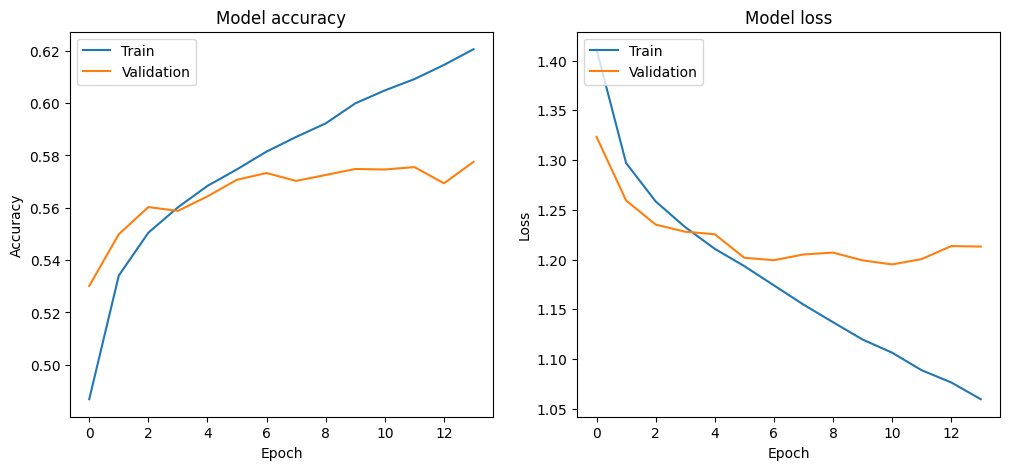

In [7]:
# --- 7. Plot Training History ---

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

  1/344 ━━━━━━━━━━━━━━━━━━━━ 52s 154ms/step

 18/344 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   

 36/344 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 54/344 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 72/344 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

 89/344 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

100/344 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

110/344 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

120/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

130/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

140/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

150/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

160/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

170/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

180/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

190/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

199/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

209/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

219/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

229/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

239/344 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

249/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

259/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

269/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

279/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

289/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

299/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

309/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

319/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

329/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

339/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step



Classification Report (Test Set):

              precision    recall  f1-score   support

       anger       0.50      0.31      0.38       757
     disgust       0.63      0.31      0.41       240
        fear       0.53      0.38      0.44       793
   happiness       0.57      0.66      0.61      3312
  no_emotion       0.61      0.70      0.65      3313
     sadness       0.51      0.55      0.53      1865
    surprise       0.49      0.14      0.22       715

    accuracy                           0.57     10995
   macro avg       0.55      0.44      0.46     10995
weighted avg       0.56      0.57      0.55     10995


Evaluation report saved to: models/bilstm_glove_evaluation_report.txt


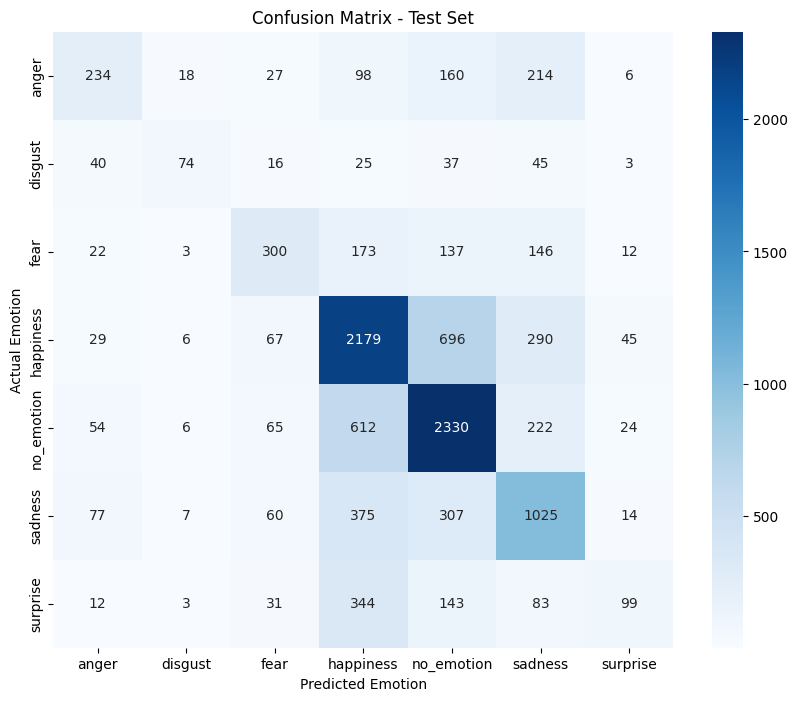

In [8]:
# --- 8. Evaluate on Test Set and Save Report ---

# Load the best model saved during training
best_model = tf.keras.models.load_model(MODELS / 'bilstm_glove_baseline.keras')

# Make predictions on the test set
y_pred_probs = best_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate and print the classification report
print("\nClassification Report (Test Set):\n")
report = classification_report(y_test, y_pred, target_names=label_names)
print(report)

# Save the report
report_path = MODELS / "bilstm_glove_evaluation_report.txt"
with open(report_path, "w") as f:
    f.write("Baseline Model: BiLSTM with GloVe Embeddings (Augmented & Balanced Data)\n")
    f.write("========================================================================\n\n")
    f.write(report)

print(f"\nEvaluation report saved to: {report_path}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual Emotion')
plt.xlabel('Predicted Emotion')
plt.show()